In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [17]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ ~s', Q = ~env(s, a)
    ################################################ ~s', Q = ~env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # min
    #################################################### s'', Q' = ~env(s', ~a')
    next_states = tf.nn.tanh(next_states_logits)
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # min
    return actions_logits, aloss, eloss, aloss2

In [18]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [20]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [21]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [23]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [25]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print('dones:', 
            #       len(dones), np.count_nonzero(dones), 
            #       len(dones1), np.count_nonzero(dones1), 
            #       len(dones2), np.count_nonzero(dones2))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.7048 eloss:3.3174 aloss2:2.8746 exploreP:0.9984
Episode:1 meanR:21.5000 R:27.0000 rate:0.0540 aloss:0.7055 eloss:3.2478 aloss2:2.9540 exploreP:0.9958
Episode:2 meanR:21.0000 R:20.0000 rate:0.0400 aloss:0.7022 eloss:3.2901 aloss2:2.9005 exploreP:0.9938
Episode:3 meanR:19.2500 R:14.0000 rate:0.0280 aloss:0.7010 eloss:3.2771 aloss2:2.9174 exploreP:0.9924
Episode:4 meanR:20.8000 R:27.0000 rate:0.0540 aloss:0.7024 eloss:3.2529 aloss2:2.9339 exploreP:0.9898
Episode:5 meanR:20.0000 R:16.0000 rate:0.0320 aloss:0.7007 eloss:3.2455 aloss2:2.9326 exploreP:0.9882
Episode:6 meanR:21.0000 R:27.0000 rate:0.0540 aloss:0.6997 eloss:3.2472 aloss2:2.9395 exploreP:0.9856
Episode:7 meanR:20.2500 R:15.0000 rate:0.0300 aloss:0.6964 eloss:3.2043 aloss2:2.9876 exploreP:0.9841
Episode:8 meanR:20.0000 R:18.0000 rate:0.0360 aloss:0.6975 eloss:3.2012 aloss2:2.9812 exploreP:0.9823
Episode:9 meanR:21.3000 R:33.0000 rate:0.0660 aloss:0.7003 eloss:3.1816 aloss2:3.0

Episode:80 meanR:24.3580 R:86.0000 rate:0.1720 aloss:0.6742 eloss:1.7150 aloss2:5.9160 exploreP:0.8227
Episode:81 meanR:24.8415 R:64.0000 rate:0.1280 aloss:0.6750 eloss:1.6694 aloss2:6.1181 exploreP:0.8175
Episode:82 meanR:24.9880 R:37.0000 rate:0.0740 aloss:0.6719 eloss:1.6490 aloss2:6.1471 exploreP:0.8146
Episode:83 meanR:24.9048 R:18.0000 rate:0.0360 aloss:0.6718 eloss:1.6275 aloss2:6.3803 exploreP:0.8131
Episode:84 meanR:25.0471 R:37.0000 rate:0.0740 aloss:0.6756 eloss:1.6262 aloss2:6.3233 exploreP:0.8102
Episode:85 meanR:25.1279 R:32.0000 rate:0.0640 aloss:0.6730 eloss:1.6041 aloss2:6.5152 exploreP:0.8076
Episode:86 meanR:25.2184 R:33.0000 rate:0.0660 aloss:0.6741 eloss:1.6006 aloss2:6.4871 exploreP:0.8050
Episode:87 meanR:25.3977 R:41.0000 rate:0.0820 aloss:0.6753 eloss:1.5764 aloss2:6.5793 exploreP:0.8017
Episode:88 meanR:25.3596 R:22.0000 rate:0.0440 aloss:0.6682 eloss:1.5671 aloss2:6.6839 exploreP:0.8000
Episode:89 meanR:25.3000 R:20.0000 rate:0.0400 aloss:0.6724 eloss:1.5381 

Episode:159 meanR:39.3500 R:27.0000 rate:0.0540 aloss:0.6792 eloss:1.3173 aloss2:10.7869 exploreP:0.5961
Episode:160 meanR:39.6900 R:64.0000 rate:0.1280 aloss:0.6791 eloss:1.3096 aloss2:10.7985 exploreP:0.5924
Episode:161 meanR:39.8200 R:26.0000 rate:0.0520 aloss:0.6795 eloss:1.3191 aloss2:10.7050 exploreP:0.5909
Episode:162 meanR:39.8400 R:13.0000 rate:0.0260 aloss:0.6799 eloss:1.3233 aloss2:11.0580 exploreP:0.5901
Episode:163 meanR:40.2400 R:79.0000 rate:0.1580 aloss:0.6804 eloss:1.3004 aloss2:10.8925 exploreP:0.5855
Episode:164 meanR:40.3400 R:29.0000 rate:0.0580 aloss:0.6745 eloss:1.2947 aloss2:10.8869 exploreP:0.5839
Episode:165 meanR:41.1800 R:101.0000 rate:0.2020 aloss:0.6757 eloss:1.3137 aloss2:10.8755 exploreP:0.5781
Episode:166 meanR:41.4500 R:58.0000 rate:0.1160 aloss:0.6741 eloss:1.2920 aloss2:10.8089 exploreP:0.5748
Episode:167 meanR:41.8400 R:63.0000 rate:0.1260 aloss:0.6763 eloss:1.3321 aloss2:10.8275 exploreP:0.5713
Episode:168 meanR:41.8500 R:16.0000 rate:0.0320 aloss:

Episode:237 meanR:69.8400 R:64.0000 rate:0.1280 aloss:0.6933 eloss:1.3277 aloss2:11.1392 exploreP:0.3278
Episode:238 meanR:70.0500 R:35.0000 rate:0.0700 aloss:0.7020 eloss:1.2588 aloss2:11.1117 exploreP:0.3267
Episode:239 meanR:70.4800 R:68.0000 rate:0.1360 aloss:0.7006 eloss:1.3099 aloss2:11.1112 exploreP:0.3246
Episode:240 meanR:70.6900 R:49.0000 rate:0.0980 aloss:0.7010 eloss:1.3155 aloss2:11.2817 exploreP:0.3230
Episode:241 meanR:71.2800 R:69.0000 rate:0.1380 aloss:0.7069 eloss:1.3237 aloss2:11.1232 exploreP:0.3209
Episode:242 meanR:71.7200 R:59.0000 rate:0.1180 aloss:0.6846 eloss:1.3123 aloss2:11.1209 exploreP:0.3191
Episode:243 meanR:71.6400 R:62.0000 rate:0.1240 aloss:0.6914 eloss:1.2721 aloss2:11.1237 exploreP:0.3171
Episode:244 meanR:71.9500 R:123.0000 rate:0.2460 aloss:0.6937 eloss:1.3017 aloss2:11.1465 exploreP:0.3134
Episode:245 meanR:71.6400 R:44.0000 rate:0.0880 aloss:0.6926 eloss:1.2820 aloss2:11.1861 exploreP:0.3121
Episode:246 meanR:72.4800 R:105.0000 rate:0.2100 aloss

Episode:315 meanR:50.6800 R:23.0000 rate:0.0460 aloss:0.6984 eloss:1.3567 aloss2:11.1781 exploreP:0.2372
Episode:316 meanR:50.5600 R:49.0000 rate:0.0980 aloss:0.6915 eloss:1.3238 aloss2:11.0797 exploreP:0.2361
Episode:317 meanR:50.0500 R:17.0000 rate:0.0340 aloss:0.6865 eloss:1.3312 aloss2:11.1750 exploreP:0.2357
Episode:318 meanR:49.7500 R:26.0000 rate:0.0520 aloss:0.7038 eloss:1.2847 aloss2:11.1251 exploreP:0.2351
Episode:319 meanR:48.6400 R:27.0000 rate:0.0540 aloss:0.6837 eloss:1.3151 aloss2:11.0866 exploreP:0.2345
Episode:320 meanR:47.5700 R:11.0000 rate:0.0220 aloss:0.6777 eloss:1.3513 aloss2:11.1539 exploreP:0.2343
Episode:321 meanR:47.2700 R:22.0000 rate:0.0440 aloss:0.6848 eloss:1.3256 aloss2:11.1345 exploreP:0.2338
Episode:322 meanR:47.4900 R:41.0000 rate:0.0820 aloss:0.6910 eloss:1.2822 aloss2:11.0947 exploreP:0.2329
Episode:323 meanR:46.6600 R:45.0000 rate:0.0900 aloss:0.6943 eloss:1.3494 aloss2:11.2254 exploreP:0.2319
Episode:324 meanR:46.3000 R:23.0000 rate:0.0460 aloss:0

Episode:394 meanR:22.2800 R:23.0000 rate:0.0460 aloss:0.6922 eloss:1.3828 aloss2:11.1981 exploreP:0.2014
Episode:395 meanR:22.3100 R:26.0000 rate:0.0520 aloss:0.6906 eloss:1.2839 aloss2:11.1504 exploreP:0.2009
Episode:396 meanR:22.4500 R:26.0000 rate:0.0520 aloss:0.6892 eloss:1.3791 aloss2:11.2373 exploreP:0.2004
Episode:397 meanR:22.3600 R:30.0000 rate:0.0600 aloss:0.6992 eloss:1.3003 aloss2:10.9636 exploreP:0.1998
Episode:398 meanR:22.4300 R:19.0000 rate:0.0380 aloss:0.6824 eloss:1.3567 aloss2:10.9953 exploreP:0.1994
Episode:399 meanR:22.5400 R:23.0000 rate:0.0460 aloss:0.6969 eloss:1.3539 aloss2:11.1253 exploreP:0.1990
Episode:400 meanR:22.5600 R:27.0000 rate:0.0540 aloss:0.6980 eloss:1.3093 aloss2:11.0214 exploreP:0.1985
Episode:401 meanR:22.5200 R:28.0000 rate:0.0560 aloss:0.6906 eloss:1.3003 aloss2:10.9700 exploreP:0.1980
Episode:402 meanR:22.4700 R:19.0000 rate:0.0380 aloss:0.7028 eloss:1.3070 aloss2:11.2061 exploreP:0.1976
Episode:403 meanR:22.3600 R:10.0000 rate:0.0200 aloss:0

Episode:472 meanR:43.5300 R:177.0000 rate:0.3540 aloss:0.7097 eloss:1.3288 aloss2:11.2149 exploreP:0.1398
Episode:473 meanR:44.7100 R:128.0000 rate:0.2560 aloss:0.6978 eloss:1.3623 aloss2:11.1663 exploreP:0.1382
Episode:474 meanR:45.7000 R:136.0000 rate:0.2720 aloss:0.7155 eloss:1.3056 aloss2:11.0663 exploreP:0.1365
Episode:475 meanR:47.3300 R:183.0000 rate:0.3660 aloss:0.7412 eloss:1.3281 aloss2:11.1030 exploreP:0.1342
Episode:476 meanR:47.8400 R:77.0000 rate:0.1540 aloss:0.7667 eloss:1.3042 aloss2:10.9717 exploreP:0.1332
Episode:477 meanR:48.5600 R:82.0000 rate:0.1640 aloss:0.7620 eloss:1.3536 aloss2:11.2271 exploreP:0.1322
Episode:478 meanR:48.9800 R:52.0000 rate:0.1040 aloss:0.7398 eloss:1.2714 aloss2:11.0317 exploreP:0.1316
Episode:479 meanR:50.5400 R:177.0000 rate:0.3540 aloss:0.7423 eloss:1.3436 aloss2:11.0188 exploreP:0.1294
Episode:480 meanR:51.4300 R:111.0000 rate:0.2220 aloss:0.7825 eloss:1.3490 aloss2:11.0342 exploreP:0.1281
Episode:481 meanR:52.1000 R:77.0000 rate:0.1540 a

Episode:551 meanR:50.0800 R:10.0000 rate:0.0200 aloss:0.8087 eloss:1.2965 aloss2:10.9722 exploreP:0.1097
Episode:552 meanR:49.0700 R:8.0000 rate:0.0160 aloss:0.7415 eloss:1.3306 aloss2:10.7169 exploreP:0.1096
Episode:553 meanR:48.6700 R:10.0000 rate:0.0200 aloss:0.8121 eloss:1.4180 aloss2:10.7316 exploreP:0.1095
Episode:554 meanR:48.0200 R:22.0000 rate:0.0440 aloss:0.7446 eloss:1.3613 aloss2:11.0104 exploreP:0.1093
Episode:555 meanR:46.9300 R:10.0000 rate:0.0200 aloss:0.7376 eloss:1.4106 aloss2:11.1439 exploreP:0.1092
Episode:556 meanR:46.2000 R:8.0000 rate:0.0160 aloss:0.7665 eloss:1.4024 aloss2:11.0980 exploreP:0.1091
Episode:557 meanR:45.4500 R:9.0000 rate:0.0180 aloss:0.7782 eloss:1.6129 aloss2:11.3466 exploreP:0.1090
Episode:558 meanR:43.8600 R:11.0000 rate:0.0220 aloss:0.7506 eloss:1.3445 aloss2:10.7214 exploreP:0.1089
Episode:559 meanR:43.2300 R:12.0000 rate:0.0240 aloss:0.7697 eloss:1.2506 aloss2:10.7832 exploreP:0.1088
Episode:560 meanR:42.5400 R:15.0000 rate:0.0300 aloss:0.76

Episode:630 meanR:14.6900 R:22.0000 rate:0.0440 aloss:0.8019 eloss:1.3519 aloss2:10.9809 exploreP:0.0983
Episode:631 meanR:14.7400 R:15.0000 rate:0.0300 aloss:0.7637 eloss:1.3198 aloss2:11.1991 exploreP:0.0982
Episode:632 meanR:14.5900 R:10.0000 rate:0.0200 aloss:0.7840 eloss:1.3638 aloss2:10.6989 exploreP:0.0981
Episode:633 meanR:14.4900 R:10.0000 rate:0.0200 aloss:0.7658 eloss:1.2549 aloss2:10.8399 exploreP:0.0980
Episode:634 meanR:14.4300 R:9.0000 rate:0.0180 aloss:0.7531 eloss:1.2598 aloss2:10.8923 exploreP:0.0980
Episode:635 meanR:14.3300 R:11.0000 rate:0.0220 aloss:0.7763 eloss:1.3742 aloss2:10.9464 exploreP:0.0979
Episode:636 meanR:14.3400 R:10.0000 rate:0.0200 aloss:0.7825 eloss:1.2595 aloss2:10.6671 exploreP:0.0978
Episode:637 meanR:14.3300 R:11.0000 rate:0.0220 aloss:0.7966 eloss:1.3242 aloss2:11.2370 exploreP:0.0977
Episode:638 meanR:14.3500 R:10.0000 rate:0.0200 aloss:0.7079 eloss:1.2482 aloss2:11.0238 exploreP:0.0976
Episode:639 meanR:14.3600 R:9.0000 rate:0.0180 aloss:0.8

Episode:709 meanR:18.1600 R:26.0000 rate:0.0520 aloss:0.7372 eloss:1.3346 aloss2:11.0767 exploreP:0.0865
Episode:710 meanR:18.1600 R:15.0000 rate:0.0300 aloss:0.7482 eloss:1.2490 aloss2:11.0574 exploreP:0.0864
Episode:711 meanR:18.3100 R:35.0000 rate:0.0700 aloss:0.7479 eloss:1.3415 aloss2:11.0286 exploreP:0.0861
Episode:712 meanR:18.1700 R:10.0000 rate:0.0200 aloss:0.8390 eloss:1.3521 aloss2:11.4043 exploreP:0.0860
Episode:713 meanR:18.1900 R:30.0000 rate:0.0600 aloss:0.7841 eloss:1.3437 aloss2:11.0892 exploreP:0.0858
Episode:714 meanR:18.2400 R:23.0000 rate:0.0460 aloss:0.7847 eloss:1.4918 aloss2:11.1379 exploreP:0.0856
Episode:715 meanR:18.2900 R:22.0000 rate:0.0440 aloss:0.7628 eloss:1.3206 aloss2:10.8748 exploreP:0.0855
Episode:716 meanR:18.1300 R:11.0000 rate:0.0220 aloss:0.7750 eloss:1.5160 aloss2:11.2475 exploreP:0.0854
Episode:717 meanR:18.3100 R:28.0000 rate:0.0560 aloss:0.7470 eloss:1.3962 aloss2:10.8688 exploreP:0.0852
Episode:718 meanR:18.2100 R:10.0000 rate:0.0200 aloss:0

Episode:788 meanR:26.4100 R:28.0000 rate:0.0560 aloss:0.7855 eloss:1.4145 aloss2:11.1359 exploreP:0.0715
Episode:789 meanR:26.5700 R:43.0000 rate:0.0860 aloss:0.7967 eloss:1.3591 aloss2:11.0517 exploreP:0.0712
Episode:790 meanR:26.6400 R:27.0000 rate:0.0540 aloss:0.7696 eloss:1.3670 aloss2:11.1742 exploreP:0.0710
Episode:791 meanR:26.6700 R:30.0000 rate:0.0600 aloss:0.7751 eloss:1.2809 aloss2:10.9282 exploreP:0.0709
Episode:792 meanR:26.9300 R:46.0000 rate:0.0920 aloss:0.7630 eloss:1.4410 aloss2:11.0269 exploreP:0.0706
Episode:793 meanR:27.0600 R:37.0000 rate:0.0740 aloss:0.7877 eloss:1.3474 aloss2:10.8659 exploreP:0.0704
Episode:794 meanR:27.2700 R:31.0000 rate:0.0620 aloss:0.7993 eloss:1.3440 aloss2:10.8796 exploreP:0.0702
Episode:795 meanR:27.4200 R:32.0000 rate:0.0640 aloss:0.7716 eloss:1.3642 aloss2:10.8066 exploreP:0.0700
Episode:796 meanR:27.5400 R:37.0000 rate:0.0740 aloss:0.7924 eloss:1.4105 aloss2:11.0746 exploreP:0.0698
Episode:797 meanR:27.5800 R:32.0000 rate:0.0640 aloss:0

Episode:867 meanR:36.5000 R:49.0000 rate:0.0980 aloss:0.7433 eloss:1.3011 aloss2:11.1029 exploreP:0.0557
Episode:868 meanR:36.5800 R:34.0000 rate:0.0680 aloss:0.7888 eloss:1.4567 aloss2:11.2698 exploreP:0.0555
Episode:869 meanR:36.6800 R:40.0000 rate:0.0800 aloss:0.7540 eloss:1.2927 aloss2:11.0629 exploreP:0.0554
Episode:870 meanR:36.6800 R:32.0000 rate:0.0640 aloss:0.7749 eloss:1.2965 aloss2:11.2310 exploreP:0.0552
Episode:871 meanR:36.6700 R:45.0000 rate:0.0900 aloss:0.7896 eloss:1.3388 aloss2:11.1637 exploreP:0.0550
Episode:872 meanR:36.7100 R:43.0000 rate:0.0860 aloss:0.7653 eloss:1.3294 aloss2:11.0945 exploreP:0.0548
Episode:873 meanR:36.8700 R:44.0000 rate:0.0880 aloss:0.7432 eloss:1.3889 aloss2:11.1087 exploreP:0.0546
Episode:874 meanR:36.8600 R:33.0000 rate:0.0660 aloss:0.8086 eloss:1.3851 aloss2:11.1446 exploreP:0.0545
Episode:875 meanR:36.9900 R:48.0000 rate:0.0960 aloss:0.7679 eloss:1.3848 aloss2:10.9237 exploreP:0.0543
Episode:876 meanR:37.0700 R:39.0000 rate:0.0780 aloss:0

Episode:946 meanR:42.9300 R:45.0000 rate:0.0900 aloss:0.7554 eloss:1.3198 aloss2:11.0592 exploreP:0.0424
Episode:947 meanR:42.9700 R:52.0000 rate:0.1040 aloss:0.7782 eloss:1.2979 aloss2:11.1067 exploreP:0.0422
Episode:948 meanR:43.1100 R:45.0000 rate:0.0900 aloss:0.8419 eloss:1.3595 aloss2:11.2121 exploreP:0.0421
Episode:949 meanR:43.1200 R:37.0000 rate:0.0740 aloss:0.7632 eloss:1.3657 aloss2:11.1155 exploreP:0.0419
Episode:950 meanR:43.1800 R:50.0000 rate:0.1000 aloss:0.7354 eloss:1.2930 aloss2:10.9417 exploreP:0.0418
Episode:951 meanR:43.1200 R:43.0000 rate:0.0860 aloss:0.7637 eloss:1.3093 aloss2:11.1883 exploreP:0.0416
Episode:952 meanR:43.2300 R:50.0000 rate:0.1000 aloss:0.7806 eloss:1.2894 aloss2:11.0807 exploreP:0.0415
Episode:953 meanR:43.4000 R:47.0000 rate:0.0940 aloss:0.7180 eloss:1.2912 aloss2:11.1549 exploreP:0.0413
Episode:954 meanR:43.4200 R:49.0000 rate:0.0980 aloss:0.7360 eloss:1.3272 aloss2:11.1266 exploreP:0.0412
Episode:955 meanR:43.4600 R:48.0000 rate:0.0960 aloss:0

Episode:1024 meanR:44.0100 R:38.0000 rate:0.0760 aloss:0.7881 eloss:1.3267 aloss2:11.1599 exploreP:0.0330
Episode:1025 meanR:43.9200 R:42.0000 rate:0.0840 aloss:0.7503 eloss:1.3109 aloss2:11.2043 exploreP:0.0329
Episode:1026 meanR:43.8900 R:45.0000 rate:0.0900 aloss:0.6966 eloss:1.2751 aloss2:11.0026 exploreP:0.0328
Episode:1027 meanR:43.9600 R:50.0000 rate:0.1000 aloss:0.7143 eloss:1.2831 aloss2:11.2089 exploreP:0.0326
Episode:1028 meanR:43.8800 R:38.0000 rate:0.0760 aloss:0.7307 eloss:1.3921 aloss2:11.2270 exploreP:0.0326
Episode:1029 meanR:43.9700 R:44.0000 rate:0.0880 aloss:0.7331 eloss:1.2984 aloss2:11.0797 exploreP:0.0325
Episode:1030 meanR:43.9800 R:45.0000 rate:0.0900 aloss:0.7427 eloss:1.3393 aloss2:11.2884 exploreP:0.0324
Episode:1031 meanR:43.9100 R:43.0000 rate:0.0860 aloss:0.7740 eloss:1.3792 aloss2:11.1882 exploreP:0.0323
Episode:1032 meanR:43.8900 R:42.0000 rate:0.0840 aloss:0.7592 eloss:1.3703 aloss2:11.0261 exploreP:0.0322
Episode:1033 meanR:43.9500 R:45.0000 rate:0.09

Episode:1102 meanR:39.1500 R:39.0000 rate:0.0780 aloss:0.7615 eloss:1.2678 aloss2:11.0983 exploreP:0.0271
Episode:1103 meanR:39.0600 R:33.0000 rate:0.0660 aloss:0.7537 eloss:1.3253 aloss2:11.3348 exploreP:0.0270
Episode:1104 meanR:39.0700 R:52.0000 rate:0.1040 aloss:0.7676 eloss:1.3521 aloss2:11.0896 exploreP:0.0269
Episode:1105 meanR:39.0100 R:37.0000 rate:0.0740 aloss:0.6900 eloss:1.3287 aloss2:11.1244 exploreP:0.0269
Episode:1106 meanR:38.8900 R:34.0000 rate:0.0680 aloss:0.8433 eloss:1.4055 aloss2:11.3080 exploreP:0.0268
Episode:1107 meanR:38.8800 R:39.0000 rate:0.0780 aloss:0.7205 eloss:1.3115 aloss2:11.0695 exploreP:0.0268
Episode:1108 meanR:38.8300 R:34.0000 rate:0.0680 aloss:0.6770 eloss:1.3174 aloss2:10.9408 exploreP:0.0267
Episode:1109 meanR:38.7400 R:37.0000 rate:0.0740 aloss:0.7563 eloss:1.3080 aloss2:11.0333 exploreP:0.0266
Episode:1110 meanR:38.6300 R:35.0000 rate:0.0700 aloss:0.7206 eloss:1.3094 aloss2:11.0056 exploreP:0.0266
Episode:1111 meanR:38.6700 R:42.0000 rate:0.08

Episode:1180 meanR:33.7500 R:35.0000 rate:0.0700 aloss:0.7609 eloss:1.3197 aloss2:11.1750 exploreP:0.0231
Episode:1181 meanR:33.9700 R:46.0000 rate:0.0920 aloss:0.7442 eloss:1.3235 aloss2:11.1148 exploreP:0.0231
Episode:1182 meanR:33.7900 R:34.0000 rate:0.0680 aloss:0.7907 eloss:1.3538 aloss2:11.2160 exploreP:0.0230
Episode:1183 meanR:33.5500 R:20.0000 rate:0.0400 aloss:0.9229 eloss:1.2889 aloss2:11.1987 exploreP:0.0230
Episode:1184 meanR:33.4700 R:29.0000 rate:0.0580 aloss:0.7473 eloss:1.2936 aloss2:11.0308 exploreP:0.0230
Episode:1185 meanR:33.4500 R:30.0000 rate:0.0600 aloss:0.7665 eloss:1.3550 aloss2:11.1928 exploreP:0.0229
Episode:1186 meanR:33.4000 R:27.0000 rate:0.0540 aloss:0.7295 eloss:1.2465 aloss2:11.0254 exploreP:0.0229
Episode:1187 meanR:33.3900 R:28.0000 rate:0.0560 aloss:0.7072 eloss:1.3059 aloss2:11.0584 exploreP:0.0229
Episode:1188 meanR:33.4100 R:30.0000 rate:0.0600 aloss:0.8105 eloss:1.3542 aloss2:11.1215 exploreP:0.0228
Episode:1189 meanR:33.5300 R:44.0000 rate:0.08

Episode:1258 meanR:32.3700 R:26.0000 rate:0.0520 aloss:0.7620 eloss:1.2753 aloss2:10.8874 exploreP:0.0202
Episode:1259 meanR:32.5800 R:46.0000 rate:0.0920 aloss:0.7753 eloss:1.3173 aloss2:11.0456 exploreP:0.0202
Episode:1260 meanR:32.7200 R:48.0000 rate:0.0960 aloss:0.6697 eloss:1.2564 aloss2:11.0338 exploreP:0.0201
Episode:1261 meanR:32.7300 R:30.0000 rate:0.0600 aloss:0.7102 eloss:1.3429 aloss2:11.2409 exploreP:0.0201
Episode:1262 meanR:32.7200 R:27.0000 rate:0.0540 aloss:0.6495 eloss:1.2245 aloss2:11.1259 exploreP:0.0201
Episode:1263 meanR:32.7500 R:36.0000 rate:0.0720 aloss:0.7468 eloss:1.3455 aloss2:11.2689 exploreP:0.0200
Episode:1264 meanR:32.7400 R:27.0000 rate:0.0540 aloss:0.6467 eloss:1.3656 aloss2:11.1666 exploreP:0.0200
Episode:1265 meanR:32.8900 R:44.0000 rate:0.0880 aloss:0.6639 eloss:1.2547 aloss2:11.1041 exploreP:0.0200
Episode:1266 meanR:32.9600 R:31.0000 rate:0.0620 aloss:0.6976 eloss:1.2864 aloss2:11.1934 exploreP:0.0199
Episode:1267 meanR:32.8800 R:29.0000 rate:0.05

Episode:1336 meanR:33.3800 R:31.0000 rate:0.0620 aloss:0.7148 eloss:1.3430 aloss2:11.2353 exploreP:0.0178
Episode:1337 meanR:33.5000 R:35.0000 rate:0.0700 aloss:0.6660 eloss:1.2844 aloss2:11.1575 exploreP:0.0178
Episode:1338 meanR:33.6200 R:43.0000 rate:0.0860 aloss:0.7111 eloss:1.2927 aloss2:11.2639 exploreP:0.0178
Episode:1339 meanR:33.6300 R:34.0000 rate:0.0680 aloss:0.6890 eloss:1.2883 aloss2:11.2183 exploreP:0.0177
Episode:1340 meanR:33.7400 R:45.0000 rate:0.0900 aloss:0.6896 eloss:1.3105 aloss2:11.2322 exploreP:0.0177
Episode:1341 meanR:33.6800 R:23.0000 rate:0.0460 aloss:0.7657 eloss:1.4449 aloss2:11.1029 exploreP:0.0177
Episode:1342 meanR:33.8000 R:39.0000 rate:0.0780 aloss:0.7168 eloss:1.3019 aloss2:11.1751 exploreP:0.0177
Episode:1343 meanR:33.8800 R:36.0000 rate:0.0720 aloss:0.6588 eloss:1.2559 aloss2:11.2273 exploreP:0.0176
Episode:1344 meanR:33.9800 R:41.0000 rate:0.0820 aloss:0.6697 eloss:1.2556 aloss2:11.2100 exploreP:0.0176
Episode:1345 meanR:33.9200 R:36.0000 rate:0.07

Episode:1414 meanR:37.4200 R:49.0000 rate:0.0980 aloss:0.6708 eloss:1.3028 aloss2:11.1893 exploreP:0.0158
Episode:1415 meanR:37.4100 R:45.0000 rate:0.0900 aloss:0.6570 eloss:1.3082 aloss2:11.2263 exploreP:0.0158
Episode:1416 meanR:37.5400 R:48.0000 rate:0.0960 aloss:0.6772 eloss:1.3314 aloss2:11.3447 exploreP:0.0157
Episode:1417 meanR:37.6800 R:41.0000 rate:0.0820 aloss:0.7247 eloss:1.3281 aloss2:11.2798 exploreP:0.0157
Episode:1418 meanR:37.9100 R:51.0000 rate:0.1020 aloss:0.6629 eloss:1.2989 aloss2:11.2477 exploreP:0.0157
Episode:1419 meanR:38.0200 R:45.0000 rate:0.0900 aloss:0.6983 eloss:1.2664 aloss2:11.2222 exploreP:0.0157
Episode:1420 meanR:38.1300 R:39.0000 rate:0.0780 aloss:0.6487 eloss:1.2766 aloss2:11.3794 exploreP:0.0156
Episode:1421 meanR:38.2100 R:34.0000 rate:0.0680 aloss:0.6716 eloss:1.3460 aloss2:11.2891 exploreP:0.0156
Episode:1422 meanR:38.3400 R:41.0000 rate:0.0820 aloss:0.7040 eloss:1.3626 aloss2:11.4086 exploreP:0.0156
Episode:1423 meanR:38.3500 R:40.0000 rate:0.08

Episode:1492 meanR:37.5000 R:41.0000 rate:0.0820 aloss:0.6783 eloss:1.3089 aloss2:11.3014 exploreP:0.0143
Episode:1493 meanR:37.4500 R:28.0000 rate:0.0560 aloss:0.6322 eloss:1.3802 aloss2:11.2541 exploreP:0.0143
Episode:1494 meanR:37.4300 R:41.0000 rate:0.0820 aloss:0.6624 eloss:1.2849 aloss2:11.1851 exploreP:0.0143
Episode:1495 meanR:37.3900 R:36.0000 rate:0.0720 aloss:0.6904 eloss:1.3437 aloss2:11.1368 exploreP:0.0143
Episode:1496 meanR:37.4100 R:37.0000 rate:0.0740 aloss:0.7062 eloss:1.2633 aloss2:11.2635 exploreP:0.0143
Episode:1497 meanR:37.5600 R:45.0000 rate:0.0900 aloss:0.6250 eloss:1.2935 aloss2:11.3191 exploreP:0.0142
Episode:1498 meanR:37.6800 R:39.0000 rate:0.0780 aloss:0.6202 eloss:1.3368 aloss2:11.3612 exploreP:0.0142
Episode:1499 meanR:37.5600 R:34.0000 rate:0.0680 aloss:0.6091 eloss:1.3080 aloss2:11.3202 exploreP:0.0142
Episode:1500 meanR:37.6300 R:35.0000 rate:0.0700 aloss:0.6960 eloss:1.3545 aloss2:11.2672 exploreP:0.0142
Episode:1501 meanR:37.7100 R:41.0000 rate:0.08

Episode:1570 meanR:34.7300 R:31.0000 rate:0.0620 aloss:0.6445 eloss:1.3080 aloss2:11.2864 exploreP:0.0133
Episode:1571 meanR:34.6900 R:34.0000 rate:0.0680 aloss:0.6498 eloss:1.2843 aloss2:11.3465 exploreP:0.0133
Episode:1572 meanR:34.5800 R:28.0000 rate:0.0560 aloss:0.6699 eloss:1.3078 aloss2:11.4390 exploreP:0.0133
Episode:1573 meanR:34.4600 R:29.0000 rate:0.0580 aloss:0.6812 eloss:1.3384 aloss2:11.3099 exploreP:0.0133
Episode:1574 meanR:34.3300 R:29.0000 rate:0.0580 aloss:0.6331 eloss:1.2625 aloss2:11.3670 exploreP:0.0133
Episode:1575 meanR:34.3000 R:26.0000 rate:0.0520 aloss:0.6667 eloss:1.2957 aloss2:11.4753 exploreP:0.0133
Episode:1576 meanR:34.2200 R:35.0000 rate:0.0700 aloss:0.7063 eloss:1.2922 aloss2:11.3475 exploreP:0.0133
Episode:1577 meanR:34.0700 R:26.0000 rate:0.0520 aloss:0.7113 eloss:1.2698 aloss2:11.3306 exploreP:0.0133
Episode:1578 meanR:34.0600 R:31.0000 rate:0.0620 aloss:0.6758 eloss:1.2953 aloss2:11.2087 exploreP:0.0132
Episode:1579 meanR:34.0000 R:37.0000 rate:0.07

Episode:1648 meanR:30.1400 R:30.0000 rate:0.0600 aloss:0.5612 eloss:1.2522 aloss2:11.4044 exploreP:0.0126
Episode:1649 meanR:30.0700 R:30.0000 rate:0.0600 aloss:0.6907 eloss:1.2567 aloss2:11.5861 exploreP:0.0126
Episode:1650 meanR:29.9700 R:24.0000 rate:0.0480 aloss:0.6840 eloss:1.3102 aloss2:11.5504 exploreP:0.0126
Episode:1651 meanR:29.9900 R:26.0000 rate:0.0520 aloss:0.6247 eloss:1.2118 aloss2:11.4963 exploreP:0.0126
Episode:1652 meanR:30.0500 R:30.0000 rate:0.0600 aloss:0.7148 eloss:1.3320 aloss2:11.6971 exploreP:0.0126
Episode:1653 meanR:30.0200 R:30.0000 rate:0.0600 aloss:0.7386 eloss:1.3394 aloss2:11.4146 exploreP:0.0126
Episode:1654 meanR:29.8700 R:26.0000 rate:0.0520 aloss:0.6588 eloss:1.2406 aloss2:11.3012 exploreP:0.0126
Episode:1655 meanR:29.7100 R:26.0000 rate:0.0520 aloss:0.5986 eloss:1.2722 aloss2:11.2750 exploreP:0.0126
Episode:1656 meanR:29.6900 R:26.0000 rate:0.0520 aloss:0.5619 eloss:1.1995 aloss2:11.3744 exploreP:0.0126
Episode:1657 meanR:29.6100 R:24.0000 rate:0.04

Episode:1726 meanR:28.4200 R:30.0000 rate:0.0600 aloss:0.6308 eloss:1.4355 aloss2:11.2224 exploreP:0.0121
Episode:1727 meanR:28.4400 R:34.0000 rate:0.0680 aloss:0.6949 eloss:1.2802 aloss2:11.3486 exploreP:0.0121
Episode:1728 meanR:28.4600 R:26.0000 rate:0.0520 aloss:0.6350 eloss:1.2505 aloss2:11.2552 exploreP:0.0121
Episode:1729 meanR:28.5000 R:34.0000 rate:0.0680 aloss:0.6358 eloss:1.3270 aloss2:11.4239 exploreP:0.0121
Episode:1730 meanR:28.5300 R:31.0000 rate:0.0620 aloss:0.5923 eloss:1.2728 aloss2:11.1260 exploreP:0.0121
Episode:1731 meanR:28.5200 R:31.0000 rate:0.0620 aloss:0.6220 eloss:1.3121 aloss2:11.3596 exploreP:0.0121
Episode:1732 meanR:28.5000 R:26.0000 rate:0.0520 aloss:0.6053 eloss:1.2610 aloss2:11.2468 exploreP:0.0121
Episode:1733 meanR:28.5200 R:25.0000 rate:0.0500 aloss:0.5996 eloss:1.2562 aloss2:11.2917 exploreP:0.0121
Episode:1734 meanR:28.4800 R:27.0000 rate:0.0540 aloss:0.6185 eloss:1.2875 aloss2:11.3286 exploreP:0.0121
Episode:1735 meanR:28.5400 R:34.0000 rate:0.06

Episode:1804 meanR:27.8400 R:31.0000 rate:0.0620 aloss:0.6004 eloss:1.2241 aloss2:11.5256 exploreP:0.0117
Episode:1805 meanR:27.8400 R:26.0000 rate:0.0520 aloss:0.6342 eloss:1.2545 aloss2:11.4810 exploreP:0.0117
Episode:1806 meanR:27.8200 R:23.0000 rate:0.0460 aloss:0.5842 eloss:1.2744 aloss2:11.5810 exploreP:0.0117
Episode:1807 meanR:27.8400 R:28.0000 rate:0.0560 aloss:0.6199 eloss:1.2659 aloss2:11.4435 exploreP:0.0117
Episode:1808 meanR:27.9400 R:30.0000 rate:0.0600 aloss:0.6386 eloss:1.3095 aloss2:11.5069 exploreP:0.0117
Episode:1809 meanR:27.8000 R:22.0000 rate:0.0440 aloss:0.6120 eloss:1.3206 aloss2:11.7348 exploreP:0.0117
Episode:1810 meanR:27.8600 R:34.0000 rate:0.0680 aloss:0.6407 eloss:1.3606 aloss2:11.4220 exploreP:0.0117
Episode:1811 meanR:27.8900 R:28.0000 rate:0.0560 aloss:0.6614 eloss:1.3469 aloss2:11.4848 exploreP:0.0117
Episode:1812 meanR:27.8500 R:28.0000 rate:0.0560 aloss:0.5906 eloss:1.2577 aloss2:11.3419 exploreP:0.0117
Episode:1813 meanR:27.8500 R:24.0000 rate:0.04

Episode:1882 meanR:26.9700 R:31.0000 rate:0.0620 aloss:0.5542 eloss:1.2682 aloss2:11.3509 exploreP:0.0114
Episode:1883 meanR:27.0200 R:26.0000 rate:0.0520 aloss:0.6570 eloss:1.2450 aloss2:11.5967 exploreP:0.0114
Episode:1884 meanR:27.0600 R:32.0000 rate:0.0640 aloss:0.6447 eloss:1.3274 aloss2:11.4552 exploreP:0.0114
Episode:1885 meanR:27.0600 R:28.0000 rate:0.0560 aloss:0.5817 eloss:1.2688 aloss2:11.6051 exploreP:0.0114
Episode:1886 meanR:27.0800 R:23.0000 rate:0.0460 aloss:0.5608 eloss:1.2243 aloss2:11.3993 exploreP:0.0114
Episode:1887 meanR:27.1000 R:32.0000 rate:0.0640 aloss:0.5971 eloss:1.2840 aloss2:11.4353 exploreP:0.0114
Episode:1888 meanR:27.1200 R:26.0000 rate:0.0520 aloss:0.6262 eloss:1.3394 aloss2:11.5152 exploreP:0.0114
Episode:1889 meanR:27.0900 R:32.0000 rate:0.0640 aloss:0.5458 eloss:1.2565 aloss2:11.2574 exploreP:0.0114
Episode:1890 meanR:27.1000 R:22.0000 rate:0.0440 aloss:0.6063 eloss:1.2997 aloss2:11.4727 exploreP:0.0114
Episode:1891 meanR:27.0800 R:29.0000 rate:0.05

Episode:1960 meanR:27.3600 R:34.0000 rate:0.0680 aloss:0.6190 eloss:1.2429 aloss2:11.4230 exploreP:0.0111
Episode:1961 meanR:27.3400 R:24.0000 rate:0.0480 aloss:0.6077 eloss:1.3029 aloss2:11.4753 exploreP:0.0111
Episode:1962 meanR:27.3000 R:24.0000 rate:0.0480 aloss:0.5429 eloss:1.2045 aloss2:11.3546 exploreP:0.0111
Episode:1963 meanR:27.3300 R:28.0000 rate:0.0560 aloss:0.6154 eloss:1.3280 aloss2:11.5602 exploreP:0.0111
Episode:1964 meanR:27.3300 R:23.0000 rate:0.0460 aloss:0.5832 eloss:1.2845 aloss2:11.4411 exploreP:0.0111
Episode:1965 meanR:27.3400 R:31.0000 rate:0.0620 aloss:0.5407 eloss:1.2019 aloss2:11.5136 exploreP:0.0111
Episode:1966 meanR:27.2500 R:21.0000 rate:0.0420 aloss:0.6027 eloss:1.2636 aloss2:11.5467 exploreP:0.0111
Episode:1967 meanR:27.2800 R:25.0000 rate:0.0500 aloss:0.5420 eloss:1.2576 aloss2:11.4852 exploreP:0.0111
Episode:1968 meanR:27.2800 R:24.0000 rate:0.0480 aloss:0.6739 eloss:1.3272 aloss2:11.5054 exploreP:0.0111
Episode:1969 meanR:27.2700 R:24.0000 rate:0.04

Episode:2038 meanR:26.9000 R:25.0000 rate:0.0500 aloss:0.5916 eloss:1.2581 aloss2:11.4356 exploreP:0.0109
Episode:2039 meanR:26.8600 R:27.0000 rate:0.0540 aloss:0.5714 eloss:1.2297 aloss2:11.4152 exploreP:0.0109
Episode:2040 meanR:26.8700 R:30.0000 rate:0.0600 aloss:0.6087 eloss:1.2624 aloss2:11.4673 exploreP:0.0109
Episode:2041 meanR:26.8900 R:25.0000 rate:0.0500 aloss:0.5592 eloss:1.3085 aloss2:11.4271 exploreP:0.0109
Episode:2042 meanR:26.8900 R:24.0000 rate:0.0480 aloss:0.6135 eloss:1.3669 aloss2:11.7487 exploreP:0.0109
Episode:2043 meanR:26.9400 R:30.0000 rate:0.0600 aloss:0.5908 eloss:1.2135 aloss2:11.4327 exploreP:0.0109
Episode:2044 meanR:26.9000 R:21.0000 rate:0.0420 aloss:0.6081 eloss:1.2979 aloss2:11.4808 exploreP:0.0109
Episode:2045 meanR:26.9000 R:34.0000 rate:0.0680 aloss:0.5801 eloss:1.3094 aloss2:11.6337 exploreP:0.0109
Episode:2046 meanR:27.0100 R:36.0000 rate:0.0720 aloss:0.5923 eloss:1.3538 aloss2:11.4049 exploreP:0.0109
Episode:2047 meanR:26.9300 R:24.0000 rate:0.04

Episode:2116 meanR:27.7400 R:32.0000 rate:0.0640 aloss:0.5602 eloss:1.2149 aloss2:11.5823 exploreP:0.0107
Episode:2117 meanR:27.7600 R:25.0000 rate:0.0500 aloss:0.6398 eloss:1.2886 aloss2:11.7706 exploreP:0.0107
Episode:2118 meanR:27.7600 R:27.0000 rate:0.0540 aloss:0.5925 eloss:1.2388 aloss2:11.6398 exploreP:0.0107
Episode:2119 meanR:27.8500 R:38.0000 rate:0.0760 aloss:0.5277 eloss:1.2302 aloss2:11.6346 exploreP:0.0107
Episode:2120 meanR:27.9200 R:32.0000 rate:0.0640 aloss:0.6332 eloss:1.3694 aloss2:11.6376 exploreP:0.0107
Episode:2121 meanR:27.9700 R:34.0000 rate:0.0680 aloss:0.5438 eloss:1.2373 aloss2:11.7880 exploreP:0.0107
Episode:2122 meanR:27.9700 R:28.0000 rate:0.0560 aloss:0.5524 eloss:1.2625 aloss2:11.4919 exploreP:0.0107
Episode:2123 meanR:27.9700 R:29.0000 rate:0.0580 aloss:0.5757 eloss:1.2694 aloss2:11.6298 exploreP:0.0107
Episode:2124 meanR:28.0700 R:35.0000 rate:0.0700 aloss:0.5732 eloss:1.2777 aloss2:11.6573 exploreP:0.0107
Episode:2125 meanR:27.9400 R:20.0000 rate:0.04

Episode:2194 meanR:27.1300 R:21.0000 rate:0.0420 aloss:0.5763 eloss:1.2902 aloss2:11.5847 exploreP:0.0106
Episode:2195 meanR:27.1800 R:29.0000 rate:0.0580 aloss:0.5231 eloss:1.2932 aloss2:11.4496 exploreP:0.0106
Episode:2196 meanR:27.1200 R:27.0000 rate:0.0540 aloss:0.5351 eloss:1.1927 aloss2:11.3964 exploreP:0.0106
Episode:2197 meanR:27.1700 R:33.0000 rate:0.0660 aloss:0.5179 eloss:1.2593 aloss2:11.5039 exploreP:0.0106
Episode:2198 meanR:27.2100 R:28.0000 rate:0.0560 aloss:0.6022 eloss:1.2674 aloss2:11.5902 exploreP:0.0106
Episode:2199 meanR:27.2600 R:31.0000 rate:0.0620 aloss:0.6012 eloss:1.2522 aloss2:11.6182 exploreP:0.0106
Episode:2200 meanR:27.2900 R:26.0000 rate:0.0520 aloss:0.5315 eloss:1.2888 aloss2:11.5211 exploreP:0.0106
Episode:2201 meanR:27.1600 R:25.0000 rate:0.0500 aloss:0.5538 eloss:1.2632 aloss2:11.5601 exploreP:0.0106
Episode:2202 meanR:27.1400 R:27.0000 rate:0.0540 aloss:0.5454 eloss:1.2714 aloss2:11.5422 exploreP:0.0106
Episode:2203 meanR:27.2200 R:35.0000 rate:0.07

Episode:2272 meanR:26.8500 R:31.0000 rate:0.0620 aloss:0.5754 eloss:1.2551 aloss2:11.6514 exploreP:0.0105
Episode:2273 meanR:26.8500 R:23.0000 rate:0.0460 aloss:0.6067 eloss:1.2843 aloss2:11.7809 exploreP:0.0105
Episode:2274 meanR:26.7500 R:22.0000 rate:0.0440 aloss:0.5600 eloss:1.1883 aloss2:11.6829 exploreP:0.0105
Episode:2275 meanR:26.7800 R:35.0000 rate:0.0700 aloss:0.5186 eloss:1.2570 aloss2:11.8123 exploreP:0.0105
Episode:2276 meanR:26.8300 R:28.0000 rate:0.0560 aloss:0.5778 eloss:1.2413 aloss2:11.6109 exploreP:0.0105
Episode:2277 meanR:26.8400 R:35.0000 rate:0.0700 aloss:0.5904 eloss:1.2568 aloss2:11.8129 exploreP:0.0105
Episode:2278 meanR:26.8100 R:28.0000 rate:0.0560 aloss:0.5762 eloss:1.2205 aloss2:11.6418 exploreP:0.0105
Episode:2279 meanR:26.7800 R:22.0000 rate:0.0440 aloss:0.5234 eloss:1.1793 aloss2:11.7012 exploreP:0.0105
Episode:2280 meanR:26.8300 R:28.0000 rate:0.0560 aloss:0.5860 eloss:1.2249 aloss2:11.6226 exploreP:0.0105
Episode:2281 meanR:26.8000 R:28.0000 rate:0.05

Episode:2350 meanR:26.7400 R:24.0000 rate:0.0480 aloss:0.5651 eloss:1.2883 aloss2:11.6166 exploreP:0.0104
Episode:2351 meanR:26.6900 R:25.0000 rate:0.0500 aloss:0.5277 eloss:1.2367 aloss2:11.7358 exploreP:0.0104
Episode:2352 meanR:26.6100 R:21.0000 rate:0.0420 aloss:0.5532 eloss:1.2507 aloss2:11.7780 exploreP:0.0104
Episode:2353 meanR:26.7200 R:32.0000 rate:0.0640 aloss:0.5689 eloss:1.2952 aloss2:11.8033 exploreP:0.0104
Episode:2354 meanR:26.7700 R:29.0000 rate:0.0580 aloss:0.5686 eloss:1.3002 aloss2:11.5935 exploreP:0.0104
Episode:2355 meanR:26.7600 R:34.0000 rate:0.0680 aloss:0.5879 eloss:1.2960 aloss2:11.7079 exploreP:0.0104
Episode:2356 meanR:26.7800 R:25.0000 rate:0.0500 aloss:0.6213 eloss:1.2798 aloss2:11.7755 exploreP:0.0104
Episode:2357 meanR:26.7200 R:22.0000 rate:0.0440 aloss:0.5544 eloss:1.2782 aloss2:11.6610 exploreP:0.0104
Episode:2358 meanR:26.8400 R:33.0000 rate:0.0660 aloss:0.5528 eloss:1.2491 aloss2:11.6047 exploreP:0.0104
Episode:2359 meanR:26.8500 R:29.0000 rate:0.05

Episode:2428 meanR:26.1200 R:23.0000 rate:0.0460 aloss:0.5304 eloss:1.2024 aloss2:11.8639 exploreP:0.0103
Episode:2429 meanR:26.1000 R:21.0000 rate:0.0420 aloss:0.5776 eloss:1.3008 aloss2:11.9245 exploreP:0.0103
Episode:2430 meanR:26.1500 R:26.0000 rate:0.0520 aloss:0.5286 eloss:1.2255 aloss2:11.9174 exploreP:0.0103
Episode:2431 meanR:26.1400 R:32.0000 rate:0.0640 aloss:0.5366 eloss:1.1894 aloss2:11.8153 exploreP:0.0103
Episode:2432 meanR:26.1200 R:23.0000 rate:0.0460 aloss:0.5832 eloss:1.2692 aloss2:11.7973 exploreP:0.0103
Episode:2433 meanR:26.0200 R:27.0000 rate:0.0540 aloss:0.5696 eloss:1.2010 aloss2:11.9175 exploreP:0.0103
Episode:2434 meanR:26.0900 R:33.0000 rate:0.0660 aloss:0.5719 eloss:1.2639 aloss2:11.7850 exploreP:0.0103
Episode:2435 meanR:26.0400 R:22.0000 rate:0.0440 aloss:0.4951 eloss:1.2006 aloss2:11.8466 exploreP:0.0103
Episode:2436 meanR:25.9700 R:25.0000 rate:0.0500 aloss:0.5271 eloss:1.2086 aloss2:11.7995 exploreP:0.0103
Episode:2437 meanR:26.0200 R:26.0000 rate:0.05

Episode:2506 meanR:25.7500 R:22.0000 rate:0.0440 aloss:0.6053 eloss:1.2162 aloss2:12.0723 exploreP:0.0103
Episode:2507 meanR:25.8200 R:31.0000 rate:0.0620 aloss:0.5597 eloss:1.2478 aloss2:11.9837 exploreP:0.0103
Episode:2508 meanR:25.8600 R:24.0000 rate:0.0480 aloss:0.5073 eloss:1.2322 aloss2:11.9827 exploreP:0.0103
Episode:2509 meanR:25.8000 R:19.0000 rate:0.0380 aloss:0.4769 eloss:1.2168 aloss2:11.8782 exploreP:0.0103
Episode:2510 meanR:25.9200 R:31.0000 rate:0.0620 aloss:0.5143 eloss:1.2181 aloss2:11.9134 exploreP:0.0103
Episode:2511 meanR:25.9400 R:24.0000 rate:0.0480 aloss:0.5665 eloss:1.2007 aloss2:11.9821 exploreP:0.0103
Episode:2512 meanR:25.9900 R:26.0000 rate:0.0520 aloss:0.5378 eloss:1.1843 aloss2:11.9989 exploreP:0.0103
Episode:2513 meanR:26.0100 R:33.0000 rate:0.0660 aloss:0.4771 eloss:1.1621 aloss2:12.0045 exploreP:0.0103
Episode:2514 meanR:26.0800 R:29.0000 rate:0.0580 aloss:0.5232 eloss:1.2234 aloss2:12.0532 exploreP:0.0103
Episode:2515 meanR:25.9800 R:27.0000 rate:0.05

Episode:2584 meanR:25.6600 R:27.0000 rate:0.0540 aloss:0.5430 eloss:1.2494 aloss2:12.0940 exploreP:0.0102
Episode:2585 meanR:25.5900 R:23.0000 rate:0.0460 aloss:0.5616 eloss:1.2757 aloss2:12.0834 exploreP:0.0102
Episode:2586 meanR:25.5500 R:22.0000 rate:0.0440 aloss:0.6294 eloss:1.3300 aloss2:12.1068 exploreP:0.0102
Episode:2587 meanR:25.5300 R:27.0000 rate:0.0540 aloss:0.5041 eloss:1.2483 aloss2:11.7275 exploreP:0.0102
Episode:2588 meanR:25.6000 R:23.0000 rate:0.0460 aloss:0.5427 eloss:1.2108 aloss2:11.9730 exploreP:0.0102
Episode:2589 meanR:25.7200 R:35.0000 rate:0.0700 aloss:0.5407 eloss:1.2368 aloss2:11.8582 exploreP:0.0102
Episode:2590 meanR:25.7100 R:22.0000 rate:0.0440 aloss:0.4724 eloss:1.1510 aloss2:11.9003 exploreP:0.0102
Episode:2591 meanR:25.7000 R:21.0000 rate:0.0420 aloss:0.5275 eloss:1.2858 aloss2:12.0122 exploreP:0.0102
Episode:2592 meanR:25.5900 R:22.0000 rate:0.0440 aloss:0.4563 eloss:1.1585 aloss2:12.0079 exploreP:0.0102
Episode:2593 meanR:25.7100 R:37.0000 rate:0.07

Episode:2662 meanR:25.9900 R:35.0000 rate:0.0700 aloss:0.4956 eloss:1.2252 aloss2:11.9580 exploreP:0.0102
Episode:2663 meanR:25.8700 R:20.0000 rate:0.0400 aloss:0.5473 eloss:1.3227 aloss2:12.0465 exploreP:0.0102
Episode:2664 meanR:25.9900 R:34.0000 rate:0.0680 aloss:0.5026 eloss:1.2292 aloss2:11.8639 exploreP:0.0102
Episode:2665 meanR:26.0200 R:28.0000 rate:0.0560 aloss:0.5020 eloss:1.2141 aloss2:11.9343 exploreP:0.0102
Episode:2666 meanR:25.9700 R:24.0000 rate:0.0480 aloss:0.5240 eloss:1.2742 aloss2:12.1336 exploreP:0.0102
Episode:2667 meanR:25.9400 R:25.0000 rate:0.0500 aloss:0.5077 eloss:1.2255 aloss2:11.8143 exploreP:0.0102
Episode:2668 meanR:25.9500 R:29.0000 rate:0.0580 aloss:0.4980 eloss:1.2363 aloss2:11.9979 exploreP:0.0102
Episode:2669 meanR:25.9800 R:23.0000 rate:0.0460 aloss:0.5138 eloss:1.2047 aloss2:12.1115 exploreP:0.0102
Episode:2670 meanR:26.0000 R:28.0000 rate:0.0560 aloss:0.5468 eloss:1.2600 aloss2:11.9773 exploreP:0.0102
Episode:2671 meanR:26.0000 R:27.0000 rate:0.05

Episode:2740 meanR:26.6900 R:25.0000 rate:0.0500 aloss:0.4984 eloss:1.2470 aloss2:11.9766 exploreP:0.0101
Episode:2741 meanR:26.7100 R:24.0000 rate:0.0480 aloss:0.4867 eloss:1.1794 aloss2:12.0000 exploreP:0.0101
Episode:2742 meanR:26.6900 R:23.0000 rate:0.0460 aloss:0.4601 eloss:1.1474 aloss2:11.9088 exploreP:0.0101
Episode:2743 meanR:26.6500 R:27.0000 rate:0.0540 aloss:0.5796 eloss:1.2515 aloss2:12.1653 exploreP:0.0101
Episode:2744 meanR:26.6400 R:21.0000 rate:0.0420 aloss:0.5840 eloss:1.2562 aloss2:12.1399 exploreP:0.0101
Episode:2745 meanR:26.6000 R:21.0000 rate:0.0420 aloss:0.5015 eloss:1.1974 aloss2:11.9463 exploreP:0.0101
Episode:2746 meanR:26.5000 R:19.0000 rate:0.0380 aloss:0.5317 eloss:1.2816 aloss2:12.1708 exploreP:0.0101
Episode:2747 meanR:26.4000 R:22.0000 rate:0.0440 aloss:0.4748 eloss:1.1980 aloss2:12.0788 exploreP:0.0101
Episode:2748 meanR:26.4700 R:33.0000 rate:0.0660 aloss:0.5035 eloss:1.1994 aloss2:12.2176 exploreP:0.0101
Episode:2749 meanR:26.4200 R:29.0000 rate:0.05

Episode:2818 meanR:26.3600 R:23.0000 rate:0.0460 aloss:0.4345 eloss:1.1182 aloss2:12.1974 exploreP:0.0101
Episode:2819 meanR:26.3800 R:23.0000 rate:0.0460 aloss:0.5507 eloss:1.2976 aloss2:12.2685 exploreP:0.0101
Episode:2820 meanR:26.3600 R:27.0000 rate:0.0540 aloss:0.5105 eloss:1.2074 aloss2:12.2049 exploreP:0.0101
Episode:2821 meanR:26.3100 R:22.0000 rate:0.0440 aloss:0.4332 eloss:1.0974 aloss2:12.2725 exploreP:0.0101
Episode:2822 meanR:26.3200 R:30.0000 rate:0.0600 aloss:0.4381 eloss:1.1127 aloss2:12.2804 exploreP:0.0101
Episode:2823 meanR:26.3300 R:24.0000 rate:0.0480 aloss:0.5014 eloss:1.2168 aloss2:12.4158 exploreP:0.0101
Episode:2824 meanR:26.3000 R:30.0000 rate:0.0600 aloss:0.4695 eloss:1.2116 aloss2:12.2542 exploreP:0.0101
Episode:2825 meanR:26.2500 R:21.0000 rate:0.0420 aloss:0.5356 eloss:1.3681 aloss2:12.4097 exploreP:0.0101
Episode:2826 meanR:26.2500 R:25.0000 rate:0.0500 aloss:0.5055 eloss:1.1853 aloss2:12.2300 exploreP:0.0101
Episode:2827 meanR:26.2500 R:25.0000 rate:0.05

Episode:2896 meanR:26.2400 R:25.0000 rate:0.0500 aloss:0.5501 eloss:1.2410 aloss2:12.0510 exploreP:0.0101
Episode:2897 meanR:26.1500 R:22.0000 rate:0.0440 aloss:0.4493 eloss:1.2343 aloss2:12.2172 exploreP:0.0101
Episode:2898 meanR:26.1400 R:23.0000 rate:0.0460 aloss:0.4745 eloss:1.2687 aloss2:12.2472 exploreP:0.0101
Episode:2899 meanR:26.1800 R:33.0000 rate:0.0660 aloss:0.4828 eloss:1.3101 aloss2:12.2038 exploreP:0.0101
Episode:2900 meanR:26.2400 R:35.0000 rate:0.0700 aloss:0.4874 eloss:1.2020 aloss2:12.0396 exploreP:0.0101
Episode:2901 meanR:26.3300 R:30.0000 rate:0.0600 aloss:0.5127 eloss:1.2820 aloss2:12.1834 exploreP:0.0101
Episode:2902 meanR:26.3700 R:27.0000 rate:0.0540 aloss:0.4901 eloss:1.2773 aloss2:12.1176 exploreP:0.0101
Episode:2903 meanR:26.3500 R:25.0000 rate:0.0500 aloss:0.4296 eloss:1.1273 aloss2:12.0661 exploreP:0.0101
Episode:2904 meanR:26.4300 R:31.0000 rate:0.0620 aloss:0.4893 eloss:1.2221 aloss2:12.2734 exploreP:0.0101
Episode:2905 meanR:26.4000 R:28.0000 rate:0.05

Episode:2974 meanR:28.2200 R:33.0000 rate:0.0660 aloss:0.4510 eloss:1.2161 aloss2:12.2797 exploreP:0.0101
Episode:2975 meanR:28.2000 R:31.0000 rate:0.0620 aloss:0.4807 eloss:1.1893 aloss2:12.3381 exploreP:0.0101
Episode:2976 meanR:28.1800 R:24.0000 rate:0.0480 aloss:0.4117 eloss:1.1571 aloss2:12.3954 exploreP:0.0101
Episode:2977 meanR:28.2400 R:27.0000 rate:0.0540 aloss:0.5025 eloss:1.3026 aloss2:12.4266 exploreP:0.0101
Episode:2978 meanR:28.2400 R:25.0000 rate:0.0500 aloss:0.5564 eloss:1.2533 aloss2:12.3744 exploreP:0.0101
Episode:2979 meanR:28.1700 R:22.0000 rate:0.0440 aloss:0.4785 eloss:1.1363 aloss2:12.3236 exploreP:0.0101
Episode:2980 meanR:28.3000 R:35.0000 rate:0.0700 aloss:0.4801 eloss:1.1892 aloss2:12.3928 exploreP:0.0101
Episode:2981 meanR:28.2100 R:27.0000 rate:0.0540 aloss:0.4649 eloss:1.2153 aloss2:12.5190 exploreP:0.0101
Episode:2982 meanR:28.2900 R:31.0000 rate:0.0620 aloss:0.4474 eloss:1.2291 aloss2:12.4694 exploreP:0.0101
Episode:2983 meanR:28.3500 R:27.0000 rate:0.05

Episode:3052 meanR:28.7200 R:32.0000 rate:0.0640 aloss:0.5215 eloss:1.2777 aloss2:12.3285 exploreP:0.0101
Episode:3053 meanR:28.7200 R:25.0000 rate:0.0500 aloss:0.4305 eloss:1.1406 aloss2:12.3778 exploreP:0.0101
Episode:3054 meanR:28.5900 R:26.0000 rate:0.0520 aloss:0.5167 eloss:1.1727 aloss2:12.3791 exploreP:0.0101
Episode:3055 meanR:28.6800 R:30.0000 rate:0.0600 aloss:0.4373 eloss:1.1566 aloss2:12.4274 exploreP:0.0101
Episode:3056 meanR:28.6700 R:26.0000 rate:0.0520 aloss:0.4104 eloss:1.1366 aloss2:12.4542 exploreP:0.0101
Episode:3057 meanR:28.6200 R:24.0000 rate:0.0480 aloss:0.4270 eloss:1.1433 aloss2:12.5296 exploreP:0.0101
Episode:3058 meanR:28.6600 R:29.0000 rate:0.0580 aloss:0.4630 eloss:1.1677 aloss2:12.4775 exploreP:0.0101
Episode:3059 meanR:28.6500 R:31.0000 rate:0.0620 aloss:0.5019 eloss:1.2510 aloss2:12.5612 exploreP:0.0101
Episode:3060 meanR:28.6500 R:25.0000 rate:0.0500 aloss:0.4812 eloss:1.2250 aloss2:12.5867 exploreP:0.0101
Episode:3061 meanR:28.5800 R:28.0000 rate:0.05

Episode:3130 meanR:29.5100 R:27.0000 rate:0.0540 aloss:0.4512 eloss:1.2123 aloss2:12.5623 exploreP:0.0100
Episode:3131 meanR:29.5500 R:30.0000 rate:0.0600 aloss:0.4325 eloss:1.1298 aloss2:12.5370 exploreP:0.0100
Episode:3132 meanR:29.6000 R:36.0000 rate:0.0720 aloss:0.4416 eloss:1.2067 aloss2:12.5051 exploreP:0.0100
Episode:3133 meanR:29.6400 R:37.0000 rate:0.0740 aloss:0.4912 eloss:1.1456 aloss2:12.5169 exploreP:0.0100
Episode:3134 meanR:29.7400 R:32.0000 rate:0.0640 aloss:0.4475 eloss:1.2102 aloss2:12.5771 exploreP:0.0100
Episode:3135 meanR:29.7500 R:31.0000 rate:0.0620 aloss:0.4526 eloss:1.2139 aloss2:12.5881 exploreP:0.0100
Episode:3136 meanR:29.8500 R:34.0000 rate:0.0680 aloss:0.4104 eloss:1.1545 aloss2:12.6162 exploreP:0.0100
Episode:3137 meanR:29.8800 R:33.0000 rate:0.0660 aloss:0.4721 eloss:1.1638 aloss2:12.5145 exploreP:0.0100
Episode:3138 meanR:29.8700 R:26.0000 rate:0.0520 aloss:0.4757 eloss:1.2184 aloss2:12.6929 exploreP:0.0100
Episode:3139 meanR:29.7700 R:24.0000 rate:0.04

Episode:3208 meanR:33.3700 R:27.0000 rate:0.0540 aloss:0.4603 eloss:1.2086 aloss2:12.5286 exploreP:0.0100
Episode:3209 meanR:33.3600 R:27.0000 rate:0.0540 aloss:0.4723 eloss:1.2092 aloss2:12.6663 exploreP:0.0100
Episode:3210 meanR:33.2400 R:25.0000 rate:0.0500 aloss:0.5004 eloss:1.2107 aloss2:12.6306 exploreP:0.0100
Episode:3211 meanR:33.1600 R:30.0000 rate:0.0600 aloss:0.4447 eloss:1.1651 aloss2:12.5473 exploreP:0.0100
Episode:3212 meanR:33.0600 R:24.0000 rate:0.0480 aloss:0.4501 eloss:1.2392 aloss2:12.5134 exploreP:0.0100
Episode:3213 meanR:32.9300 R:21.0000 rate:0.0420 aloss:0.4705 eloss:1.2555 aloss2:12.6201 exploreP:0.0100
Episode:3214 meanR:32.9500 R:32.0000 rate:0.0640 aloss:0.4326 eloss:1.1990 aloss2:12.4798 exploreP:0.0100
Episode:3215 meanR:32.8500 R:23.0000 rate:0.0460 aloss:0.3942 eloss:1.0957 aloss2:12.5798 exploreP:0.0100
Episode:3216 meanR:32.7800 R:21.0000 rate:0.0420 aloss:0.4341 eloss:1.2053 aloss2:12.4357 exploreP:0.0100
Episode:3217 meanR:32.7200 R:26.0000 rate:0.05

Episode:3286 meanR:28.6200 R:34.0000 rate:0.0680 aloss:0.4079 eloss:1.1490 aloss2:12.5389 exploreP:0.0100
Episode:3287 meanR:28.6600 R:33.0000 rate:0.0660 aloss:0.4096 eloss:1.1388 aloss2:12.5921 exploreP:0.0100
Episode:3288 meanR:28.5000 R:22.0000 rate:0.0440 aloss:0.4141 eloss:1.1878 aloss2:12.4444 exploreP:0.0100
Episode:3289 meanR:28.3400 R:31.0000 rate:0.0620 aloss:0.4128 eloss:1.1632 aloss2:12.5813 exploreP:0.0100
Episode:3290 meanR:28.2700 R:34.0000 rate:0.0680 aloss:0.4556 eloss:1.1825 aloss2:12.5426 exploreP:0.0100
Episode:3291 meanR:28.2000 R:30.0000 rate:0.0600 aloss:0.3956 eloss:1.1395 aloss2:12.5386 exploreP:0.0100
Episode:3292 meanR:27.9900 R:22.0000 rate:0.0440 aloss:0.4169 eloss:1.0991 aloss2:12.5840 exploreP:0.0100
Episode:3293 meanR:27.8900 R:23.0000 rate:0.0460 aloss:0.5073 eloss:1.1781 aloss2:12.6573 exploreP:0.0100
Episode:3294 meanR:27.7000 R:21.0000 rate:0.0420 aloss:0.4504 eloss:1.2279 aloss2:12.5862 exploreP:0.0100
Episode:3295 meanR:27.4500 R:25.0000 rate:0.05

Episode:3364 meanR:28.2300 R:38.0000 rate:0.0760 aloss:0.4576 eloss:1.2328 aloss2:12.4269 exploreP:0.0100
Episode:3365 meanR:28.1700 R:23.0000 rate:0.0460 aloss:0.3738 eloss:1.1219 aloss2:12.4241 exploreP:0.0100
Episode:3366 meanR:28.2000 R:29.0000 rate:0.0580 aloss:0.4740 eloss:1.1903 aloss2:12.4865 exploreP:0.0100
Episode:3367 meanR:28.2400 R:29.0000 rate:0.0580 aloss:0.4365 eloss:1.2157 aloss2:12.5769 exploreP:0.0100
Episode:3368 meanR:28.2400 R:29.0000 rate:0.0580 aloss:0.4353 eloss:1.2306 aloss2:12.6113 exploreP:0.0100
Episode:3369 meanR:28.3000 R:34.0000 rate:0.0680 aloss:0.4416 eloss:1.1261 aloss2:12.6231 exploreP:0.0100
Episode:3370 meanR:28.2300 R:25.0000 rate:0.0500 aloss:0.4384 eloss:1.1804 aloss2:12.5793 exploreP:0.0100
Episode:3371 meanR:28.1900 R:24.0000 rate:0.0480 aloss:0.4580 eloss:1.1799 aloss2:12.6963 exploreP:0.0100
Episode:3372 meanR:28.1500 R:25.0000 rate:0.0500 aloss:0.4663 eloss:1.2462 aloss2:12.6479 exploreP:0.0100
Episode:3373 meanR:28.1400 R:31.0000 rate:0.06

Episode:3442 meanR:27.9600 R:27.0000 rate:0.0540 aloss:0.4549 eloss:1.1520 aloss2:12.7970 exploreP:0.0100
Episode:3443 meanR:27.8900 R:25.0000 rate:0.0500 aloss:0.4553 eloss:1.2188 aloss2:12.9078 exploreP:0.0100
Episode:3444 meanR:27.9800 R:34.0000 rate:0.0680 aloss:0.4352 eloss:1.1668 aloss2:12.8174 exploreP:0.0100
Episode:3445 meanR:27.9000 R:21.0000 rate:0.0420 aloss:0.3621 eloss:1.0763 aloss2:12.8268 exploreP:0.0100
Episode:3446 meanR:27.9900 R:30.0000 rate:0.0600 aloss:0.4674 eloss:1.1846 aloss2:12.7964 exploreP:0.0100
Episode:3447 meanR:28.1100 R:40.0000 rate:0.0800 aloss:0.4652 eloss:1.2202 aloss2:12.8720 exploreP:0.0100
Episode:3448 meanR:28.1900 R:31.0000 rate:0.0620 aloss:0.4714 eloss:1.1480 aloss2:12.7984 exploreP:0.0100
Episode:3449 meanR:28.2200 R:29.0000 rate:0.0580 aloss:0.4642 eloss:1.1149 aloss2:12.8493 exploreP:0.0100
Episode:3450 meanR:28.3500 R:37.0000 rate:0.0740 aloss:0.4450 eloss:1.1291 aloss2:12.8577 exploreP:0.0100
Episode:3451 meanR:28.3600 R:30.0000 rate:0.06

Episode:3520 meanR:29.1300 R:25.0000 rate:0.0500 aloss:0.4724 eloss:1.1689 aloss2:12.9694 exploreP:0.0100
Episode:3521 meanR:29.1900 R:29.0000 rate:0.0580 aloss:0.4683 eloss:1.2205 aloss2:13.0008 exploreP:0.0100
Episode:3522 meanR:29.1100 R:21.0000 rate:0.0420 aloss:0.4339 eloss:1.1335 aloss2:12.8737 exploreP:0.0100
Episode:3523 meanR:29.1000 R:25.0000 rate:0.0500 aloss:0.3784 eloss:1.0770 aloss2:13.0484 exploreP:0.0100
Episode:3524 meanR:29.1000 R:25.0000 rate:0.0500 aloss:0.4713 eloss:1.2252 aloss2:13.0658 exploreP:0.0100
Episode:3525 meanR:29.1600 R:35.0000 rate:0.0700 aloss:0.4430 eloss:1.1038 aloss2:12.9923 exploreP:0.0100
Episode:3526 meanR:29.3000 R:42.0000 rate:0.0840 aloss:0.4546 eloss:1.2245 aloss2:13.0748 exploreP:0.0100
Episode:3527 meanR:29.3800 R:34.0000 rate:0.0680 aloss:0.4949 eloss:1.1586 aloss2:13.1298 exploreP:0.0100
Episode:3528 meanR:29.4000 R:36.0000 rate:0.0720 aloss:0.4750 eloss:1.2308 aloss2:12.9215 exploreP:0.0100
Episode:3529 meanR:29.4300 R:32.0000 rate:0.06

Episode:3598 meanR:29.1300 R:30.0000 rate:0.0600 aloss:0.4411 eloss:1.1116 aloss2:13.2067 exploreP:0.0100
Episode:3599 meanR:29.1500 R:35.0000 rate:0.0700 aloss:0.4421 eloss:1.1180 aloss2:13.1692 exploreP:0.0100
Episode:3600 meanR:29.1800 R:32.0000 rate:0.0640 aloss:0.4282 eloss:1.1063 aloss2:13.2239 exploreP:0.0100
Episode:3601 meanR:29.2300 R:31.0000 rate:0.0620 aloss:0.4027 eloss:1.1049 aloss2:13.2259 exploreP:0.0100
Episode:3602 meanR:29.1800 R:22.0000 rate:0.0440 aloss:0.3974 eloss:1.1041 aloss2:13.2941 exploreP:0.0100
Episode:3603 meanR:29.1200 R:30.0000 rate:0.0600 aloss:0.4354 eloss:1.1441 aloss2:13.2558 exploreP:0.0100
Episode:3604 meanR:29.0700 R:27.0000 rate:0.0540 aloss:0.4338 eloss:1.0867 aloss2:13.2634 exploreP:0.0100
Episode:3605 meanR:29.1200 R:29.0000 rate:0.0580 aloss:0.3801 eloss:1.0918 aloss2:13.1773 exploreP:0.0100
Episode:3606 meanR:29.1200 R:27.0000 rate:0.0540 aloss:0.4802 eloss:1.0902 aloss2:13.3238 exploreP:0.0100
Episode:3607 meanR:29.1300 R:28.0000 rate:0.05

Episode:3676 meanR:30.8100 R:32.0000 rate:0.0640 aloss:0.4466 eloss:1.1275 aloss2:13.0960 exploreP:0.0100
Episode:3677 meanR:30.8700 R:35.0000 rate:0.0700 aloss:0.4526 eloss:1.1697 aloss2:13.0981 exploreP:0.0100
Episode:3678 meanR:30.9100 R:33.0000 rate:0.0660 aloss:0.4565 eloss:1.1489 aloss2:13.0181 exploreP:0.0100
Episode:3679 meanR:30.9600 R:30.0000 rate:0.0600 aloss:0.4325 eloss:1.1095 aloss2:13.0982 exploreP:0.0100
Episode:3680 meanR:30.9500 R:26.0000 rate:0.0520 aloss:0.4711 eloss:1.1433 aloss2:13.0737 exploreP:0.0100
Episode:3681 meanR:30.9700 R:36.0000 rate:0.0720 aloss:0.4678 eloss:1.1370 aloss2:13.0801 exploreP:0.0100
Episode:3682 meanR:31.0500 R:35.0000 rate:0.0700 aloss:0.4654 eloss:1.1004 aloss2:13.0528 exploreP:0.0100
Episode:3683 meanR:31.1600 R:40.0000 rate:0.0800 aloss:0.4448 eloss:1.1289 aloss2:13.1747 exploreP:0.0100
Episode:3684 meanR:31.2600 R:32.0000 rate:0.0640 aloss:0.4602 eloss:1.0832 aloss2:13.1342 exploreP:0.0100
Episode:3685 meanR:31.3100 R:32.0000 rate:0.06

Episode:3754 meanR:30.9900 R:30.0000 rate:0.0600 aloss:0.4670 eloss:1.1543 aloss2:13.1620 exploreP:0.0100
Episode:3755 meanR:30.8800 R:26.0000 rate:0.0520 aloss:0.4568 eloss:1.1364 aloss2:13.2201 exploreP:0.0100
Episode:3756 meanR:30.8200 R:33.0000 rate:0.0660 aloss:0.4580 eloss:1.1044 aloss2:13.2302 exploreP:0.0100
Episode:3757 meanR:30.8000 R:34.0000 rate:0.0680 aloss:0.4549 eloss:1.1643 aloss2:13.4752 exploreP:0.0100
Episode:3758 meanR:30.7400 R:28.0000 rate:0.0560 aloss:0.4385 eloss:1.0989 aloss2:13.1841 exploreP:0.0100
Episode:3759 meanR:30.6300 R:26.0000 rate:0.0520 aloss:0.3916 eloss:1.1058 aloss2:13.2257 exploreP:0.0100
Episode:3760 meanR:30.5500 R:24.0000 rate:0.0480 aloss:0.4330 eloss:1.0720 aloss2:13.2196 exploreP:0.0100
Episode:3761 meanR:30.4300 R:26.0000 rate:0.0520 aloss:0.4406 eloss:1.1094 aloss2:13.3347 exploreP:0.0100
Episode:3762 meanR:30.3700 R:25.0000 rate:0.0500 aloss:0.4315 eloss:1.0796 aloss2:13.4044 exploreP:0.0100
Episode:3763 meanR:30.3600 R:26.0000 rate:0.05

Episode:3832 meanR:29.2700 R:30.0000 rate:0.0600 aloss:0.3865 eloss:1.0815 aloss2:13.4865 exploreP:0.0100
Episode:3833 meanR:29.3000 R:33.0000 rate:0.0660 aloss:0.3851 eloss:1.0797 aloss2:13.4861 exploreP:0.0100
Episode:3834 meanR:29.2800 R:34.0000 rate:0.0680 aloss:0.3515 eloss:1.0779 aloss2:13.5664 exploreP:0.0100
Episode:3835 meanR:29.2600 R:32.0000 rate:0.0640 aloss:0.3464 eloss:1.0665 aloss2:13.4115 exploreP:0.0100
Episode:3836 meanR:29.2900 R:33.0000 rate:0.0660 aloss:0.3929 eloss:1.1274 aloss2:13.4348 exploreP:0.0100
Episode:3837 meanR:29.2500 R:24.0000 rate:0.0480 aloss:0.4065 eloss:1.0971 aloss2:13.4330 exploreP:0.0100
Episode:3838 meanR:29.2100 R:30.0000 rate:0.0600 aloss:0.4010 eloss:1.0961 aloss2:13.6529 exploreP:0.0100
Episode:3839 meanR:29.1800 R:25.0000 rate:0.0500 aloss:0.4996 eloss:1.1252 aloss2:13.7749 exploreP:0.0100
Episode:3840 meanR:29.2500 R:33.0000 rate:0.0660 aloss:0.3799 eloss:1.0797 aloss2:13.5442 exploreP:0.0100
Episode:3841 meanR:29.2700 R:28.0000 rate:0.05

Episode:3910 meanR:29.4100 R:31.0000 rate:0.0620 aloss:0.3968 eloss:1.0721 aloss2:13.9134 exploreP:0.0100
Episode:3911 meanR:29.4000 R:24.0000 rate:0.0480 aloss:0.4430 eloss:1.0694 aloss2:14.0633 exploreP:0.0100
Episode:3912 meanR:29.3500 R:25.0000 rate:0.0500 aloss:0.3620 eloss:1.0681 aloss2:13.9122 exploreP:0.0100
Episode:3913 meanR:29.2800 R:24.0000 rate:0.0480 aloss:0.4673 eloss:1.0821 aloss2:13.9899 exploreP:0.0100
Episode:3914 meanR:29.1900 R:28.0000 rate:0.0560 aloss:0.3675 eloss:1.0668 aloss2:13.9343 exploreP:0.0100
Episode:3915 meanR:29.2000 R:28.0000 rate:0.0560 aloss:0.4304 eloss:1.0713 aloss2:14.0221 exploreP:0.0100
Episode:3916 meanR:29.1500 R:27.0000 rate:0.0540 aloss:0.4408 eloss:1.0703 aloss2:14.0548 exploreP:0.0100
Episode:3917 meanR:29.1500 R:32.0000 rate:0.0640 aloss:0.4237 eloss:1.0605 aloss2:14.1006 exploreP:0.0100
Episode:3918 meanR:29.0700 R:29.0000 rate:0.0580 aloss:0.3902 eloss:1.0620 aloss2:13.9926 exploreP:0.0100
Episode:3919 meanR:29.1500 R:36.0000 rate:0.07

Episode:3988 meanR:28.6500 R:35.0000 rate:0.0700 aloss:0.3530 eloss:1.0697 aloss2:13.9969 exploreP:0.0100
Episode:3989 meanR:28.6900 R:33.0000 rate:0.0660 aloss:0.3677 eloss:1.0654 aloss2:13.9913 exploreP:0.0100
Episode:3990 meanR:28.6800 R:26.0000 rate:0.0520 aloss:0.3896 eloss:1.0811 aloss2:14.1029 exploreP:0.0100
Episode:3991 meanR:28.6900 R:28.0000 rate:0.0560 aloss:0.3887 eloss:1.0718 aloss2:14.0322 exploreP:0.0100
Episode:3992 meanR:28.6800 R:33.0000 rate:0.0660 aloss:0.3912 eloss:1.0981 aloss2:14.0395 exploreP:0.0100
Episode:3993 meanR:28.6700 R:27.0000 rate:0.0540 aloss:0.3482 eloss:1.0641 aloss2:13.7941 exploreP:0.0100
Episode:3994 meanR:28.6900 R:26.0000 rate:0.0520 aloss:0.3779 eloss:1.0679 aloss2:13.9710 exploreP:0.0100
Episode:3995 meanR:28.7100 R:30.0000 rate:0.0600 aloss:0.4062 eloss:1.0692 aloss2:14.0376 exploreP:0.0100
Episode:3996 meanR:28.7700 R:35.0000 rate:0.0700 aloss:0.3890 eloss:1.0817 aloss2:14.2568 exploreP:0.0100
Episode:3997 meanR:28.8200 R:33.0000 rate:0.06

Episode:4066 meanR:28.2200 R:33.0000 rate:0.0660 aloss:0.3873 eloss:1.0669 aloss2:14.2295 exploreP:0.0100
Episode:4067 meanR:28.1800 R:26.0000 rate:0.0520 aloss:0.3736 eloss:1.0706 aloss2:14.1884 exploreP:0.0100
Episode:4068 meanR:28.1800 R:30.0000 rate:0.0600 aloss:0.3449 eloss:1.0691 aloss2:14.0859 exploreP:0.0100
Episode:4069 meanR:28.1300 R:26.0000 rate:0.0520 aloss:0.3694 eloss:1.0658 aloss2:14.3353 exploreP:0.0100
Episode:4070 meanR:28.1500 R:28.0000 rate:0.0560 aloss:0.3978 eloss:1.0799 aloss2:14.1882 exploreP:0.0100
Episode:4071 meanR:28.1600 R:33.0000 rate:0.0660 aloss:0.3977 eloss:1.0788 aloss2:14.4680 exploreP:0.0100
Episode:4072 meanR:28.2500 R:31.0000 rate:0.0620 aloss:0.3443 eloss:1.0660 aloss2:14.3986 exploreP:0.0100
Episode:4073 meanR:28.2100 R:25.0000 rate:0.0500 aloss:0.4049 eloss:1.0755 aloss2:14.3769 exploreP:0.0100
Episode:4074 meanR:28.2700 R:35.0000 rate:0.0700 aloss:0.3516 eloss:1.0632 aloss2:14.2072 exploreP:0.0100
Episode:4075 meanR:28.2200 R:24.0000 rate:0.04

Episode:4144 meanR:27.8700 R:30.0000 rate:0.0600 aloss:0.3831 eloss:1.0761 aloss2:14.5330 exploreP:0.0100
Episode:4145 meanR:27.8400 R:27.0000 rate:0.0540 aloss:0.3268 eloss:1.0612 aloss2:14.3782 exploreP:0.0100
Episode:4146 meanR:27.9200 R:35.0000 rate:0.0700 aloss:0.3797 eloss:1.0743 aloss2:14.3686 exploreP:0.0100
Episode:4147 meanR:27.9200 R:27.0000 rate:0.0540 aloss:0.3319 eloss:1.0680 aloss2:14.3532 exploreP:0.0100
Episode:4148 meanR:27.9000 R:26.0000 rate:0.0520 aloss:0.3345 eloss:1.0675 aloss2:14.3676 exploreP:0.0100
Episode:4149 meanR:27.9800 R:33.0000 rate:0.0660 aloss:0.3442 eloss:1.0648 aloss2:14.3019 exploreP:0.0100
Episode:4150 meanR:27.9800 R:25.0000 rate:0.0500 aloss:0.3328 eloss:1.0598 aloss2:14.2754 exploreP:0.0100
Episode:4151 meanR:27.9800 R:27.0000 rate:0.0540 aloss:0.3527 eloss:1.0668 aloss2:14.4993 exploreP:0.0100
Episode:4152 meanR:27.9300 R:25.0000 rate:0.0500 aloss:0.3348 eloss:1.0541 aloss2:14.2835 exploreP:0.0100
Episode:4153 meanR:27.9900 R:33.0000 rate:0.06

Episode:4222 meanR:28.2400 R:34.0000 rate:0.0680 aloss:0.3384 eloss:1.0621 aloss2:14.4840 exploreP:0.0100
Episode:4223 meanR:28.2100 R:25.0000 rate:0.0500 aloss:0.3336 eloss:1.0647 aloss2:14.7503 exploreP:0.0100
Episode:4224 meanR:28.1700 R:29.0000 rate:0.0580 aloss:0.3650 eloss:1.0713 aloss2:14.6219 exploreP:0.0100
Episode:4225 meanR:28.1700 R:25.0000 rate:0.0500 aloss:0.3299 eloss:1.0660 aloss2:14.5732 exploreP:0.0100
Episode:4226 meanR:28.1700 R:25.0000 rate:0.0500 aloss:0.3441 eloss:1.0657 aloss2:14.7975 exploreP:0.0100
Episode:4227 meanR:28.2200 R:33.0000 rate:0.0660 aloss:0.3615 eloss:1.0765 aloss2:14.8308 exploreP:0.0100
Episode:4228 meanR:28.2300 R:27.0000 rate:0.0540 aloss:0.3249 eloss:1.0571 aloss2:14.5259 exploreP:0.0100
Episode:4229 meanR:28.1100 R:24.0000 rate:0.0480 aloss:0.3328 eloss:1.0645 aloss2:14.5169 exploreP:0.0100
Episode:4230 meanR:28.0900 R:25.0000 rate:0.0500 aloss:0.3453 eloss:1.0711 aloss2:14.5648 exploreP:0.0100
Episode:4231 meanR:28.1400 R:24.0000 rate:0.04

Episode:4300 meanR:27.8300 R:35.0000 rate:0.0700 aloss:0.3587 eloss:1.0748 aloss2:14.8005 exploreP:0.0100
Episode:4301 meanR:27.8000 R:31.0000 rate:0.0620 aloss:0.3502 eloss:1.0720 aloss2:14.7455 exploreP:0.0100
Episode:4302 meanR:27.8000 R:32.0000 rate:0.0640 aloss:0.3351 eloss:1.0672 aloss2:14.6564 exploreP:0.0100
Episode:4303 meanR:27.7500 R:27.0000 rate:0.0540 aloss:0.3667 eloss:1.0676 aloss2:14.9689 exploreP:0.0100
Episode:4304 meanR:27.8500 R:36.0000 rate:0.0720 aloss:0.3521 eloss:1.0681 aloss2:14.8072 exploreP:0.0100
Episode:4305 meanR:27.8700 R:23.0000 rate:0.0460 aloss:0.3100 eloss:1.0744 aloss2:14.8399 exploreP:0.0100
Episode:4306 meanR:27.8600 R:27.0000 rate:0.0540 aloss:0.3317 eloss:1.0584 aloss2:14.6547 exploreP:0.0100
Episode:4307 meanR:27.8500 R:30.0000 rate:0.0600 aloss:0.3499 eloss:1.0711 aloss2:14.6924 exploreP:0.0100
Episode:4308 meanR:27.8900 R:30.0000 rate:0.0600 aloss:0.3279 eloss:1.0653 aloss2:14.8084 exploreP:0.0100
Episode:4309 meanR:27.9000 R:28.0000 rate:0.05

Episode:4378 meanR:27.9600 R:27.0000 rate:0.0540 aloss:0.3343 eloss:1.0671 aloss2:14.8268 exploreP:0.0100
Episode:4379 meanR:27.9300 R:23.0000 rate:0.0460 aloss:0.3266 eloss:1.0681 aloss2:14.7080 exploreP:0.0100
Episode:4380 meanR:27.9700 R:27.0000 rate:0.0540 aloss:0.3380 eloss:1.0627 aloss2:14.8537 exploreP:0.0100
Episode:4381 meanR:28.0300 R:33.0000 rate:0.0660 aloss:0.3477 eloss:1.0683 aloss2:14.9184 exploreP:0.0100
Episode:4382 meanR:28.0800 R:29.0000 rate:0.0580 aloss:0.3342 eloss:1.0633 aloss2:14.6765 exploreP:0.0100
Episode:4383 meanR:28.0900 R:34.0000 rate:0.0680 aloss:0.3226 eloss:1.0582 aloss2:14.7303 exploreP:0.0100
Episode:4384 meanR:28.1200 R:29.0000 rate:0.0580 aloss:0.3345 eloss:1.0625 aloss2:14.9560 exploreP:0.0100
Episode:4385 meanR:28.1800 R:30.0000 rate:0.0600 aloss:0.3558 eloss:1.0612 aloss2:14.9771 exploreP:0.0100
Episode:4386 meanR:28.1800 R:31.0000 rate:0.0620 aloss:0.3344 eloss:1.0538 aloss2:14.9174 exploreP:0.0100
Episode:4387 meanR:28.1300 R:25.0000 rate:0.05

Episode:4456 meanR:27.5500 R:27.0000 rate:0.0540 aloss:0.3102 eloss:1.0621 aloss2:15.0200 exploreP:0.0100
Episode:4457 meanR:27.5300 R:31.0000 rate:0.0620 aloss:0.3253 eloss:1.0598 aloss2:14.9544 exploreP:0.0100
Episode:4458 meanR:27.5900 R:32.0000 rate:0.0640 aloss:0.3449 eloss:1.0703 aloss2:15.1682 exploreP:0.0100
Episode:4459 meanR:27.6100 R:28.0000 rate:0.0560 aloss:0.3496 eloss:1.0777 aloss2:15.3426 exploreP:0.0100
Episode:4460 meanR:27.6200 R:29.0000 rate:0.0580 aloss:0.3420 eloss:1.0640 aloss2:15.1423 exploreP:0.0100
Episode:4461 meanR:27.6200 R:26.0000 rate:0.0520 aloss:0.3557 eloss:1.0642 aloss2:15.2999 exploreP:0.0100
Episode:4462 meanR:27.5800 R:28.0000 rate:0.0560 aloss:0.3459 eloss:1.0591 aloss2:15.3681 exploreP:0.0100
Episode:4463 meanR:27.4900 R:22.0000 rate:0.0440 aloss:0.3570 eloss:1.0627 aloss2:15.2860 exploreP:0.0100
Episode:4464 meanR:27.5300 R:31.0000 rate:0.0620 aloss:0.3293 eloss:1.0577 aloss2:14.9833 exploreP:0.0100
Episode:4465 meanR:27.5700 R:32.0000 rate:0.06

Episode:4534 meanR:28.0500 R:26.0000 rate:0.0520 aloss:0.3377 eloss:1.0532 aloss2:15.5131 exploreP:0.0100
Episode:4535 meanR:28.0600 R:30.0000 rate:0.0600 aloss:0.3451 eloss:1.0666 aloss2:15.6333 exploreP:0.0100
Episode:4536 meanR:28.0900 R:34.0000 rate:0.0680 aloss:0.3305 eloss:1.0479 aloss2:15.3977 exploreP:0.0100
Episode:4537 meanR:28.0700 R:26.0000 rate:0.0520 aloss:0.3190 eloss:1.0540 aloss2:15.2808 exploreP:0.0100
Episode:4538 meanR:28.0800 R:29.0000 rate:0.0580 aloss:0.3325 eloss:1.0524 aloss2:15.5254 exploreP:0.0100
Episode:4539 meanR:28.0600 R:27.0000 rate:0.0540 aloss:0.2989 eloss:1.0745 aloss2:15.1076 exploreP:0.0100
Episode:4540 meanR:28.0200 R:25.0000 rate:0.0500 aloss:0.3649 eloss:1.0555 aloss2:15.4823 exploreP:0.0100
Episode:4541 meanR:27.9900 R:27.0000 rate:0.0540 aloss:0.3168 eloss:1.0478 aloss2:15.4432 exploreP:0.0100
Episode:4542 meanR:27.9900 R:34.0000 rate:0.0680 aloss:0.3032 eloss:1.0522 aloss2:15.2920 exploreP:0.0100
Episode:4543 meanR:28.1000 R:34.0000 rate:0.06

Episode:4612 meanR:28.2100 R:33.0000 rate:0.0660 aloss:0.2742 eloss:1.0438 aloss2:16.2784 exploreP:0.0100
Episode:4613 meanR:28.3100 R:31.0000 rate:0.0620 aloss:0.3199 eloss:1.0467 aloss2:16.9012 exploreP:0.0100
Episode:4614 meanR:28.2600 R:22.0000 rate:0.0440 aloss:0.2893 eloss:1.0452 aloss2:16.5881 exploreP:0.0100
Episode:4615 meanR:28.4100 R:33.0000 rate:0.0660 aloss:0.2619 eloss:1.0444 aloss2:16.0455 exploreP:0.0100
Episode:4616 meanR:28.4100 R:27.0000 rate:0.0540 aloss:0.2900 eloss:1.0449 aloss2:16.0438 exploreP:0.0100
Episode:4617 meanR:28.4300 R:29.0000 rate:0.0580 aloss:0.2963 eloss:1.0548 aloss2:16.8401 exploreP:0.0100
Episode:4618 meanR:28.4100 R:28.0000 rate:0.0560 aloss:0.3026 eloss:1.0466 aloss2:16.4484 exploreP:0.0100
Episode:4619 meanR:28.4000 R:26.0000 rate:0.0520 aloss:0.3141 eloss:1.0456 aloss2:16.9728 exploreP:0.0100
Episode:4620 meanR:28.4200 R:32.0000 rate:0.0640 aloss:0.2795 eloss:1.0459 aloss2:16.7323 exploreP:0.0100
Episode:4621 meanR:28.4700 R:29.0000 rate:0.05

Episode:4690 meanR:28.9200 R:39.0000 rate:0.0780 aloss:0.2384 eloss:1.0394 aloss2:17.5941 exploreP:0.0100
Episode:4691 meanR:28.9600 R:27.0000 rate:0.0540 aloss:0.2637 eloss:1.0329 aloss2:17.9227 exploreP:0.0100
Episode:4692 meanR:29.0400 R:37.0000 rate:0.0740 aloss:0.2486 eloss:1.0384 aloss2:17.8104 exploreP:0.0100
Episode:4693 meanR:29.0100 R:30.0000 rate:0.0600 aloss:0.2493 eloss:1.0350 aloss2:17.5758 exploreP:0.0100
Episode:4694 meanR:28.9500 R:28.0000 rate:0.0560 aloss:0.2441 eloss:1.0347 aloss2:17.8000 exploreP:0.0100
Episode:4695 meanR:29.0100 R:33.0000 rate:0.0660 aloss:0.2693 eloss:1.0357 aloss2:17.9542 exploreP:0.0100
Episode:4696 meanR:28.9500 R:24.0000 rate:0.0480 aloss:0.2649 eloss:1.0374 aloss2:17.8868 exploreP:0.0100
Episode:4697 meanR:28.9200 R:30.0000 rate:0.0600 aloss:0.2387 eloss:1.0326 aloss2:17.8400 exploreP:0.0100
Episode:4698 meanR:28.9500 R:31.0000 rate:0.0620 aloss:0.2259 eloss:1.0342 aloss2:18.0079 exploreP:0.0100
Episode:4699 meanR:28.8700 R:25.0000 rate:0.05

Episode:4768 meanR:27.9900 R:23.0000 rate:0.0460 aloss:0.2460 eloss:1.0360 aloss2:18.1864 exploreP:0.0100
Episode:4769 meanR:27.9700 R:24.0000 rate:0.0480 aloss:0.2466 eloss:1.0378 aloss2:18.1402 exploreP:0.0100
Episode:4770 meanR:27.9600 R:30.0000 rate:0.0600 aloss:0.1999 eloss:1.0324 aloss2:18.0277 exploreP:0.0100
Episode:4771 meanR:27.8900 R:26.0000 rate:0.0520 aloss:0.2256 eloss:1.0326 aloss2:18.1278 exploreP:0.0100
Episode:4772 meanR:27.9400 R:27.0000 rate:0.0540 aloss:0.2405 eloss:1.0372 aloss2:18.0982 exploreP:0.0100
Episode:4773 meanR:27.8800 R:29.0000 rate:0.0580 aloss:0.2600 eloss:1.0376 aloss2:18.1328 exploreP:0.0100
Episode:4774 meanR:27.8800 R:31.0000 rate:0.0620 aloss:0.2616 eloss:1.0378 aloss2:18.3195 exploreP:0.0100
Episode:4775 meanR:27.9300 R:28.0000 rate:0.0560 aloss:0.2218 eloss:1.0332 aloss2:18.2198 exploreP:0.0100
Episode:4776 meanR:27.8200 R:26.0000 rate:0.0520 aloss:0.2065 eloss:1.0322 aloss2:18.0473 exploreP:0.0100
Episode:4777 meanR:27.7500 R:24.0000 rate:0.04

Episode:4846 meanR:28.2600 R:31.0000 rate:0.0620 aloss:0.2269 eloss:1.0355 aloss2:18.5327 exploreP:0.0100
Episode:4847 meanR:28.2300 R:30.0000 rate:0.0600 aloss:0.2458 eloss:1.0394 aloss2:18.4610 exploreP:0.0100
Episode:4848 meanR:28.2700 R:29.0000 rate:0.0580 aloss:0.2214 eloss:1.0410 aloss2:18.5609 exploreP:0.0100
Episode:4849 meanR:28.2900 R:25.0000 rate:0.0500 aloss:0.1906 eloss:1.0304 aloss2:18.6389 exploreP:0.0100
Episode:4850 meanR:28.3100 R:31.0000 rate:0.0620 aloss:0.2102 eloss:1.0285 aloss2:18.5854 exploreP:0.0100
Episode:4851 meanR:28.2900 R:26.0000 rate:0.0520 aloss:0.2374 eloss:1.0341 aloss2:18.4986 exploreP:0.0100
Episode:4852 meanR:28.2700 R:30.0000 rate:0.0600 aloss:0.2595 eloss:1.0414 aloss2:18.5362 exploreP:0.0100
Episode:4853 meanR:28.3500 R:31.0000 rate:0.0620 aloss:0.2373 eloss:1.0401 aloss2:18.6913 exploreP:0.0100
Episode:4854 meanR:28.3400 R:24.0000 rate:0.0480 aloss:0.2227 eloss:1.0354 aloss2:18.6889 exploreP:0.0100
Episode:4855 meanR:28.2600 R:26.0000 rate:0.05

Episode:4924 meanR:27.7700 R:26.0000 rate:0.0520 aloss:0.1921 eloss:1.0262 aloss2:19.1798 exploreP:0.0100
Episode:4925 meanR:27.7000 R:23.0000 rate:0.0460 aloss:0.2034 eloss:1.0374 aloss2:19.0543 exploreP:0.0100
Episode:4926 meanR:27.7100 R:25.0000 rate:0.0500 aloss:0.1882 eloss:1.0224 aloss2:19.0825 exploreP:0.0100
Episode:4927 meanR:27.5900 R:23.0000 rate:0.0460 aloss:0.1978 eloss:1.0307 aloss2:19.1023 exploreP:0.0100
Episode:4928 meanR:27.6900 R:32.0000 rate:0.0640 aloss:0.2158 eloss:1.0329 aloss2:19.0329 exploreP:0.0100
Episode:4929 meanR:27.6500 R:28.0000 rate:0.0560 aloss:0.2382 eloss:1.0294 aloss2:18.6705 exploreP:0.0100
Episode:4930 meanR:27.7100 R:27.0000 rate:0.0540 aloss:0.1834 eloss:1.0261 aloss2:19.1743 exploreP:0.0100
Episode:4931 meanR:27.6900 R:29.0000 rate:0.0580 aloss:0.2126 eloss:1.0272 aloss2:19.0181 exploreP:0.0100
Episode:4932 meanR:27.7600 R:33.0000 rate:0.0660 aloss:0.1804 eloss:1.0237 aloss2:19.2223 exploreP:0.0100
Episode:4933 meanR:27.8700 R:33.0000 rate:0.06

Episode:5002 meanR:27.3800 R:27.0000 rate:0.0540 aloss:0.2023 eloss:1.0298 aloss2:19.5271 exploreP:0.0100
Episode:5003 meanR:27.4000 R:31.0000 rate:0.0620 aloss:0.1859 eloss:1.0262 aloss2:19.4225 exploreP:0.0100
Episode:5004 meanR:27.4600 R:31.0000 rate:0.0620 aloss:0.1768 eloss:1.0238 aloss2:19.4529 exploreP:0.0100
Episode:5005 meanR:27.5300 R:35.0000 rate:0.0700 aloss:0.2109 eloss:1.0263 aloss2:19.2743 exploreP:0.0100
Episode:5006 meanR:27.4800 R:27.0000 rate:0.0540 aloss:0.2190 eloss:1.0357 aloss2:19.4793 exploreP:0.0100
Episode:5007 meanR:27.5200 R:28.0000 rate:0.0560 aloss:0.2065 eloss:1.0261 aloss2:19.4591 exploreP:0.0100
Episode:5008 meanR:27.4600 R:22.0000 rate:0.0440 aloss:0.1747 eloss:1.0226 aloss2:19.7247 exploreP:0.0100
Episode:5009 meanR:27.4900 R:32.0000 rate:0.0640 aloss:0.2036 eloss:1.0288 aloss2:19.4551 exploreP:0.0100
Episode:5010 meanR:27.4900 R:31.0000 rate:0.0620 aloss:0.2022 eloss:1.0362 aloss2:19.4344 exploreP:0.0100
Episode:5011 meanR:27.4600 R:23.0000 rate:0.04

Episode:5080 meanR:28.5600 R:28.0000 rate:0.0560 aloss:0.1877 eloss:1.0290 aloss2:19.6754 exploreP:0.0100
Episode:5081 meanR:28.5900 R:26.0000 rate:0.0520 aloss:0.1554 eloss:1.0195 aloss2:19.9504 exploreP:0.0100
Episode:5082 meanR:28.6000 R:25.0000 rate:0.0500 aloss:0.2073 eloss:1.0250 aloss2:19.7754 exploreP:0.0100
Episode:5083 meanR:28.5600 R:23.0000 rate:0.0460 aloss:0.2012 eloss:1.0230 aloss2:19.9650 exploreP:0.0100
Episode:5084 meanR:28.5300 R:27.0000 rate:0.0540 aloss:0.1973 eloss:1.0287 aloss2:19.7971 exploreP:0.0100
Episode:5085 meanR:28.5800 R:34.0000 rate:0.0680 aloss:0.1980 eloss:1.0278 aloss2:19.6419 exploreP:0.0100
Episode:5086 meanR:28.6400 R:33.0000 rate:0.0660 aloss:0.2049 eloss:1.0253 aloss2:19.7574 exploreP:0.0100
Episode:5087 meanR:28.4900 R:23.0000 rate:0.0460 aloss:0.2088 eloss:1.0403 aloss2:19.7388 exploreP:0.0100
Episode:5088 meanR:28.5400 R:30.0000 rate:0.0600 aloss:0.2086 eloss:1.0299 aloss2:19.7344 exploreP:0.0100
Episode:5089 meanR:28.5600 R:29.0000 rate:0.05

Episode:5158 meanR:27.8700 R:22.0000 rate:0.0440 aloss:0.1844 eloss:1.0231 aloss2:19.8445 exploreP:0.0100
Episode:5159 meanR:27.8900 R:28.0000 rate:0.0560 aloss:0.2330 eloss:1.0303 aloss2:19.4523 exploreP:0.0100
Episode:5160 meanR:27.7800 R:22.0000 rate:0.0440 aloss:0.1740 eloss:1.0271 aloss2:19.9709 exploreP:0.0100
Episode:5161 meanR:27.8400 R:32.0000 rate:0.0640 aloss:0.1896 eloss:1.0248 aloss2:19.8538 exploreP:0.0100
Episode:5162 meanR:27.9400 R:35.0000 rate:0.0700 aloss:0.1995 eloss:1.0316 aloss2:19.4878 exploreP:0.0100
Episode:5163 meanR:28.0300 R:33.0000 rate:0.0660 aloss:0.1979 eloss:1.0265 aloss2:19.7510 exploreP:0.0100
Episode:5164 meanR:27.9800 R:26.0000 rate:0.0520 aloss:0.1928 eloss:1.0258 aloss2:19.6984 exploreP:0.0100
Episode:5165 meanR:27.9600 R:29.0000 rate:0.0580 aloss:0.2152 eloss:1.0339 aloss2:19.4697 exploreP:0.0100
Episode:5166 meanR:27.9300 R:29.0000 rate:0.0580 aloss:0.2129 eloss:1.0302 aloss2:19.5333 exploreP:0.0100
Episode:5167 meanR:27.8800 R:29.0000 rate:0.05

Episode:5236 meanR:28.1700 R:36.0000 rate:0.0720 aloss:0.2195 eloss:1.0224 aloss2:19.9930 exploreP:0.0100
Episode:5237 meanR:28.0800 R:24.0000 rate:0.0480 aloss:0.2392 eloss:1.0436 aloss2:19.8708 exploreP:0.0100
Episode:5238 meanR:28.0800 R:23.0000 rate:0.0460 aloss:0.2488 eloss:1.0275 aloss2:19.9210 exploreP:0.0100
Episode:5239 meanR:28.1200 R:26.0000 rate:0.0520 aloss:0.2151 eloss:1.0247 aloss2:19.8501 exploreP:0.0100
Episode:5240 meanR:28.0900 R:30.0000 rate:0.0600 aloss:0.2277 eloss:1.0205 aloss2:20.3925 exploreP:0.0100
Episode:5241 meanR:28.1100 R:30.0000 rate:0.0600 aloss:0.2103 eloss:1.0231 aloss2:19.9695 exploreP:0.0100
Episode:5242 meanR:28.1100 R:31.0000 rate:0.0620 aloss:0.1930 eloss:1.0153 aloss2:19.9396 exploreP:0.0100
Episode:5243 meanR:28.1300 R:32.0000 rate:0.0640 aloss:0.2226 eloss:1.0404 aloss2:20.0191 exploreP:0.0100
Episode:5244 meanR:28.0600 R:24.0000 rate:0.0480 aloss:0.2151 eloss:1.0247 aloss2:20.2397 exploreP:0.0100
Episode:5245 meanR:28.1200 R:29.0000 rate:0.05

Episode:5314 meanR:28.2300 R:33.0000 rate:0.0660 aloss:0.2196 eloss:1.0233 aloss2:20.3513 exploreP:0.0100
Episode:5315 meanR:28.1600 R:30.0000 rate:0.0600 aloss:0.2292 eloss:1.0271 aloss2:20.4140 exploreP:0.0100
Episode:5316 meanR:28.1800 R:25.0000 rate:0.0500 aloss:0.2099 eloss:1.0216 aloss2:20.6450 exploreP:0.0100
Episode:5317 meanR:28.0900 R:26.0000 rate:0.0520 aloss:0.1843 eloss:1.0165 aloss2:20.6453 exploreP:0.0100
Episode:5318 meanR:28.0100 R:28.0000 rate:0.0560 aloss:0.1877 eloss:1.0172 aloss2:20.5045 exploreP:0.0100
Episode:5319 meanR:28.0100 R:21.0000 rate:0.0420 aloss:0.2162 eloss:1.0179 aloss2:20.4677 exploreP:0.0100
Episode:5320 meanR:28.0200 R:27.0000 rate:0.0540 aloss:0.1974 eloss:1.0217 aloss2:20.2683 exploreP:0.0100
Episode:5321 meanR:28.0200 R:21.0000 rate:0.0420 aloss:0.1960 eloss:1.0141 aloss2:20.2839 exploreP:0.0100
Episode:5322 meanR:28.0300 R:30.0000 rate:0.0600 aloss:0.2101 eloss:1.0159 aloss2:20.2650 exploreP:0.0100
Episode:5323 meanR:28.0100 R:33.0000 rate:0.06

Episode:5392 meanR:27.8500 R:33.0000 rate:0.0660 aloss:0.1928 eloss:1.0511 aloss2:20.2437 exploreP:0.0100
Episode:5393 meanR:27.9200 R:28.0000 rate:0.0560 aloss:0.1997 eloss:1.0575 aloss2:20.3987 exploreP:0.0100
Episode:5394 meanR:27.8300 R:21.0000 rate:0.0420 aloss:0.1786 eloss:1.0438 aloss2:20.7174 exploreP:0.0100
Episode:5395 meanR:27.8000 R:21.0000 rate:0.0420 aloss:0.1993 eloss:1.0524 aloss2:20.0727 exploreP:0.0100
Episode:5396 meanR:27.7300 R:27.0000 rate:0.0540 aloss:0.1834 eloss:1.0452 aloss2:20.4681 exploreP:0.0100
Episode:5397 meanR:27.7800 R:32.0000 rate:0.0640 aloss:0.1847 eloss:1.0566 aloss2:20.4938 exploreP:0.0100
Episode:5398 meanR:27.7000 R:23.0000 rate:0.0460 aloss:0.2096 eloss:1.0497 aloss2:20.2517 exploreP:0.0100
Episode:5399 meanR:27.7500 R:31.0000 rate:0.0620 aloss:0.2036 eloss:1.0488 aloss2:20.6181 exploreP:0.0100
Episode:5400 meanR:27.6900 R:21.0000 rate:0.0420 aloss:0.1835 eloss:1.0410 aloss2:20.7043 exploreP:0.0100
Episode:5401 meanR:27.6400 R:23.0000 rate:0.04

Episode:5470 meanR:27.6300 R:31.0000 rate:0.0620 aloss:0.2078 eloss:1.0264 aloss2:21.3708 exploreP:0.0100
Episode:5471 meanR:27.5500 R:23.0000 rate:0.0460 aloss:0.1797 eloss:1.0208 aloss2:21.2957 exploreP:0.0100
Episode:5472 meanR:27.5700 R:29.0000 rate:0.0580 aloss:0.1472 eloss:1.0191 aloss2:21.2575 exploreP:0.0100
Episode:5473 meanR:27.4700 R:29.0000 rate:0.0580 aloss:0.1947 eloss:1.0317 aloss2:20.9756 exploreP:0.0100
Episode:5474 meanR:27.3900 R:30.0000 rate:0.0600 aloss:0.1936 eloss:1.0249 aloss2:21.4233 exploreP:0.0100
Episode:5475 meanR:27.4200 R:34.0000 rate:0.0680 aloss:0.1602 eloss:1.0217 aloss2:21.3680 exploreP:0.0100
Episode:5476 meanR:27.4900 R:33.0000 rate:0.0660 aloss:0.1949 eloss:1.0241 aloss2:20.8160 exploreP:0.0100
Episode:5477 meanR:27.4800 R:30.0000 rate:0.0600 aloss:0.2056 eloss:1.0398 aloss2:20.8456 exploreP:0.0100
Episode:5478 meanR:27.4300 R:22.0000 rate:0.0440 aloss:0.1735 eloss:1.0213 aloss2:21.5973 exploreP:0.0100
Episode:5479 meanR:27.4400 R:29.0000 rate:0.05

Episode:5548 meanR:27.6500 R:30.0000 rate:0.0600 aloss:0.1625 eloss:1.0199 aloss2:21.3356 exploreP:0.0100
Episode:5549 meanR:27.6100 R:22.0000 rate:0.0440 aloss:0.1520 eloss:1.0224 aloss2:20.9970 exploreP:0.0100
Episode:5550 meanR:27.5500 R:25.0000 rate:0.0500 aloss:0.1817 eloss:1.0316 aloss2:20.6004 exploreP:0.0100
Episode:5551 meanR:27.5500 R:23.0000 rate:0.0460 aloss:0.1422 eloss:1.0193 aloss2:21.3965 exploreP:0.0100
Episode:5552 meanR:27.5100 R:24.0000 rate:0.0480 aloss:0.1609 eloss:1.0192 aloss2:20.7280 exploreP:0.0100
Episode:5553 meanR:27.5000 R:29.0000 rate:0.0580 aloss:0.1603 eloss:1.0194 aloss2:21.5383 exploreP:0.0100
Episode:5554 meanR:27.4800 R:33.0000 rate:0.0660 aloss:0.1740 eloss:1.0204 aloss2:21.5534 exploreP:0.0100
Episode:5555 meanR:27.4100 R:21.0000 rate:0.0420 aloss:0.1456 eloss:1.0168 aloss2:21.3477 exploreP:0.0100
Episode:5556 meanR:27.5000 R:35.0000 rate:0.0700 aloss:0.1587 eloss:1.0256 aloss2:21.4214 exploreP:0.0100
Episode:5557 meanR:27.6400 R:35.0000 rate:0.07

Episode:5626 meanR:27.7200 R:31.0000 rate:0.0620 aloss:0.1547 eloss:1.0318 aloss2:20.6309 exploreP:0.0100
Episode:5627 meanR:27.6800 R:25.0000 rate:0.0500 aloss:0.1929 eloss:1.0381 aloss2:20.8419 exploreP:0.0100
Episode:5628 meanR:27.6400 R:29.0000 rate:0.0580 aloss:0.1769 eloss:1.0182 aloss2:20.9600 exploreP:0.0100
Episode:5629 meanR:27.6800 R:27.0000 rate:0.0540 aloss:0.1781 eloss:1.0231 aloss2:20.6255 exploreP:0.0100
Episode:5630 meanR:27.6100 R:24.0000 rate:0.0480 aloss:0.1823 eloss:1.0220 aloss2:20.6447 exploreP:0.0100
Episode:5631 meanR:27.6000 R:22.0000 rate:0.0440 aloss:0.1708 eloss:1.0239 aloss2:20.6233 exploreP:0.0100
Episode:5632 meanR:27.6800 R:33.0000 rate:0.0660 aloss:0.1879 eloss:1.0300 aloss2:20.9799 exploreP:0.0100
Episode:5633 meanR:27.7800 R:34.0000 rate:0.0680 aloss:0.1538 eloss:1.0239 aloss2:20.6717 exploreP:0.0100
Episode:5634 meanR:27.8300 R:30.0000 rate:0.0600 aloss:0.1802 eloss:1.0244 aloss2:20.5166 exploreP:0.0100
Episode:5635 meanR:27.8400 R:30.0000 rate:0.06

Episode:5704 meanR:27.6200 R:27.0000 rate:0.0540 aloss:0.1640 eloss:1.0253 aloss2:19.9011 exploreP:0.0100
Episode:5705 meanR:27.6100 R:26.0000 rate:0.0520 aloss:0.1608 eloss:1.0395 aloss2:19.8224 exploreP:0.0100
Episode:5706 meanR:27.6500 R:27.0000 rate:0.0540 aloss:0.1778 eloss:1.0213 aloss2:20.2010 exploreP:0.0100
Episode:5707 meanR:27.7900 R:34.0000 rate:0.0680 aloss:0.1622 eloss:1.0258 aloss2:19.9934 exploreP:0.0100
Episode:5708 meanR:27.8300 R:27.0000 rate:0.0540 aloss:0.1842 eloss:1.0231 aloss2:19.7692 exploreP:0.0100
Episode:5709 meanR:27.8500 R:29.0000 rate:0.0580 aloss:0.1787 eloss:1.0341 aloss2:19.7467 exploreP:0.0100
Episode:5710 meanR:27.9700 R:33.0000 rate:0.0660 aloss:0.1566 eloss:1.0185 aloss2:19.8591 exploreP:0.0100
Episode:5711 meanR:27.9700 R:27.0000 rate:0.0540 aloss:0.1773 eloss:1.0202 aloss2:19.7212 exploreP:0.0100
Episode:5712 meanR:28.0800 R:31.0000 rate:0.0620 aloss:0.1696 eloss:1.0268 aloss2:19.8450 exploreP:0.0100
Episode:5713 meanR:28.0300 R:26.0000 rate:0.05

Episode:5782 meanR:28.3500 R:31.0000 rate:0.0620 aloss:0.1926 eloss:1.0325 aloss2:19.7785 exploreP:0.0100
Episode:5783 meanR:28.3900 R:31.0000 rate:0.0620 aloss:0.1947 eloss:1.0264 aloss2:19.7022 exploreP:0.0100
Episode:5784 meanR:28.3400 R:26.0000 rate:0.0520 aloss:0.1990 eloss:1.0300 aloss2:19.9331 exploreP:0.0100
Episode:5785 meanR:28.3600 R:32.0000 rate:0.0640 aloss:0.2187 eloss:1.0394 aloss2:20.1448 exploreP:0.0100
Episode:5786 meanR:28.5000 R:35.0000 rate:0.0700 aloss:0.1882 eloss:1.0314 aloss2:19.6405 exploreP:0.0100
Episode:5787 meanR:28.5000 R:27.0000 rate:0.0540 aloss:0.1629 eloss:1.0457 aloss2:20.1504 exploreP:0.0100
Episode:5788 meanR:28.5200 R:25.0000 rate:0.0500 aloss:0.2023 eloss:1.0255 aloss2:19.5319 exploreP:0.0100
Episode:5789 meanR:28.4600 R:26.0000 rate:0.0520 aloss:0.1686 eloss:1.0218 aloss2:19.6701 exploreP:0.0100
Episode:5790 meanR:28.4400 R:25.0000 rate:0.0500 aloss:0.2054 eloss:1.0263 aloss2:19.5929 exploreP:0.0100
Episode:5791 meanR:28.4500 R:24.0000 rate:0.04

Episode:5860 meanR:28.4800 R:28.0000 rate:0.0560 aloss:0.1802 eloss:1.0234 aloss2:18.9635 exploreP:0.0100
Episode:5861 meanR:28.4500 R:30.0000 rate:0.0600 aloss:0.1727 eloss:1.0213 aloss2:18.9963 exploreP:0.0100
Episode:5862 meanR:28.4400 R:33.0000 rate:0.0660 aloss:0.1691 eloss:1.0211 aloss2:19.0639 exploreP:0.0100
Episode:5863 meanR:28.4000 R:32.0000 rate:0.0640 aloss:0.1870 eloss:1.0257 aloss2:18.8546 exploreP:0.0100
Episode:5864 meanR:28.3000 R:27.0000 rate:0.0540 aloss:0.2484 eloss:1.0455 aloss2:18.8289 exploreP:0.0100
Episode:5865 meanR:28.3400 R:33.0000 rate:0.0660 aloss:0.1941 eloss:1.0469 aloss2:18.7467 exploreP:0.0100
Episode:5866 meanR:28.3900 R:27.0000 rate:0.0540 aloss:0.1931 eloss:1.0338 aloss2:18.9844 exploreP:0.0100
Episode:5867 meanR:28.4900 R:31.0000 rate:0.0620 aloss:0.1730 eloss:1.0212 aloss2:19.1292 exploreP:0.0100
Episode:5868 meanR:28.5000 R:34.0000 rate:0.0680 aloss:0.1695 eloss:1.0247 aloss2:19.1044 exploreP:0.0100
Episode:5869 meanR:28.5100 R:30.0000 rate:0.06

Episode:5938 meanR:28.4400 R:36.0000 rate:0.0720 aloss:0.1728 eloss:1.0214 aloss2:18.7757 exploreP:0.0100
Episode:5939 meanR:28.3500 R:28.0000 rate:0.0560 aloss:0.1804 eloss:1.0287 aloss2:18.5695 exploreP:0.0100
Episode:5940 meanR:28.4200 R:34.0000 rate:0.0680 aloss:0.1894 eloss:1.0282 aloss2:18.7072 exploreP:0.0100
Episode:5941 meanR:28.5800 R:37.0000 rate:0.0740 aloss:0.1868 eloss:1.0241 aloss2:18.7560 exploreP:0.0100
Episode:5942 meanR:28.6300 R:29.0000 rate:0.0580 aloss:0.1962 eloss:1.0261 aloss2:18.8031 exploreP:0.0100
Episode:5943 meanR:28.6300 R:29.0000 rate:0.0580 aloss:0.1898 eloss:1.0274 aloss2:18.6961 exploreP:0.0100
Episode:5944 meanR:28.6300 R:23.0000 rate:0.0460 aloss:0.2194 eloss:1.0283 aloss2:18.5712 exploreP:0.0100
Episode:5945 meanR:28.6400 R:30.0000 rate:0.0600 aloss:0.1857 eloss:1.0214 aloss2:18.7669 exploreP:0.0100
Episode:5946 meanR:28.6800 R:30.0000 rate:0.0600 aloss:0.1915 eloss:1.0262 aloss2:18.6490 exploreP:0.0100
Episode:5947 meanR:28.6100 R:27.0000 rate:0.05

Episode:6016 meanR:28.4800 R:24.0000 rate:0.0480 aloss:0.2134 eloss:1.0289 aloss2:18.5379 exploreP:0.0100
Episode:6017 meanR:28.5700 R:33.0000 rate:0.0660 aloss:0.2103 eloss:1.0234 aloss2:18.4994 exploreP:0.0100
Episode:6018 meanR:28.4900 R:24.0000 rate:0.0480 aloss:0.1997 eloss:1.0269 aloss2:18.7564 exploreP:0.0100
Episode:6019 meanR:28.4500 R:23.0000 rate:0.0460 aloss:0.1993 eloss:1.0248 aloss2:18.6176 exploreP:0.0100
Episode:6020 meanR:28.4400 R:33.0000 rate:0.0660 aloss:0.1970 eloss:1.0237 aloss2:18.6445 exploreP:0.0100
Episode:6021 meanR:28.4400 R:23.0000 rate:0.0460 aloss:0.1891 eloss:1.0235 aloss2:18.5419 exploreP:0.0100
Episode:6022 meanR:28.4400 R:29.0000 rate:0.0580 aloss:0.2143 eloss:1.0262 aloss2:18.5846 exploreP:0.0100
Episode:6023 meanR:28.4700 R:26.0000 rate:0.0520 aloss:0.1993 eloss:1.0258 aloss2:18.8750 exploreP:0.0100
Episode:6024 meanR:28.5300 R:27.0000 rate:0.0540 aloss:0.2024 eloss:1.0265 aloss2:18.5607 exploreP:0.0100
Episode:6025 meanR:28.5200 R:28.0000 rate:0.05

Episode:6094 meanR:27.9800 R:21.0000 rate:0.0420 aloss:0.1987 eloss:1.0228 aloss2:18.9576 exploreP:0.0100
Episode:6095 meanR:27.9300 R:25.0000 rate:0.0500 aloss:0.2238 eloss:1.0269 aloss2:18.6775 exploreP:0.0100
Episode:6096 meanR:28.0400 R:32.0000 rate:0.0640 aloss:0.2128 eloss:1.0302 aloss2:18.8182 exploreP:0.0100
Episode:6097 meanR:28.0800 R:33.0000 rate:0.0660 aloss:0.1915 eloss:1.0370 aloss2:18.8897 exploreP:0.0100
Episode:6098 meanR:28.1900 R:32.0000 rate:0.0640 aloss:0.2033 eloss:1.0350 aloss2:18.8411 exploreP:0.0100
Episode:6099 meanR:28.1000 R:24.0000 rate:0.0480 aloss:0.2092 eloss:1.0273 aloss2:18.6850 exploreP:0.0100
Episode:6100 meanR:28.1500 R:30.0000 rate:0.0600 aloss:0.2035 eloss:1.0314 aloss2:18.7718 exploreP:0.0100
Episode:6101 meanR:28.2000 R:33.0000 rate:0.0660 aloss:0.2009 eloss:1.0448 aloss2:18.8512 exploreP:0.0100
Episode:6102 meanR:28.0900 R:23.0000 rate:0.0460 aloss:0.1941 eloss:1.0193 aloss2:18.8978 exploreP:0.0100
Episode:6103 meanR:28.0600 R:32.0000 rate:0.06

Episode:6172 meanR:28.2100 R:26.0000 rate:0.0520 aloss:0.1966 eloss:1.0266 aloss2:19.7632 exploreP:0.0100
Episode:6173 meanR:28.1100 R:23.0000 rate:0.0460 aloss:0.2177 eloss:1.0268 aloss2:19.6759 exploreP:0.0100
Episode:6174 meanR:28.2200 R:37.0000 rate:0.0740 aloss:0.2088 eloss:1.0381 aloss2:19.5032 exploreP:0.0100
Episode:6175 meanR:28.1400 R:23.0000 rate:0.0460 aloss:0.2025 eloss:1.0244 aloss2:19.6216 exploreP:0.0100
Episode:6176 meanR:28.1600 R:31.0000 rate:0.0620 aloss:0.2092 eloss:1.0290 aloss2:19.6961 exploreP:0.0100
Episode:6177 meanR:28.1200 R:25.0000 rate:0.0500 aloss:0.1924 eloss:1.0213 aloss2:19.8815 exploreP:0.0100
Episode:6178 meanR:28.0600 R:25.0000 rate:0.0500 aloss:0.1724 eloss:1.0265 aloss2:19.9437 exploreP:0.0100
Episode:6179 meanR:28.0100 R:28.0000 rate:0.0560 aloss:0.1952 eloss:1.0297 aloss2:19.5600 exploreP:0.0100
Episode:6180 meanR:27.9300 R:23.0000 rate:0.0460 aloss:0.2155 eloss:1.0349 aloss2:19.8666 exploreP:0.0100
Episode:6181 meanR:27.9500 R:30.0000 rate:0.06

Episode:6250 meanR:28.4200 R:34.0000 rate:0.0680 aloss:0.1986 eloss:1.0212 aloss2:20.0741 exploreP:0.0100
Episode:6251 meanR:28.5200 R:33.0000 rate:0.0660 aloss:0.1886 eloss:1.0259 aloss2:19.9927 exploreP:0.0100
Episode:6252 meanR:28.5000 R:31.0000 rate:0.0620 aloss:0.1830 eloss:1.0267 aloss2:19.9545 exploreP:0.0100
Episode:6253 meanR:28.5800 R:35.0000 rate:0.0700 aloss:0.2017 eloss:1.0317 aloss2:20.1049 exploreP:0.0100
Episode:6254 meanR:28.6200 R:27.0000 rate:0.0540 aloss:0.1907 eloss:1.0280 aloss2:20.3580 exploreP:0.0100
Episode:6255 meanR:28.5500 R:23.0000 rate:0.0460 aloss:0.1880 eloss:1.0249 aloss2:20.2125 exploreP:0.0100
Episode:6256 meanR:28.4700 R:23.0000 rate:0.0460 aloss:0.1667 eloss:1.0254 aloss2:20.4554 exploreP:0.0100
Episode:6257 meanR:28.5200 R:33.0000 rate:0.0660 aloss:0.1961 eloss:1.0260 aloss2:20.1780 exploreP:0.0100
Episode:6258 meanR:28.3900 R:20.0000 rate:0.0400 aloss:0.1598 eloss:1.0353 aloss2:20.2159 exploreP:0.0100
Episode:6259 meanR:28.4400 R:28.0000 rate:0.05

Episode:6328 meanR:28.5400 R:33.0000 rate:0.0660 aloss:0.1708 eloss:1.0204 aloss2:20.4244 exploreP:0.0100
Episode:6329 meanR:28.4800 R:25.0000 rate:0.0500 aloss:0.1833 eloss:1.0216 aloss2:19.9699 exploreP:0.0100
Episode:6330 meanR:28.4500 R:29.0000 rate:0.0580 aloss:0.1971 eloss:1.0376 aloss2:19.9693 exploreP:0.0100
Episode:6331 meanR:28.4100 R:23.0000 rate:0.0460 aloss:0.1973 eloss:1.0280 aloss2:19.8411 exploreP:0.0100
Episode:6332 meanR:28.4700 R:27.0000 rate:0.0540 aloss:0.1567 eloss:1.0220 aloss2:20.8942 exploreP:0.0100
Episode:6333 meanR:28.3700 R:25.0000 rate:0.0500 aloss:0.1748 eloss:1.0203 aloss2:20.1367 exploreP:0.0100
Episode:6334 meanR:28.3600 R:26.0000 rate:0.0520 aloss:0.1812 eloss:1.0417 aloss2:19.9962 exploreP:0.0100
Episode:6335 meanR:28.3300 R:32.0000 rate:0.0640 aloss:0.2029 eloss:1.0448 aloss2:20.1479 exploreP:0.0100
Episode:6336 meanR:28.3200 R:37.0000 rate:0.0740 aloss:0.2044 eloss:1.0263 aloss2:20.0956 exploreP:0.0100
Episode:6337 meanR:28.2600 R:26.0000 rate:0.05

Episode:6406 meanR:28.1900 R:29.0000 rate:0.0580 aloss:0.1914 eloss:1.0286 aloss2:20.0014 exploreP:0.0100
Episode:6407 meanR:28.2800 R:29.0000 rate:0.0580 aloss:0.1781 eloss:1.0258 aloss2:20.0206 exploreP:0.0100
Episode:6408 meanR:28.3000 R:31.0000 rate:0.0620 aloss:0.1895 eloss:1.0265 aloss2:19.7851 exploreP:0.0100
Episode:6409 meanR:28.3500 R:26.0000 rate:0.0520 aloss:0.2048 eloss:1.0268 aloss2:20.4271 exploreP:0.0100
Episode:6410 meanR:28.3400 R:26.0000 rate:0.0520 aloss:0.2106 eloss:1.0275 aloss2:19.7408 exploreP:0.0100
Episode:6411 meanR:28.4200 R:32.0000 rate:0.0640 aloss:0.2097 eloss:1.0308 aloss2:19.7291 exploreP:0.0100
Episode:6412 meanR:28.4200 R:33.0000 rate:0.0660 aloss:0.1893 eloss:1.0245 aloss2:20.0801 exploreP:0.0100
Episode:6413 meanR:28.3600 R:25.0000 rate:0.0500 aloss:0.1993 eloss:1.0259 aloss2:19.6325 exploreP:0.0100
Episode:6414 meanR:28.4700 R:33.0000 rate:0.0660 aloss:0.2080 eloss:1.0325 aloss2:19.8251 exploreP:0.0100
Episode:6415 meanR:28.4400 R:26.0000 rate:0.05

Episode:6484 meanR:28.8600 R:36.0000 rate:0.0720 aloss:0.1995 eloss:1.0335 aloss2:19.7580 exploreP:0.0100
Episode:6485 meanR:28.8300 R:29.0000 rate:0.0580 aloss:0.2015 eloss:1.0272 aloss2:19.6556 exploreP:0.0100
Episode:6486 meanR:28.8300 R:31.0000 rate:0.0620 aloss:0.2019 eloss:1.0340 aloss2:19.7348 exploreP:0.0100
Episode:6487 meanR:28.6900 R:21.0000 rate:0.0420 aloss:0.2040 eloss:1.0255 aloss2:19.9359 exploreP:0.0100
Episode:6488 meanR:28.6400 R:23.0000 rate:0.0460 aloss:0.1839 eloss:1.0253 aloss2:20.0640 exploreP:0.0100
Episode:6489 meanR:28.6400 R:23.0000 rate:0.0460 aloss:0.2539 eloss:1.0660 aloss2:18.8738 exploreP:0.0100
Episode:6490 meanR:28.6600 R:30.0000 rate:0.0600 aloss:0.2037 eloss:1.0320 aloss2:19.5208 exploreP:0.0100
Episode:6491 meanR:28.5700 R:25.0000 rate:0.0500 aloss:0.2051 eloss:1.0336 aloss2:19.5041 exploreP:0.0100
Episode:6492 meanR:28.4400 R:21.0000 rate:0.0420 aloss:0.1796 eloss:1.0452 aloss2:19.8266 exploreP:0.0100
Episode:6493 meanR:28.5900 R:37.0000 rate:0.07

Episode:6562 meanR:28.3800 R:29.0000 rate:0.0580 aloss:0.2173 eloss:1.0419 aloss2:19.2997 exploreP:0.0100
Episode:6563 meanR:28.3900 R:26.0000 rate:0.0520 aloss:0.2142 eloss:1.0361 aloss2:19.2627 exploreP:0.0100
Episode:6564 meanR:28.3600 R:28.0000 rate:0.0560 aloss:0.2237 eloss:1.0341 aloss2:19.1504 exploreP:0.0100
Episode:6565 meanR:28.3600 R:32.0000 rate:0.0640 aloss:0.2189 eloss:1.0533 aloss2:19.5842 exploreP:0.0100
Episode:6566 meanR:28.3500 R:26.0000 rate:0.0520 aloss:0.2048 eloss:1.0288 aloss2:19.2584 exploreP:0.0100
Episode:6567 meanR:28.2500 R:24.0000 rate:0.0480 aloss:0.1821 eloss:1.0315 aloss2:19.5592 exploreP:0.0100
Episode:6568 meanR:28.2900 R:29.0000 rate:0.0580 aloss:0.2029 eloss:1.0312 aloss2:19.2527 exploreP:0.0100
Episode:6569 meanR:28.2800 R:32.0000 rate:0.0640 aloss:0.1960 eloss:1.0395 aloss2:19.0124 exploreP:0.0100
Episode:6570 meanR:28.1900 R:21.0000 rate:0.0420 aloss:0.1864 eloss:1.0329 aloss2:19.5402 exploreP:0.0100
Episode:6571 meanR:28.1200 R:28.0000 rate:0.05

Episode:6640 meanR:28.4900 R:34.0000 rate:0.0680 aloss:0.2326 eloss:1.0387 aloss2:18.5795 exploreP:0.0100
Episode:6641 meanR:28.6100 R:35.0000 rate:0.0700 aloss:0.2378 eloss:1.0448 aloss2:18.3979 exploreP:0.0100
Episode:6642 meanR:28.6200 R:27.0000 rate:0.0540 aloss:0.2009 eloss:1.0340 aloss2:18.9710 exploreP:0.0100
Episode:6643 meanR:28.6800 R:35.0000 rate:0.0700 aloss:0.2269 eloss:1.0382 aloss2:18.6395 exploreP:0.0100
Episode:6644 meanR:28.6000 R:29.0000 rate:0.0580 aloss:0.2036 eloss:1.0377 aloss2:18.8570 exploreP:0.0100
Episode:6645 meanR:28.5700 R:23.0000 rate:0.0460 aloss:0.2051 eloss:1.0348 aloss2:19.0399 exploreP:0.0100
Episode:6646 meanR:28.5800 R:31.0000 rate:0.0620 aloss:0.2570 eloss:1.0410 aloss2:18.4353 exploreP:0.0100
Episode:6647 meanR:28.6200 R:32.0000 rate:0.0640 aloss:0.2339 eloss:1.0348 aloss2:18.9660 exploreP:0.0100
Episode:6648 meanR:28.5300 R:25.0000 rate:0.0500 aloss:0.2474 eloss:1.0439 aloss2:18.7031 exploreP:0.0100
Episode:6649 meanR:28.4900 R:27.0000 rate:0.05

Episode:6718 meanR:28.4800 R:28.0000 rate:0.0560 aloss:0.1883 eloss:1.0346 aloss2:18.9603 exploreP:0.0100
Episode:6719 meanR:28.4300 R:26.0000 rate:0.0520 aloss:0.2344 eloss:1.0489 aloss2:18.2650 exploreP:0.0100
Episode:6720 meanR:28.4100 R:27.0000 rate:0.0540 aloss:0.2509 eloss:1.0355 aloss2:18.5796 exploreP:0.0100
Episode:6721 meanR:28.4500 R:26.0000 rate:0.0520 aloss:0.2677 eloss:1.0571 aloss2:18.0759 exploreP:0.0100
Episode:6722 meanR:28.4200 R:26.0000 rate:0.0520 aloss:0.1998 eloss:1.0374 aloss2:19.1610 exploreP:0.0100
Episode:6723 meanR:28.3100 R:21.0000 rate:0.0420 aloss:0.2130 eloss:1.0393 aloss2:18.3145 exploreP:0.0100
Episode:6724 meanR:28.2900 R:28.0000 rate:0.0560 aloss:0.2132 eloss:1.0411 aloss2:18.6040 exploreP:0.0100
Episode:6725 meanR:28.3300 R:31.0000 rate:0.0620 aloss:0.2278 eloss:1.0381 aloss2:18.6076 exploreP:0.0100
Episode:6726 meanR:28.2400 R:22.0000 rate:0.0440 aloss:0.2465 eloss:1.0398 aloss2:18.4374 exploreP:0.0100
Episode:6727 meanR:28.2500 R:32.0000 rate:0.06

Episode:6796 meanR:28.0500 R:34.0000 rate:0.0680 aloss:0.2156 eloss:1.0326 aloss2:18.7942 exploreP:0.0100
Episode:6797 meanR:28.0000 R:24.0000 rate:0.0480 aloss:0.2122 eloss:1.0380 aloss2:19.0682 exploreP:0.0100
Episode:6798 meanR:27.8800 R:25.0000 rate:0.0500 aloss:0.1915 eloss:1.0411 aloss2:19.0434 exploreP:0.0100
Episode:6799 meanR:27.9200 R:29.0000 rate:0.0580 aloss:0.2259 eloss:1.0367 aloss2:18.7707 exploreP:0.0100
Episode:6800 meanR:27.9800 R:30.0000 rate:0.0600 aloss:0.2060 eloss:1.0402 aloss2:18.5432 exploreP:0.0100
Episode:6801 meanR:28.0600 R:31.0000 rate:0.0620 aloss:0.2109 eloss:1.0366 aloss2:19.4719 exploreP:0.0100
Episode:6802 meanR:28.0300 R:28.0000 rate:0.0560 aloss:0.2092 eloss:1.0334 aloss2:19.2490 exploreP:0.0100
Episode:6803 meanR:27.9300 R:23.0000 rate:0.0460 aloss:0.1827 eloss:1.0509 aloss2:19.0314 exploreP:0.0100
Episode:6804 meanR:27.9400 R:25.0000 rate:0.0500 aloss:0.2229 eloss:1.0365 aloss2:18.7923 exploreP:0.0100
Episode:6805 meanR:27.9900 R:33.0000 rate:0.06

Episode:6874 meanR:28.1000 R:21.0000 rate:0.0420 aloss:0.2072 eloss:1.0338 aloss2:19.9367 exploreP:0.0100
Episode:6875 meanR:28.0800 R:23.0000 rate:0.0460 aloss:0.2036 eloss:1.0392 aloss2:19.6790 exploreP:0.0100
Episode:6876 meanR:28.0500 R:28.0000 rate:0.0560 aloss:0.1740 eloss:1.0305 aloss2:20.1035 exploreP:0.0100
Episode:6877 meanR:28.0600 R:30.0000 rate:0.0600 aloss:0.1910 eloss:1.0330 aloss2:19.9891 exploreP:0.0100
Episode:6878 meanR:28.0000 R:25.0000 rate:0.0500 aloss:0.2383 eloss:1.0334 aloss2:19.8834 exploreP:0.0100
Episode:6879 meanR:28.0400 R:31.0000 rate:0.0620 aloss:0.2051 eloss:1.0353 aloss2:19.5478 exploreP:0.0100
Episode:6880 meanR:28.0200 R:26.0000 rate:0.0520 aloss:0.1956 eloss:1.0377 aloss2:19.4490 exploreP:0.0100
Episode:6881 meanR:27.9600 R:28.0000 rate:0.0560 aloss:0.2224 eloss:1.0411 aloss2:19.3394 exploreP:0.0100
Episode:6882 meanR:28.0000 R:33.0000 rate:0.0660 aloss:0.2153 eloss:1.0307 aloss2:20.3229 exploreP:0.0100
Episode:6883 meanR:27.8900 R:22.0000 rate:0.04

Episode:6952 meanR:28.2000 R:30.0000 rate:0.0600 aloss:0.1955 eloss:1.0256 aloss2:20.6594 exploreP:0.0100
Episode:6953 meanR:28.2500 R:35.0000 rate:0.0700 aloss:0.1751 eloss:1.0405 aloss2:20.7347 exploreP:0.0100
Episode:6954 meanR:28.2200 R:24.0000 rate:0.0480 aloss:0.2087 eloss:1.0370 aloss2:19.8480 exploreP:0.0100
Episode:6955 meanR:28.2000 R:27.0000 rate:0.0540 aloss:0.2198 eloss:1.0302 aloss2:20.4850 exploreP:0.0100
Episode:6956 meanR:28.0700 R:23.0000 rate:0.0460 aloss:0.1809 eloss:1.0309 aloss2:20.3721 exploreP:0.0100
Episode:6957 meanR:28.0900 R:31.0000 rate:0.0620 aloss:0.1922 eloss:1.0301 aloss2:20.7178 exploreP:0.0100
Episode:6958 meanR:28.1600 R:37.0000 rate:0.0740 aloss:0.1805 eloss:1.0263 aloss2:20.5210 exploreP:0.0100
Episode:6959 meanR:28.1800 R:23.0000 rate:0.0460 aloss:0.1641 eloss:1.0242 aloss2:21.0973 exploreP:0.0100
Episode:6960 meanR:28.0700 R:23.0000 rate:0.0460 aloss:0.2063 eloss:1.0306 aloss2:19.8738 exploreP:0.0100
Episode:6961 meanR:28.1500 R:32.0000 rate:0.06

Episode:7030 meanR:28.0700 R:29.0000 rate:0.0580 aloss:0.1679 eloss:1.0263 aloss2:20.8216 exploreP:0.0100
Episode:7031 meanR:28.1300 R:34.0000 rate:0.0680 aloss:0.1789 eloss:1.0234 aloss2:21.1736 exploreP:0.0100
Episode:7032 meanR:28.1700 R:23.0000 rate:0.0460 aloss:0.1880 eloss:1.0286 aloss2:20.7656 exploreP:0.0100
Episode:7033 meanR:28.2200 R:37.0000 rate:0.0740 aloss:0.1937 eloss:1.0404 aloss2:21.0227 exploreP:0.0100
Episode:7034 meanR:28.2200 R:26.0000 rate:0.0520 aloss:0.1921 eloss:1.0311 aloss2:21.4948 exploreP:0.0100
Episode:7035 meanR:28.1300 R:25.0000 rate:0.0500 aloss:0.1716 eloss:1.0277 aloss2:21.6243 exploreP:0.0100
Episode:7036 meanR:28.0300 R:24.0000 rate:0.0480 aloss:0.1752 eloss:1.0285 aloss2:21.4582 exploreP:0.0100
Episode:7037 meanR:28.0900 R:29.0000 rate:0.0580 aloss:0.1850 eloss:1.0283 aloss2:21.9519 exploreP:0.0100
Episode:7038 meanR:28.1100 R:25.0000 rate:0.0500 aloss:0.1923 eloss:1.0305 aloss2:21.2400 exploreP:0.0100
Episode:7039 meanR:28.2300 R:36.0000 rate:0.07

Episode:7108 meanR:27.5700 R:35.0000 rate:0.0700 aloss:0.1947 eloss:1.0285 aloss2:21.9668 exploreP:0.0100
Episode:7109 meanR:27.5800 R:29.0000 rate:0.0580 aloss:0.1826 eloss:1.0294 aloss2:22.3400 exploreP:0.0100
Episode:7110 meanR:27.5100 R:23.0000 rate:0.0460 aloss:0.1765 eloss:1.0479 aloss2:22.9938 exploreP:0.0100
Episode:7111 meanR:27.5900 R:28.0000 rate:0.0560 aloss:0.1790 eloss:1.0268 aloss2:22.6664 exploreP:0.0100
Episode:7112 meanR:27.5900 R:31.0000 rate:0.0620 aloss:0.1670 eloss:1.0244 aloss2:23.2048 exploreP:0.0100
Episode:7113 meanR:27.5000 R:24.0000 rate:0.0480 aloss:0.1875 eloss:1.0255 aloss2:22.5583 exploreP:0.0100
Episode:7114 meanR:27.5000 R:25.0000 rate:0.0500 aloss:0.1853 eloss:1.0231 aloss2:22.1601 exploreP:0.0100
Episode:7115 meanR:27.4600 R:31.0000 rate:0.0620 aloss:0.1835 eloss:1.0273 aloss2:21.9528 exploreP:0.0100
Episode:7116 meanR:27.5100 R:35.0000 rate:0.0700 aloss:0.1659 eloss:1.0237 aloss2:22.6475 exploreP:0.0100
Episode:7117 meanR:27.4400 R:24.0000 rate:0.04

Episode:7186 meanR:28.1500 R:29.0000 rate:0.0580 aloss:0.1594 eloss:1.0256 aloss2:22.8527 exploreP:0.0100
Episode:7187 meanR:28.1300 R:24.0000 rate:0.0480 aloss:0.1828 eloss:1.0242 aloss2:22.8095 exploreP:0.0100
Episode:7188 meanR:28.1700 R:23.0000 rate:0.0460 aloss:0.1748 eloss:1.0225 aloss2:23.9852 exploreP:0.0100
Episode:7189 meanR:28.2100 R:31.0000 rate:0.0620 aloss:0.1685 eloss:1.0222 aloss2:23.6111 exploreP:0.0100
Episode:7190 meanR:28.2400 R:37.0000 rate:0.0740 aloss:0.1675 eloss:1.0273 aloss2:22.0811 exploreP:0.0100
Episode:7191 meanR:28.2200 R:22.0000 rate:0.0440 aloss:0.1535 eloss:1.0306 aloss2:22.7921 exploreP:0.0100
Episode:7192 meanR:28.2500 R:37.0000 rate:0.0740 aloss:0.1623 eloss:1.0220 aloss2:23.1351 exploreP:0.0100
Episode:7193 meanR:28.2300 R:27.0000 rate:0.0540 aloss:0.1718 eloss:1.0297 aloss2:22.6113 exploreP:0.0100
Episode:7194 meanR:28.3100 R:31.0000 rate:0.0620 aloss:0.1716 eloss:1.0268 aloss2:23.1317 exploreP:0.0100
Episode:7195 meanR:28.3000 R:25.0000 rate:0.05

Episode:7264 meanR:28.2100 R:25.0000 rate:0.0500 aloss:0.1708 eloss:1.0215 aloss2:23.8825 exploreP:0.0100
Episode:7265 meanR:28.2100 R:29.0000 rate:0.0580 aloss:0.1645 eloss:1.0182 aloss2:23.7595 exploreP:0.0100
Episode:7266 meanR:28.1500 R:31.0000 rate:0.0620 aloss:0.1831 eloss:1.0271 aloss2:24.3807 exploreP:0.0100
Episode:7267 meanR:28.1400 R:28.0000 rate:0.0560 aloss:0.1638 eloss:1.0203 aloss2:24.9309 exploreP:0.0100
Episode:7268 meanR:28.0700 R:23.0000 rate:0.0460 aloss:0.1470 eloss:1.0214 aloss2:24.1781 exploreP:0.0100
Episode:7269 meanR:28.1200 R:29.0000 rate:0.0580 aloss:0.1892 eloss:1.0242 aloss2:23.5253 exploreP:0.0100
Episode:7270 meanR:28.0400 R:26.0000 rate:0.0520 aloss:0.1613 eloss:1.0487 aloss2:23.7993 exploreP:0.0100
Episode:7271 meanR:28.0300 R:23.0000 rate:0.0460 aloss:0.1816 eloss:1.0261 aloss2:23.5840 exploreP:0.0100
Episode:7272 meanR:28.1000 R:34.0000 rate:0.0680 aloss:0.1637 eloss:1.0361 aloss2:24.3192 exploreP:0.0100
Episode:7273 meanR:28.0100 R:23.0000 rate:0.04

Episode:7342 meanR:27.3900 R:21.0000 rate:0.0420 aloss:0.1623 eloss:1.0188 aloss2:24.3247 exploreP:0.0100
Episode:7343 meanR:27.3600 R:29.0000 rate:0.0580 aloss:0.1605 eloss:1.0233 aloss2:23.9458 exploreP:0.0100
Episode:7344 meanR:27.3300 R:29.0000 rate:0.0580 aloss:0.1561 eloss:1.0195 aloss2:25.1773 exploreP:0.0100
Episode:7345 meanR:27.2100 R:23.0000 rate:0.0460 aloss:0.1699 eloss:1.0246 aloss2:23.5072 exploreP:0.0100
Episode:7346 meanR:27.1200 R:22.0000 rate:0.0440 aloss:0.1446 eloss:1.0232 aloss2:25.0230 exploreP:0.0100
Episode:7347 meanR:27.1200 R:27.0000 rate:0.0540 aloss:0.1573 eloss:1.0372 aloss2:24.2803 exploreP:0.0100
Episode:7348 meanR:27.0300 R:20.0000 rate:0.0400 aloss:0.1467 eloss:1.0173 aloss2:24.5975 exploreP:0.0100
Episode:7349 meanR:27.0100 R:29.0000 rate:0.0580 aloss:0.1683 eloss:1.0299 aloss2:24.2743 exploreP:0.0100
Episode:7350 meanR:27.0300 R:27.0000 rate:0.0540 aloss:0.1502 eloss:1.0208 aloss2:24.2639 exploreP:0.0100
Episode:7351 meanR:27.0400 R:33.0000 rate:0.06

Episode:7420 meanR:27.8200 R:29.0000 rate:0.0580 aloss:0.1411 eloss:1.0179 aloss2:26.8863 exploreP:0.0100
Episode:7421 meanR:27.8900 R:29.0000 rate:0.0580 aloss:0.1469 eloss:1.0153 aloss2:26.9788 exploreP:0.0100
Episode:7422 meanR:27.8500 R:21.0000 rate:0.0420 aloss:0.1523 eloss:1.0199 aloss2:25.4024 exploreP:0.0100
Episode:7423 meanR:27.9800 R:33.0000 rate:0.0660 aloss:0.1496 eloss:1.0163 aloss2:25.9078 exploreP:0.0100
Episode:7424 meanR:28.0300 R:26.0000 rate:0.0520 aloss:0.1440 eloss:1.0253 aloss2:25.9119 exploreP:0.0100
Episode:7425 meanR:27.9900 R:25.0000 rate:0.0500 aloss:0.1603 eloss:1.0216 aloss2:26.8444 exploreP:0.0100
Episode:7426 meanR:28.0700 R:31.0000 rate:0.0620 aloss:0.1469 eloss:1.0218 aloss2:25.7554 exploreP:0.0100
Episode:7427 meanR:27.9800 R:21.0000 rate:0.0420 aloss:0.1428 eloss:1.0196 aloss2:26.6534 exploreP:0.0100
Episode:7428 meanR:28.0100 R:27.0000 rate:0.0540 aloss:0.1418 eloss:1.0356 aloss2:26.6960 exploreP:0.0100
Episode:7429 meanR:27.9700 R:32.0000 rate:0.06

Episode:7498 meanR:27.5600 R:27.0000 rate:0.0540 aloss:0.1607 eloss:1.0242 aloss2:27.2411 exploreP:0.0100
Episode:7499 meanR:27.5400 R:25.0000 rate:0.0500 aloss:0.1420 eloss:1.0185 aloss2:28.5313 exploreP:0.0100
Episode:7500 meanR:27.6100 R:35.0000 rate:0.0700 aloss:0.1510 eloss:1.0202 aloss2:27.1362 exploreP:0.0100
Episode:7501 meanR:27.6600 R:33.0000 rate:0.0660 aloss:0.1444 eloss:1.0145 aloss2:28.2821 exploreP:0.0100
Episode:7502 meanR:27.6300 R:26.0000 rate:0.0520 aloss:0.1429 eloss:1.0205 aloss2:28.8293 exploreP:0.0100
Episode:7503 meanR:27.6800 R:29.0000 rate:0.0580 aloss:0.1333 eloss:1.0229 aloss2:29.4907 exploreP:0.0100
Episode:7504 meanR:27.7300 R:30.0000 rate:0.0600 aloss:0.1474 eloss:1.0242 aloss2:28.1435 exploreP:0.0100
Episode:7505 meanR:27.6500 R:27.0000 rate:0.0540 aloss:0.1450 eloss:1.0161 aloss2:28.7714 exploreP:0.0100
Episode:7506 meanR:27.6100 R:27.0000 rate:0.0540 aloss:0.1351 eloss:1.0148 aloss2:28.6152 exploreP:0.0100
Episode:7507 meanR:27.6000 R:20.0000 rate:0.04

Episode:7576 meanR:27.2500 R:31.0000 rate:0.0620 aloss:0.1343 eloss:1.0113 aloss2:32.4256 exploreP:0.0100
Episode:7577 meanR:27.2200 R:28.0000 rate:0.0560 aloss:0.1341 eloss:1.0153 aloss2:31.3737 exploreP:0.0100
Episode:7578 meanR:27.2500 R:32.0000 rate:0.0640 aloss:0.1184 eloss:1.0086 aloss2:33.6829 exploreP:0.0100
Episode:7579 meanR:27.1100 R:22.0000 rate:0.0440 aloss:0.1155 eloss:1.0073 aloss2:31.3496 exploreP:0.0100
Episode:7580 meanR:27.2000 R:36.0000 rate:0.0720 aloss:0.1342 eloss:1.0136 aloss2:31.4186 exploreP:0.0100
Episode:7581 meanR:27.3000 R:33.0000 rate:0.0660 aloss:0.1302 eloss:1.0208 aloss2:32.1663 exploreP:0.0100
Episode:7582 meanR:27.3500 R:31.0000 rate:0.0620 aloss:0.1276 eloss:1.0126 aloss2:32.7142 exploreP:0.0100
Episode:7583 meanR:27.3700 R:30.0000 rate:0.0600 aloss:0.1230 eloss:1.0131 aloss2:31.0790 exploreP:0.0100
Episode:7584 meanR:27.4000 R:27.0000 rate:0.0540 aloss:0.1305 eloss:1.0150 aloss2:32.4498 exploreP:0.0100
Episode:7585 meanR:27.3100 R:23.0000 rate:0.04

Episode:7654 meanR:28.4200 R:28.0000 rate:0.0560 aloss:0.1320 eloss:1.0110 aloss2:34.6534 exploreP:0.0100
Episode:7655 meanR:28.4100 R:32.0000 rate:0.0640 aloss:0.1243 eloss:1.0142 aloss2:35.2375 exploreP:0.0100
Episode:7656 meanR:28.3400 R:25.0000 rate:0.0500 aloss:0.1132 eloss:1.0099 aloss2:36.1923 exploreP:0.0100
Episode:7657 meanR:28.3300 R:32.0000 rate:0.0640 aloss:0.1138 eloss:1.0075 aloss2:34.6603 exploreP:0.0100
Episode:7658 meanR:28.4100 R:33.0000 rate:0.0660 aloss:0.1144 eloss:1.0127 aloss2:34.4430 exploreP:0.0100
Episode:7659 meanR:28.4500 R:31.0000 rate:0.0620 aloss:0.1080 eloss:1.0234 aloss2:36.6680 exploreP:0.0100
Episode:7660 meanR:28.5900 R:36.0000 rate:0.0720 aloss:0.1218 eloss:1.0086 aloss2:36.2091 exploreP:0.0100
Episode:7661 meanR:28.6400 R:32.0000 rate:0.0640 aloss:0.1079 eloss:1.0112 aloss2:36.6926 exploreP:0.0100
Episode:7662 meanR:28.6500 R:26.0000 rate:0.0520 aloss:0.1330 eloss:1.0091 aloss2:36.1208 exploreP:0.0100
Episode:7663 meanR:28.6800 R:32.0000 rate:0.06

Episode:7732 meanR:28.5200 R:29.0000 rate:0.0580 aloss:0.1071 eloss:1.0044 aloss2:37.7542 exploreP:0.0100
Episode:7733 meanR:28.3700 R:19.0000 rate:0.0380 aloss:0.0947 eloss:1.0012 aloss2:37.5765 exploreP:0.0100
Episode:7734 meanR:28.4000 R:30.0000 rate:0.0600 aloss:0.1035 eloss:1.0094 aloss2:38.0708 exploreP:0.0100
Episode:7735 meanR:28.4000 R:31.0000 rate:0.0620 aloss:0.1060 eloss:1.0073 aloss2:38.3263 exploreP:0.0100
Episode:7736 meanR:28.4800 R:31.0000 rate:0.0620 aloss:0.1024 eloss:1.0109 aloss2:39.3408 exploreP:0.0100
Episode:7737 meanR:28.3800 R:25.0000 rate:0.0500 aloss:0.0997 eloss:1.0086 aloss2:38.9476 exploreP:0.0100
Episode:7738 meanR:28.4000 R:33.0000 rate:0.0660 aloss:0.0994 eloss:1.0073 aloss2:38.6477 exploreP:0.0100
Episode:7739 meanR:28.3400 R:27.0000 rate:0.0540 aloss:0.1055 eloss:1.0100 aloss2:37.9331 exploreP:0.0100
Episode:7740 meanR:28.3300 R:30.0000 rate:0.0600 aloss:0.1019 eloss:1.0117 aloss2:39.1790 exploreP:0.0100
Episode:7741 meanR:28.2800 R:27.0000 rate:0.05

Episode:7810 meanR:27.5300 R:27.0000 rate:0.0540 aloss:0.0953 eloss:1.0009 aloss2:43.3398 exploreP:0.0100
Episode:7811 meanR:27.5700 R:27.0000 rate:0.0540 aloss:0.0954 eloss:1.0041 aloss2:42.6555 exploreP:0.0100
Episode:7812 meanR:27.5800 R:32.0000 rate:0.0640 aloss:0.1039 eloss:1.0135 aloss2:40.2447 exploreP:0.0100
Episode:7813 meanR:27.7100 R:35.0000 rate:0.0700 aloss:0.1022 eloss:1.0040 aloss2:41.0077 exploreP:0.0100
Episode:7814 meanR:27.7700 R:35.0000 rate:0.0700 aloss:0.1076 eloss:1.0025 aloss2:44.1595 exploreP:0.0100
Episode:7815 meanR:27.6600 R:24.0000 rate:0.0480 aloss:0.0933 eloss:1.0038 aloss2:42.3434 exploreP:0.0100
Episode:7816 meanR:27.5800 R:26.0000 rate:0.0520 aloss:0.1276 eloss:1.0059 aloss2:43.4822 exploreP:0.0100
Episode:7817 meanR:27.6100 R:27.0000 rate:0.0540 aloss:0.1054 eloss:1.0072 aloss2:40.1157 exploreP:0.0100
Episode:7818 meanR:27.7500 R:35.0000 rate:0.0700 aloss:0.1216 eloss:1.0055 aloss2:42.6767 exploreP:0.0100
Episode:7819 meanR:27.8200 R:31.0000 rate:0.06

Episode:7888 meanR:28.1300 R:25.0000 rate:0.0500 aloss:0.0951 eloss:1.0053 aloss2:42.6644 exploreP:0.0100
Episode:7889 meanR:28.1200 R:23.0000 rate:0.0460 aloss:0.1034 eloss:1.0068 aloss2:41.4158 exploreP:0.0100
Episode:7890 meanR:28.1800 R:29.0000 rate:0.0580 aloss:0.1135 eloss:1.0050 aloss2:46.0492 exploreP:0.0100
Episode:7891 meanR:28.1700 R:32.0000 rate:0.0640 aloss:0.0910 eloss:1.0045 aloss2:44.6621 exploreP:0.0100
Episode:7892 meanR:28.1700 R:23.0000 rate:0.0460 aloss:0.0839 eloss:1.0217 aloss2:43.9643 exploreP:0.0100
Episode:7893 meanR:28.1200 R:32.0000 rate:0.0640 aloss:0.0930 eloss:1.0082 aloss2:46.1981 exploreP:0.0100
Episode:7894 meanR:28.1100 R:29.0000 rate:0.0580 aloss:0.0938 eloss:1.0027 aloss2:43.4046 exploreP:0.0100
Episode:7895 meanR:28.1900 R:31.0000 rate:0.0620 aloss:0.1014 eloss:1.0053 aloss2:43.4904 exploreP:0.0100
Episode:7896 meanR:28.2800 R:41.0000 rate:0.0820 aloss:0.0824 eloss:1.0046 aloss2:45.1793 exploreP:0.0100
Episode:7897 meanR:28.1900 R:23.0000 rate:0.04

Episode:7966 meanR:29.1600 R:35.0000 rate:0.0700 aloss:0.0825 eloss:1.0022 aloss2:49.3370 exploreP:0.0100
Episode:7967 meanR:29.1500 R:25.0000 rate:0.0500 aloss:0.1018 eloss:1.0045 aloss2:51.2306 exploreP:0.0100
Episode:7968 meanR:29.1400 R:28.0000 rate:0.0560 aloss:0.0980 eloss:1.0052 aloss2:52.5086 exploreP:0.0100
Episode:7969 meanR:29.0700 R:24.0000 rate:0.0480 aloss:0.0983 eloss:1.0088 aloss2:47.2245 exploreP:0.0100
Episode:7970 meanR:29.1100 R:27.0000 rate:0.0540 aloss:0.0875 eloss:1.0046 aloss2:48.7027 exploreP:0.0100
Episode:7971 meanR:28.9900 R:21.0000 rate:0.0420 aloss:0.0993 eloss:1.0025 aloss2:47.3697 exploreP:0.0100
Episode:7972 meanR:29.0700 R:33.0000 rate:0.0660 aloss:0.0849 eloss:1.0033 aloss2:49.7539 exploreP:0.0100
Episode:7973 meanR:29.1500 R:30.0000 rate:0.0600 aloss:0.0813 eloss:1.0107 aloss2:49.5779 exploreP:0.0100
Episode:7974 meanR:29.1400 R:26.0000 rate:0.0520 aloss:0.0889 eloss:1.0010 aloss2:52.6831 exploreP:0.0100
Episode:7975 meanR:29.2500 R:34.0000 rate:0.06

Episode:8044 meanR:28.9200 R:34.0000 rate:0.0680 aloss:0.0918 eloss:1.0019 aloss2:54.1058 exploreP:0.0100
Episode:8045 meanR:28.8900 R:31.0000 rate:0.0620 aloss:0.1002 eloss:1.0049 aloss2:55.4575 exploreP:0.0100
Episode:8046 meanR:28.8700 R:23.0000 rate:0.0460 aloss:0.0907 eloss:0.9988 aloss2:54.7144 exploreP:0.0100
Episode:8047 meanR:28.9700 R:32.0000 rate:0.0640 aloss:0.0873 eloss:0.9996 aloss2:49.4732 exploreP:0.0100
Episode:8048 meanR:28.9700 R:23.0000 rate:0.0460 aloss:0.0919 eloss:1.0005 aloss2:51.7378 exploreP:0.0100
Episode:8049 meanR:28.9900 R:31.0000 rate:0.0620 aloss:0.0756 eloss:1.0018 aloss2:49.1993 exploreP:0.0100
Episode:8050 meanR:29.0400 R:32.0000 rate:0.0640 aloss:0.0809 eloss:1.0004 aloss2:51.1056 exploreP:0.0100
Episode:8051 meanR:28.9300 R:26.0000 rate:0.0520 aloss:0.0827 eloss:1.0038 aloss2:49.8390 exploreP:0.0100
Episode:8052 meanR:28.8700 R:25.0000 rate:0.0500 aloss:0.0793 eloss:1.0024 aloss2:50.8752 exploreP:0.0100
Episode:8053 meanR:28.8200 R:30.0000 rate:0.06

Episode:8122 meanR:29.0000 R:28.0000 rate:0.0560 aloss:0.0742 eloss:0.9974 aloss2:50.4773 exploreP:0.0100
Episode:8123 meanR:29.0600 R:28.0000 rate:0.0560 aloss:0.0840 eloss:1.0104 aloss2:52.6262 exploreP:0.0100
Episode:8124 meanR:29.0800 R:29.0000 rate:0.0580 aloss:0.0646 eloss:0.9990 aloss2:51.2112 exploreP:0.0100
Episode:8125 meanR:29.2000 R:34.0000 rate:0.0680 aloss:0.0814 eloss:1.0045 aloss2:50.2974 exploreP:0.0100
Episode:8126 meanR:29.2200 R:25.0000 rate:0.0500 aloss:0.0806 eloss:1.0013 aloss2:53.0628 exploreP:0.0100
Episode:8127 meanR:29.2800 R:34.0000 rate:0.0680 aloss:0.0793 eloss:1.0001 aloss2:53.6720 exploreP:0.0100
Episode:8128 meanR:29.3400 R:32.0000 rate:0.0640 aloss:0.0928 eloss:1.0015 aloss2:54.1667 exploreP:0.0100
Episode:8129 meanR:29.2600 R:31.0000 rate:0.0620 aloss:0.0888 eloss:1.0041 aloss2:52.0808 exploreP:0.0100
Episode:8130 meanR:29.1500 R:24.0000 rate:0.0480 aloss:0.0765 eloss:0.9988 aloss2:53.4066 exploreP:0.0100
Episode:8131 meanR:29.2700 R:33.0000 rate:0.06

Episode:8200 meanR:29.0900 R:24.0000 rate:0.0480 aloss:0.0574 eloss:0.9999 aloss2:54.2584 exploreP:0.0100
Episode:8201 meanR:29.1200 R:35.0000 rate:0.0700 aloss:0.0705 eloss:0.9991 aloss2:50.9672 exploreP:0.0100
Episode:8202 meanR:29.1400 R:27.0000 rate:0.0540 aloss:0.0774 eloss:1.0183 aloss2:52.7207 exploreP:0.0100
Episode:8203 meanR:29.2100 R:34.0000 rate:0.0680 aloss:0.0802 eloss:1.0028 aloss2:49.4611 exploreP:0.0100
Episode:8204 meanR:29.1900 R:30.0000 rate:0.0600 aloss:0.0769 eloss:1.0014 aloss2:56.1854 exploreP:0.0100
Episode:8205 meanR:29.2500 R:30.0000 rate:0.0600 aloss:0.0655 eloss:1.0001 aloss2:51.4879 exploreP:0.0100
Episode:8206 meanR:29.3300 R:29.0000 rate:0.0580 aloss:0.0704 eloss:1.0011 aloss2:51.3776 exploreP:0.0100
Episode:8207 meanR:29.3200 R:29.0000 rate:0.0580 aloss:0.0826 eloss:1.0017 aloss2:51.6491 exploreP:0.0100
Episode:8208 meanR:29.3100 R:30.0000 rate:0.0600 aloss:0.0700 eloss:1.0140 aloss2:51.1121 exploreP:0.0100
Episode:8209 meanR:29.2000 R:24.0000 rate:0.04

Episode:8278 meanR:28.7800 R:32.0000 rate:0.0640 aloss:0.0867 eloss:0.9964 aloss2:50.7794 exploreP:0.0100
Episode:8279 meanR:28.8700 R:37.0000 rate:0.0740 aloss:0.0728 eloss:1.0056 aloss2:51.2515 exploreP:0.0100
Episode:8280 meanR:28.9300 R:29.0000 rate:0.0580 aloss:0.0694 eloss:1.0054 aloss2:49.2082 exploreP:0.0100
Episode:8281 meanR:28.9700 R:31.0000 rate:0.0620 aloss:0.0729 eloss:1.0020 aloss2:51.3458 exploreP:0.0100
Episode:8282 meanR:29.0200 R:29.0000 rate:0.0580 aloss:0.0757 eloss:0.9979 aloss2:50.1222 exploreP:0.0100
Episode:8283 meanR:29.0800 R:31.0000 rate:0.0620 aloss:0.0803 eloss:1.0020 aloss2:51.8081 exploreP:0.0100
Episode:8284 meanR:29.1200 R:25.0000 rate:0.0500 aloss:0.0686 eloss:1.0036 aloss2:57.4951 exploreP:0.0100
Episode:8285 meanR:29.0900 R:22.0000 rate:0.0440 aloss:0.0716 eloss:1.0050 aloss2:53.2689 exploreP:0.0100
Episode:8286 meanR:29.1700 R:35.0000 rate:0.0700 aloss:0.0752 eloss:0.9965 aloss2:54.1924 exploreP:0.0100
Episode:8287 meanR:29.1700 R:24.0000 rate:0.04

Episode:8356 meanR:29.2400 R:32.0000 rate:0.0640 aloss:0.1022 eloss:0.9991 aloss2:50.7128 exploreP:0.0100
Episode:8357 meanR:29.2600 R:31.0000 rate:0.0620 aloss:0.0842 eloss:1.0017 aloss2:48.4297 exploreP:0.0100
Episode:8358 meanR:29.3300 R:35.0000 rate:0.0700 aloss:0.0864 eloss:1.0085 aloss2:48.3614 exploreP:0.0100
Episode:8359 meanR:29.4600 R:34.0000 rate:0.0680 aloss:0.0794 eloss:0.9981 aloss2:52.9767 exploreP:0.0100
Episode:8360 meanR:29.4900 R:26.0000 rate:0.0520 aloss:0.0929 eloss:0.9926 aloss2:61.6502 exploreP:0.0100
Episode:8361 meanR:29.5200 R:34.0000 rate:0.0680 aloss:0.0657 eloss:0.9974 aloss2:52.8971 exploreP:0.0100
Episode:8362 meanR:29.4800 R:26.0000 rate:0.0520 aloss:0.0703 eloss:0.9992 aloss2:51.8152 exploreP:0.0100
Episode:8363 meanR:29.5000 R:29.0000 rate:0.0580 aloss:0.0713 eloss:1.0007 aloss2:50.3064 exploreP:0.0100
Episode:8364 meanR:29.6000 R:31.0000 rate:0.0620 aloss:0.0865 eloss:1.0040 aloss2:49.7247 exploreP:0.0100
Episode:8365 meanR:29.6600 R:35.0000 rate:0.07

Episode:8434 meanR:29.9500 R:35.0000 rate:0.0700 aloss:0.0791 eloss:1.0043 aloss2:53.3601 exploreP:0.0100
Episode:8435 meanR:30.0100 R:31.0000 rate:0.0620 aloss:0.0747 eloss:0.9989 aloss2:51.8554 exploreP:0.0100
Episode:8436 meanR:30.0100 R:24.0000 rate:0.0480 aloss:0.0546 eloss:0.9984 aloss2:53.0189 exploreP:0.0100
Episode:8437 meanR:29.9600 R:29.0000 rate:0.0580 aloss:0.0667 eloss:1.0061 aloss2:51.2619 exploreP:0.0100
Episode:8438 meanR:29.7900 R:22.0000 rate:0.0440 aloss:0.0774 eloss:1.0099 aloss2:59.6874 exploreP:0.0100
Episode:8439 meanR:29.7600 R:33.0000 rate:0.0660 aloss:0.0796 eloss:1.0009 aloss2:52.4914 exploreP:0.0100
Episode:8440 meanR:29.7300 R:21.0000 rate:0.0420 aloss:0.0780 eloss:1.0051 aloss2:57.7757 exploreP:0.0100
Episode:8441 meanR:29.8700 R:35.0000 rate:0.0700 aloss:0.0983 eloss:1.0127 aloss2:50.3588 exploreP:0.0100
Episode:8442 meanR:29.8600 R:30.0000 rate:0.0600 aloss:0.0771 eloss:1.0049 aloss2:53.7433 exploreP:0.0100
Episode:8443 meanR:29.9200 R:33.0000 rate:0.06

Episode:8512 meanR:28.9500 R:26.0000 rate:0.0520 aloss:0.0675 eloss:0.9972 aloss2:52.4361 exploreP:0.0100
Episode:8513 meanR:29.0000 R:38.0000 rate:0.0760 aloss:0.0834 eloss:1.0017 aloss2:51.3502 exploreP:0.0100
Episode:8514 meanR:29.1100 R:32.0000 rate:0.0640 aloss:0.0753 eloss:1.0030 aloss2:52.5551 exploreP:0.0100
Episode:8515 meanR:29.0600 R:27.0000 rate:0.0540 aloss:0.0764 eloss:1.0026 aloss2:50.6249 exploreP:0.0100
Episode:8516 meanR:29.1000 R:31.0000 rate:0.0620 aloss:0.0841 eloss:1.0126 aloss2:49.2559 exploreP:0.0100
Episode:8517 meanR:29.1700 R:30.0000 rate:0.0600 aloss:0.0584 eloss:1.0103 aloss2:47.8131 exploreP:0.0100
Episode:8518 meanR:29.1300 R:27.0000 rate:0.0540 aloss:0.0767 eloss:1.0006 aloss2:52.9434 exploreP:0.0100
Episode:8519 meanR:29.0100 R:23.0000 rate:0.0460 aloss:0.0845 eloss:1.0024 aloss2:58.5682 exploreP:0.0100
Episode:8520 meanR:29.0400 R:25.0000 rate:0.0500 aloss:0.0965 eloss:1.0098 aloss2:57.7770 exploreP:0.0100
Episode:8521 meanR:28.9900 R:24.0000 rate:0.04

Episode:8590 meanR:28.9500 R:31.0000 rate:0.0620 aloss:0.0651 eloss:0.9995 aloss2:49.1766 exploreP:0.0100
Episode:8591 meanR:28.8600 R:28.0000 rate:0.0560 aloss:0.0847 eloss:1.0033 aloss2:57.2102 exploreP:0.0100
Episode:8592 meanR:28.8800 R:32.0000 rate:0.0640 aloss:0.0805 eloss:1.0009 aloss2:49.9596 exploreP:0.0100
Episode:8593 meanR:28.8500 R:23.0000 rate:0.0460 aloss:0.0717 eloss:1.0035 aloss2:45.6543 exploreP:0.0100
Episode:8594 meanR:28.9200 R:35.0000 rate:0.0700 aloss:0.0796 eloss:1.0046 aloss2:48.1390 exploreP:0.0100
Episode:8595 meanR:28.8800 R:23.0000 rate:0.0460 aloss:0.0775 eloss:1.0045 aloss2:47.0063 exploreP:0.0100
Episode:8596 meanR:28.8400 R:28.0000 rate:0.0560 aloss:0.0646 eloss:0.9993 aloss2:47.8122 exploreP:0.0100
Episode:8597 meanR:28.7500 R:24.0000 rate:0.0480 aloss:0.0631 eloss:1.0034 aloss2:49.4631 exploreP:0.0100
Episode:8598 meanR:28.6400 R:25.0000 rate:0.0500 aloss:0.0743 eloss:1.0042 aloss2:49.2665 exploreP:0.0100
Episode:8599 meanR:28.6600 R:35.0000 rate:0.07

Episode:8668 meanR:28.8000 R:34.0000 rate:0.0680 aloss:0.0779 eloss:1.0080 aloss2:49.4172 exploreP:0.0100
Episode:8669 meanR:28.7700 R:30.0000 rate:0.0600 aloss:0.0826 eloss:1.0142 aloss2:46.7612 exploreP:0.0100
Episode:8670 meanR:28.7500 R:23.0000 rate:0.0460 aloss:0.0744 eloss:1.0124 aloss2:46.7470 exploreP:0.0100
Episode:8671 meanR:28.6800 R:27.0000 rate:0.0540 aloss:0.0818 eloss:1.0043 aloss2:48.1823 exploreP:0.0100
Episode:8672 meanR:28.7500 R:35.0000 rate:0.0700 aloss:0.0728 eloss:1.0018 aloss2:47.4059 exploreP:0.0100
Episode:8673 meanR:28.7500 R:35.0000 rate:0.0700 aloss:0.0763 eloss:1.0048 aloss2:46.6737 exploreP:0.0100
Episode:8674 meanR:28.7800 R:28.0000 rate:0.0560 aloss:0.0863 eloss:1.0118 aloss2:49.2580 exploreP:0.0100
Episode:8675 meanR:28.7700 R:26.0000 rate:0.0520 aloss:0.0546 eloss:1.0077 aloss2:45.3283 exploreP:0.0100
Episode:8676 meanR:28.7600 R:23.0000 rate:0.0460 aloss:0.0620 eloss:1.0031 aloss2:46.5186 exploreP:0.0100
Episode:8677 meanR:28.7400 R:29.0000 rate:0.05

Episode:8746 meanR:28.8100 R:23.0000 rate:0.0460 aloss:0.0650 eloss:1.0062 aloss2:43.8121 exploreP:0.0100
Episode:8747 meanR:28.8800 R:38.0000 rate:0.0760 aloss:0.0830 eloss:1.0090 aloss2:43.0315 exploreP:0.0100
Episode:8748 meanR:28.7900 R:25.0000 rate:0.0500 aloss:0.0761 eloss:1.0073 aloss2:45.4282 exploreP:0.0100
Episode:8749 meanR:28.7200 R:26.0000 rate:0.0520 aloss:0.0868 eloss:1.0145 aloss2:44.8607 exploreP:0.0100
Episode:8750 meanR:28.7100 R:30.0000 rate:0.0600 aloss:0.0790 eloss:1.0133 aloss2:43.5664 exploreP:0.0100
Episode:8751 meanR:28.6500 R:25.0000 rate:0.0500 aloss:0.0584 eloss:1.0104 aloss2:44.0037 exploreP:0.0100
Episode:8752 meanR:28.7200 R:34.0000 rate:0.0680 aloss:0.0845 eloss:1.0106 aloss2:43.3778 exploreP:0.0100
Episode:8753 meanR:28.6200 R:21.0000 rate:0.0420 aloss:0.0968 eloss:1.0165 aloss2:41.7402 exploreP:0.0100
Episode:8754 meanR:28.6200 R:27.0000 rate:0.0540 aloss:0.0641 eloss:1.0076 aloss2:43.9947 exploreP:0.0100
Episode:8755 meanR:28.6300 R:30.0000 rate:0.06

Episode:8824 meanR:28.3400 R:29.0000 rate:0.0580 aloss:0.1006 eloss:1.0091 aloss2:37.8225 exploreP:0.0100
Episode:8825 meanR:28.4800 R:37.0000 rate:0.0740 aloss:0.0921 eloss:1.0090 aloss2:37.6073 exploreP:0.0100
Episode:8826 meanR:28.5200 R:35.0000 rate:0.0700 aloss:0.0957 eloss:1.0124 aloss2:37.0783 exploreP:0.0100
Episode:8827 meanR:28.6100 R:32.0000 rate:0.0640 aloss:0.0785 eloss:1.0097 aloss2:37.2676 exploreP:0.0100
Episode:8828 meanR:28.5900 R:28.0000 rate:0.0560 aloss:0.1117 eloss:1.0219 aloss2:36.2911 exploreP:0.0100
Episode:8829 meanR:28.5400 R:25.0000 rate:0.0500 aloss:0.0906 eloss:1.0110 aloss2:37.4834 exploreP:0.0100
Episode:8830 meanR:28.5400 R:27.0000 rate:0.0540 aloss:0.1040 eloss:1.0149 aloss2:36.0999 exploreP:0.0100
Episode:8831 meanR:28.5600 R:30.0000 rate:0.0600 aloss:0.1002 eloss:1.0240 aloss2:37.6607 exploreP:0.0100
Episode:8832 meanR:28.5500 R:35.0000 rate:0.0700 aloss:0.0981 eloss:1.0143 aloss2:35.4892 exploreP:0.0100
Episode:8833 meanR:28.4700 R:21.0000 rate:0.04

Episode:8902 meanR:29.4100 R:26.0000 rate:0.0520 aloss:0.1004 eloss:1.0112 aloss2:34.3195 exploreP:0.0100
Episode:8903 meanR:29.3900 R:31.0000 rate:0.0620 aloss:0.1149 eloss:1.0180 aloss2:32.4110 exploreP:0.0100
Episode:8904 meanR:29.4900 R:34.0000 rate:0.0680 aloss:0.1144 eloss:1.0127 aloss2:33.9110 exploreP:0.0100
Episode:8905 meanR:29.4800 R:30.0000 rate:0.0600 aloss:0.0975 eloss:1.0087 aloss2:35.5867 exploreP:0.0100
Episode:8906 meanR:29.3600 R:23.0000 rate:0.0460 aloss:0.1193 eloss:1.0161 aloss2:32.6791 exploreP:0.0100
Episode:8907 meanR:29.4200 R:31.0000 rate:0.0620 aloss:0.1037 eloss:1.0217 aloss2:32.3380 exploreP:0.0100
Episode:8908 meanR:29.3700 R:24.0000 rate:0.0480 aloss:0.0917 eloss:1.0177 aloss2:34.6088 exploreP:0.0100
Episode:8909 meanR:29.3700 R:24.0000 rate:0.0480 aloss:0.1036 eloss:1.0187 aloss2:33.2038 exploreP:0.0100
Episode:8910 meanR:29.4300 R:35.0000 rate:0.0700 aloss:0.0987 eloss:1.0110 aloss2:32.6444 exploreP:0.0100
Episode:8911 meanR:29.5300 R:34.0000 rate:0.06

Episode:8980 meanR:29.5800 R:29.0000 rate:0.0580 aloss:0.1090 eloss:1.0210 aloss2:29.7896 exploreP:0.0100
Episode:8981 meanR:29.6100 R:35.0000 rate:0.0700 aloss:0.1223 eloss:1.0123 aloss2:30.1959 exploreP:0.0100
Episode:8982 meanR:29.6400 R:36.0000 rate:0.0720 aloss:0.1200 eloss:1.0147 aloss2:30.0321 exploreP:0.0100
Episode:8983 meanR:29.5700 R:27.0000 rate:0.0540 aloss:0.1363 eloss:1.0128 aloss2:31.2374 exploreP:0.0100
Episode:8984 meanR:29.4800 R:29.0000 rate:0.0580 aloss:0.1297 eloss:1.0129 aloss2:32.4816 exploreP:0.0100
Episode:8985 meanR:29.4400 R:25.0000 rate:0.0500 aloss:0.1206 eloss:1.0172 aloss2:30.7394 exploreP:0.0100
Episode:8986 meanR:29.4400 R:29.0000 rate:0.0580 aloss:0.1261 eloss:1.0181 aloss2:29.0263 exploreP:0.0100
Episode:8987 meanR:29.3600 R:21.0000 rate:0.0420 aloss:0.0954 eloss:1.0064 aloss2:31.6471 exploreP:0.0100
Episode:8988 meanR:29.2500 R:23.0000 rate:0.0460 aloss:0.1285 eloss:1.0096 aloss2:31.0719 exploreP:0.0100
Episode:8989 meanR:29.1900 R:25.0000 rate:0.05

Episode:9058 meanR:28.2400 R:30.0000 rate:0.0600 aloss:0.1248 eloss:1.0160 aloss2:28.0464 exploreP:0.0100
Episode:9059 meanR:28.3100 R:32.0000 rate:0.0640 aloss:0.1455 eloss:1.0148 aloss2:28.2279 exploreP:0.0100
Episode:9060 meanR:28.3800 R:35.0000 rate:0.0700 aloss:0.1399 eloss:1.0150 aloss2:28.9754 exploreP:0.0100
Episode:9061 meanR:28.3900 R:31.0000 rate:0.0620 aloss:0.1132 eloss:1.0167 aloss2:29.4820 exploreP:0.0100
Episode:9062 meanR:28.4000 R:24.0000 rate:0.0480 aloss:0.1679 eloss:1.0179 aloss2:28.5680 exploreP:0.0100
Episode:9063 meanR:28.3400 R:31.0000 rate:0.0620 aloss:0.1203 eloss:1.0179 aloss2:27.8963 exploreP:0.0100
Episode:9064 meanR:28.3300 R:32.0000 rate:0.0640 aloss:0.1305 eloss:1.0201 aloss2:28.6599 exploreP:0.0100
Episode:9065 meanR:28.4100 R:31.0000 rate:0.0620 aloss:0.1315 eloss:1.0262 aloss2:28.8337 exploreP:0.0100
Episode:9066 meanR:28.3500 R:28.0000 rate:0.0560 aloss:0.1132 eloss:1.0114 aloss2:29.5568 exploreP:0.0100
Episode:9067 meanR:28.2800 R:31.0000 rate:0.06

Episode:9136 meanR:28.7600 R:31.0000 rate:0.0620 aloss:0.1424 eloss:1.0131 aloss2:27.1209 exploreP:0.0100
Episode:9137 meanR:28.7000 R:29.0000 rate:0.0580 aloss:0.1245 eloss:1.0182 aloss2:27.5607 exploreP:0.0100
Episode:9138 meanR:28.7600 R:33.0000 rate:0.0660 aloss:0.1229 eloss:1.0088 aloss2:27.4825 exploreP:0.0100
Episode:9139 meanR:28.8400 R:35.0000 rate:0.0700 aloss:0.1570 eloss:1.0132 aloss2:26.9790 exploreP:0.0100
Episode:9140 meanR:28.8000 R:25.0000 rate:0.0500 aloss:0.1320 eloss:1.0244 aloss2:29.0559 exploreP:0.0100
Episode:9141 meanR:28.6900 R:23.0000 rate:0.0460 aloss:0.1260 eloss:1.0127 aloss2:26.4926 exploreP:0.0100
Episode:9142 meanR:28.7200 R:30.0000 rate:0.0600 aloss:0.1263 eloss:1.0154 aloss2:26.7892 exploreP:0.0100
Episode:9143 meanR:28.6800 R:24.0000 rate:0.0480 aloss:0.1399 eloss:1.0129 aloss2:26.6985 exploreP:0.0100
Episode:9144 meanR:28.6200 R:25.0000 rate:0.0500 aloss:0.1115 eloss:1.0119 aloss2:29.1091 exploreP:0.0100
Episode:9145 meanR:28.6000 R:24.0000 rate:0.04

Episode:9214 meanR:28.9400 R:26.0000 rate:0.0520 aloss:0.1276 eloss:1.0135 aloss2:25.1937 exploreP:0.0100
Episode:9215 meanR:28.9200 R:30.0000 rate:0.0600 aloss:0.1246 eloss:1.0118 aloss2:26.2979 exploreP:0.0100
Episode:9216 meanR:28.9000 R:26.0000 rate:0.0520 aloss:0.1340 eloss:1.0237 aloss2:25.2963 exploreP:0.0100
Episode:9217 meanR:28.9100 R:29.0000 rate:0.0580 aloss:0.1322 eloss:1.0150 aloss2:26.5435 exploreP:0.0100
Episode:9218 meanR:28.9600 R:29.0000 rate:0.0580 aloss:0.1349 eloss:1.0146 aloss2:26.4753 exploreP:0.0100
Episode:9219 meanR:28.9300 R:31.0000 rate:0.0620 aloss:0.1276 eloss:1.0114 aloss2:25.5053 exploreP:0.0100
Episode:9220 meanR:28.9200 R:32.0000 rate:0.0640 aloss:0.1228 eloss:1.0125 aloss2:26.2585 exploreP:0.0100
Episode:9221 meanR:28.9600 R:26.0000 rate:0.0520 aloss:0.1272 eloss:1.0133 aloss2:25.1598 exploreP:0.0100
Episode:9222 meanR:28.9200 R:29.0000 rate:0.0580 aloss:0.1244 eloss:1.0085 aloss2:25.8779 exploreP:0.0100
Episode:9223 meanR:28.9800 R:31.0000 rate:0.06

Episode:9292 meanR:28.8600 R:27.0000 rate:0.0540 aloss:0.1394 eloss:1.0093 aloss2:27.1541 exploreP:0.0100
Episode:9293 meanR:28.9200 R:31.0000 rate:0.0620 aloss:0.1437 eloss:1.0044 aloss2:25.0631 exploreP:0.0100
Episode:9294 meanR:29.0000 R:31.0000 rate:0.0620 aloss:0.1394 eloss:1.0115 aloss2:25.2172 exploreP:0.0100
Episode:9295 meanR:29.1500 R:38.0000 rate:0.0760 aloss:0.1246 eloss:1.0125 aloss2:25.2007 exploreP:0.0100
Episode:9296 meanR:29.1300 R:26.0000 rate:0.0520 aloss:0.1308 eloss:1.0074 aloss2:25.3173 exploreP:0.0100
Episode:9297 meanR:29.1300 R:33.0000 rate:0.0660 aloss:0.1453 eloss:1.0071 aloss2:25.1450 exploreP:0.0100
Episode:9298 meanR:29.1600 R:29.0000 rate:0.0580 aloss:0.1422 eloss:1.0061 aloss2:24.5688 exploreP:0.0100
Episode:9299 meanR:29.1800 R:31.0000 rate:0.0620 aloss:0.1348 eloss:1.0100 aloss2:24.4752 exploreP:0.0100
Episode:9300 meanR:29.2400 R:35.0000 rate:0.0700 aloss:0.1341 eloss:1.0195 aloss2:25.9172 exploreP:0.0100
Episode:9301 meanR:29.2300 R:32.0000 rate:0.06

Episode:9370 meanR:30.0100 R:32.0000 rate:0.0640 aloss:0.1362 eloss:1.0065 aloss2:25.4762 exploreP:0.0100
Episode:9371 meanR:29.9400 R:32.0000 rate:0.0640 aloss:0.1304 eloss:1.0038 aloss2:25.6825 exploreP:0.0100
Episode:9372 meanR:29.9600 R:31.0000 rate:0.0620 aloss:0.1444 eloss:1.0070 aloss2:25.2351 exploreP:0.0100
Episode:9373 meanR:30.0800 R:35.0000 rate:0.0700 aloss:0.1409 eloss:1.0079 aloss2:25.7228 exploreP:0.0100
Episode:9374 meanR:30.1200 R:27.0000 rate:0.0540 aloss:0.1482 eloss:1.0057 aloss2:25.9516 exploreP:0.0100
Episode:9375 meanR:30.0900 R:31.0000 rate:0.0620 aloss:0.1298 eloss:1.0042 aloss2:25.2352 exploreP:0.0100
Episode:9376 meanR:30.1400 R:34.0000 rate:0.0680 aloss:0.1333 eloss:1.0019 aloss2:25.9679 exploreP:0.0100
Episode:9377 meanR:30.1400 R:33.0000 rate:0.0660 aloss:0.1419 eloss:1.0055 aloss2:25.3776 exploreP:0.0100
Episode:9378 meanR:30.1600 R:33.0000 rate:0.0660 aloss:0.1510 eloss:1.0065 aloss2:25.3116 exploreP:0.0100
Episode:9379 meanR:30.1500 R:24.0000 rate:0.04

Episode:9448 meanR:29.9200 R:27.0000 rate:0.0540 aloss:0.1326 eloss:1.0110 aloss2:25.8498 exploreP:0.0100
Episode:9449 meanR:29.9100 R:26.0000 rate:0.0520 aloss:0.1354 eloss:1.0058 aloss2:26.0063 exploreP:0.0100
Episode:9450 meanR:29.8500 R:29.0000 rate:0.0580 aloss:0.1327 eloss:1.0066 aloss2:25.9894 exploreP:0.0100
Episode:9451 meanR:29.8100 R:29.0000 rate:0.0580 aloss:0.1256 eloss:1.0028 aloss2:26.6664 exploreP:0.0100
Episode:9452 meanR:29.8300 R:33.0000 rate:0.0660 aloss:0.1355 eloss:1.0104 aloss2:25.8260 exploreP:0.0100
Episode:9453 meanR:29.8700 R:35.0000 rate:0.0700 aloss:0.1312 eloss:1.0028 aloss2:26.4983 exploreP:0.0100
Episode:9454 meanR:29.9100 R:31.0000 rate:0.0620 aloss:0.1267 eloss:1.0035 aloss2:26.9003 exploreP:0.0100
Episode:9455 meanR:29.8700 R:27.0000 rate:0.0540 aloss:0.1360 eloss:1.0026 aloss2:26.2693 exploreP:0.0100
Episode:9456 meanR:29.9700 R:45.0000 rate:0.0900 aloss:0.1285 eloss:1.0047 aloss2:26.4399 exploreP:0.0100
Episode:9457 meanR:29.9900 R:35.0000 rate:0.07

Episode:9526 meanR:29.8300 R:31.0000 rate:0.0620 aloss:0.1180 eloss:0.9963 aloss2:28.6163 exploreP:0.0100
Episode:9527 meanR:29.7500 R:23.0000 rate:0.0460 aloss:0.1326 eloss:1.0077 aloss2:28.1535 exploreP:0.0100
Episode:9528 meanR:29.8000 R:36.0000 rate:0.0720 aloss:0.1210 eloss:1.0019 aloss2:28.7110 exploreP:0.0100
Episode:9529 meanR:29.8000 R:27.0000 rate:0.0540 aloss:0.1193 eloss:1.0053 aloss2:28.2992 exploreP:0.0100
Episode:9530 meanR:29.8200 R:32.0000 rate:0.0640 aloss:0.1395 eloss:1.0024 aloss2:28.1562 exploreP:0.0100
Episode:9531 meanR:29.8600 R:39.0000 rate:0.0780 aloss:0.1229 eloss:0.9994 aloss2:27.3185 exploreP:0.0100
Episode:9532 meanR:29.9300 R:30.0000 rate:0.0600 aloss:0.1298 eloss:1.0013 aloss2:27.4742 exploreP:0.0100
Episode:9533 meanR:30.0300 R:35.0000 rate:0.0700 aloss:0.1339 eloss:1.0039 aloss2:29.0217 exploreP:0.0100
Episode:9534 meanR:30.0200 R:30.0000 rate:0.0600 aloss:0.1176 eloss:0.9991 aloss2:29.0439 exploreP:0.0100
Episode:9535 meanR:30.1400 R:35.0000 rate:0.07

Episode:9604 meanR:29.8300 R:30.0000 rate:0.0600 aloss:0.1358 eloss:1.0042 aloss2:30.2018 exploreP:0.0100
Episode:9605 meanR:29.9000 R:35.0000 rate:0.0700 aloss:0.1386 eloss:1.0010 aloss2:29.1995 exploreP:0.0100
Episode:9606 meanR:29.9400 R:37.0000 rate:0.0740 aloss:0.1269 eloss:1.0018 aloss2:30.1341 exploreP:0.0100
Episode:9607 meanR:29.7900 R:27.0000 rate:0.0540 aloss:0.1195 eloss:1.0026 aloss2:30.2725 exploreP:0.0100
Episode:9608 meanR:29.7300 R:31.0000 rate:0.0620 aloss:0.1144 eloss:1.0174 aloss2:28.7593 exploreP:0.0100
Episode:9609 meanR:29.7100 R:23.0000 rate:0.0460 aloss:0.1307 eloss:1.0017 aloss2:28.5490 exploreP:0.0100
Episode:9610 meanR:29.8100 R:34.0000 rate:0.0680 aloss:0.1257 eloss:1.0014 aloss2:28.4837 exploreP:0.0100
Episode:9611 meanR:29.8100 R:33.0000 rate:0.0660 aloss:0.1176 eloss:1.0191 aloss2:29.5416 exploreP:0.0100
Episode:9612 meanR:29.7800 R:26.0000 rate:0.0520 aloss:0.1342 eloss:0.9991 aloss2:30.7781 exploreP:0.0100
Episode:9613 meanR:29.7400 R:24.0000 rate:0.04

Episode:9682 meanR:29.3800 R:29.0000 rate:0.0580 aloss:0.1223 eloss:1.0043 aloss2:34.1342 exploreP:0.0100
Episode:9683 meanR:29.4200 R:28.0000 rate:0.0560 aloss:0.1181 eloss:1.0115 aloss2:32.8677 exploreP:0.0100
Episode:9684 meanR:29.4600 R:30.0000 rate:0.0600 aloss:0.1136 eloss:1.0027 aloss2:33.1904 exploreP:0.0100
Episode:9685 meanR:29.5200 R:31.0000 rate:0.0620 aloss:0.1099 eloss:1.0044 aloss2:31.8278 exploreP:0.0100
Episode:9686 meanR:29.5000 R:33.0000 rate:0.0660 aloss:0.1152 eloss:1.0102 aloss2:33.1037 exploreP:0.0100
Episode:9687 meanR:29.4700 R:34.0000 rate:0.0680 aloss:0.1128 eloss:1.0003 aloss2:33.2724 exploreP:0.0100
Episode:9688 meanR:29.4700 R:25.0000 rate:0.0500 aloss:0.0956 eloss:1.0034 aloss2:31.4903 exploreP:0.0100
Episode:9689 meanR:29.5200 R:33.0000 rate:0.0660 aloss:0.1087 eloss:1.0049 aloss2:32.9011 exploreP:0.0100
Episode:9690 meanR:29.4300 R:26.0000 rate:0.0520 aloss:0.1060 eloss:1.0019 aloss2:31.6280 exploreP:0.0100
Episode:9691 meanR:29.4200 R:23.0000 rate:0.04

Episode:9760 meanR:30.4700 R:26.0000 rate:0.0520 aloss:0.0887 eloss:1.0020 aloss2:34.1701 exploreP:0.0100
Episode:9761 meanR:30.5300 R:32.0000 rate:0.0640 aloss:0.0985 eloss:1.0032 aloss2:35.5764 exploreP:0.0100
Episode:9762 meanR:30.6400 R:35.0000 rate:0.0700 aloss:0.1193 eloss:1.0075 aloss2:34.3090 exploreP:0.0100
Episode:9763 meanR:30.6200 R:32.0000 rate:0.0640 aloss:0.1126 eloss:1.0017 aloss2:34.9414 exploreP:0.0100
Episode:9764 meanR:30.6900 R:31.0000 rate:0.0620 aloss:0.1197 eloss:0.9977 aloss2:35.7253 exploreP:0.0100
Episode:9765 meanR:30.7400 R:28.0000 rate:0.0560 aloss:0.0965 eloss:1.0017 aloss2:35.0922 exploreP:0.0100
Episode:9766 meanR:30.8000 R:31.0000 rate:0.0620 aloss:0.0957 eloss:1.0069 aloss2:34.4810 exploreP:0.0100
Episode:9767 meanR:30.7500 R:32.0000 rate:0.0640 aloss:0.1273 eloss:1.0032 aloss2:34.1747 exploreP:0.0100
Episode:9768 meanR:30.7000 R:32.0000 rate:0.0640 aloss:0.1031 eloss:0.9990 aloss2:33.5907 exploreP:0.0100
Episode:9769 meanR:30.7300 R:33.0000 rate:0.06

Episode:9838 meanR:30.1600 R:25.0000 rate:0.0500 aloss:0.0945 eloss:1.0012 aloss2:35.6340 exploreP:0.0100
Episode:9839 meanR:30.1000 R:28.0000 rate:0.0560 aloss:0.1107 eloss:1.0086 aloss2:35.1442 exploreP:0.0100
Episode:9840 meanR:30.1600 R:29.0000 rate:0.0580 aloss:0.1117 eloss:1.0047 aloss2:36.7435 exploreP:0.0100
Episode:9841 meanR:30.1800 R:27.0000 rate:0.0540 aloss:0.1117 eloss:1.0065 aloss2:34.3648 exploreP:0.0100
Episode:9842 meanR:30.2300 R:28.0000 rate:0.0560 aloss:0.1071 eloss:1.0056 aloss2:34.4484 exploreP:0.0100
Episode:9843 meanR:30.1700 R:25.0000 rate:0.0500 aloss:0.1012 eloss:1.0065 aloss2:34.7243 exploreP:0.0100
Episode:9844 meanR:30.2200 R:27.0000 rate:0.0540 aloss:0.0922 eloss:0.9979 aloss2:35.7363 exploreP:0.0100
Episode:9845 meanR:30.1300 R:24.0000 rate:0.0480 aloss:0.1025 eloss:1.0014 aloss2:36.4540 exploreP:0.0100
Episode:9846 meanR:30.2300 R:31.0000 rate:0.0620 aloss:0.1049 eloss:1.0267 aloss2:36.3507 exploreP:0.0100
Episode:9847 meanR:30.1900 R:29.0000 rate:0.05

Episode:9916 meanR:29.5300 R:25.0000 rate:0.0500 aloss:0.0966 eloss:1.0033 aloss2:36.5408 exploreP:0.0100
Episode:9917 meanR:29.5300 R:33.0000 rate:0.0660 aloss:0.1063 eloss:1.0043 aloss2:39.0693 exploreP:0.0100
Episode:9918 meanR:29.5200 R:26.0000 rate:0.0520 aloss:0.1057 eloss:1.0159 aloss2:38.1279 exploreP:0.0100
Episode:9919 meanR:29.6300 R:48.0000 rate:0.0960 aloss:0.0983 eloss:1.0090 aloss2:37.3357 exploreP:0.0100
Episode:9920 meanR:29.6400 R:29.0000 rate:0.0580 aloss:0.1184 eloss:1.0070 aloss2:38.6632 exploreP:0.0100
Episode:9921 meanR:29.6600 R:27.0000 rate:0.0540 aloss:0.0774 eloss:1.0098 aloss2:39.0618 exploreP:0.0100
Episode:9922 meanR:29.5400 R:23.0000 rate:0.0460 aloss:0.1074 eloss:1.0083 aloss2:37.5808 exploreP:0.0100
Episode:9923 meanR:29.5700 R:35.0000 rate:0.0700 aloss:0.0806 eloss:1.0088 aloss2:37.3970 exploreP:0.0100
Episode:9924 meanR:29.6500 R:35.0000 rate:0.0700 aloss:0.0915 eloss:1.0048 aloss2:37.5141 exploreP:0.0100
Episode:9925 meanR:29.6200 R:31.0000 rate:0.06

Episode:9994 meanR:29.5900 R:23.0000 rate:0.0460 aloss:0.0888 eloss:0.9935 aloss2:39.8710 exploreP:0.0100
Episode:9995 meanR:29.6700 R:31.0000 rate:0.0620 aloss:0.1102 eloss:0.9993 aloss2:38.6553 exploreP:0.0100
Episode:9996 meanR:29.5800 R:23.0000 rate:0.0460 aloss:0.1029 eloss:1.0025 aloss2:40.6620 exploreP:0.0100
Episode:9997 meanR:29.6100 R:29.0000 rate:0.0580 aloss:0.1228 eloss:0.9995 aloss2:45.4243 exploreP:0.0100
Episode:9998 meanR:29.6500 R:31.0000 rate:0.0620 aloss:0.1055 eloss:0.9975 aloss2:42.0227 exploreP:0.0100
Episode:9999 meanR:29.6200 R:30.0000 rate:0.0600 aloss:0.1006 eloss:1.0011 aloss2:40.1415 exploreP:0.0100
Episode:10000 meanR:29.6300 R:34.0000 rate:0.0680 aloss:0.1003 eloss:0.9990 aloss2:41.4947 exploreP:0.0100
Episode:10001 meanR:29.6400 R:34.0000 rate:0.0680 aloss:0.0953 eloss:1.0015 aloss2:40.1893 exploreP:0.0100
Episode:10002 meanR:29.6700 R:30.0000 rate:0.0600 aloss:0.0966 eloss:0.9967 aloss2:40.5959 exploreP:0.0100
Episode:10003 meanR:29.6400 R:31.0000 rate:

Episode:10071 meanR:29.9000 R:27.0000 rate:0.0540 aloss:0.0878 eloss:0.9979 aloss2:42.7009 exploreP:0.0100
Episode:10072 meanR:29.8600 R:27.0000 rate:0.0540 aloss:0.0860 eloss:0.9978 aloss2:42.4342 exploreP:0.0100
Episode:10073 meanR:29.9400 R:39.0000 rate:0.0780 aloss:0.0972 eloss:1.0037 aloss2:44.5589 exploreP:0.0100
Episode:10074 meanR:29.9300 R:33.0000 rate:0.0660 aloss:0.0833 eloss:1.0073 aloss2:41.7922 exploreP:0.0100
Episode:10075 meanR:29.9600 R:37.0000 rate:0.0740 aloss:0.1001 eloss:1.0179 aloss2:42.1449 exploreP:0.0100
Episode:10076 meanR:30.0300 R:35.0000 rate:0.0700 aloss:0.0986 eloss:1.0039 aloss2:42.0067 exploreP:0.0100
Episode:10077 meanR:30.0100 R:23.0000 rate:0.0460 aloss:0.0854 eloss:1.0044 aloss2:44.6826 exploreP:0.0100
Episode:10078 meanR:29.9400 R:25.0000 rate:0.0500 aloss:0.0939 eloss:0.9996 aloss2:42.0108 exploreP:0.0100
Episode:10079 meanR:29.9000 R:27.0000 rate:0.0540 aloss:0.0914 eloss:0.9980 aloss2:44.8052 exploreP:0.0100
Episode:10080 meanR:29.8400 R:30.0000

Episode:10148 meanR:30.8200 R:24.0000 rate:0.0480 aloss:0.0627 eloss:1.0004 aloss2:50.4984 exploreP:0.0100
Episode:10149 meanR:30.9300 R:35.0000 rate:0.0700 aloss:0.0766 eloss:1.0030 aloss2:51.8800 exploreP:0.0100
Episode:10150 meanR:30.9800 R:30.0000 rate:0.0600 aloss:0.0737 eloss:0.9982 aloss2:53.6456 exploreP:0.0100
Episode:10151 meanR:31.0100 R:35.0000 rate:0.0700 aloss:0.0845 eloss:1.0083 aloss2:54.2449 exploreP:0.0100
Episode:10152 meanR:30.9200 R:23.0000 rate:0.0460 aloss:0.1002 eloss:1.0333 aloss2:50.9806 exploreP:0.0100
Episode:10153 meanR:30.8300 R:27.0000 rate:0.0540 aloss:0.0861 eloss:1.0020 aloss2:47.5513 exploreP:0.0100
Episode:10154 meanR:30.8600 R:32.0000 rate:0.0640 aloss:0.0984 eloss:0.9991 aloss2:52.8029 exploreP:0.0100
Episode:10155 meanR:30.9300 R:35.0000 rate:0.0700 aloss:0.0847 eloss:1.0006 aloss2:50.6716 exploreP:0.0100
Episode:10156 meanR:31.0500 R:35.0000 rate:0.0700 aloss:0.0887 eloss:0.9950 aloss2:55.3308 exploreP:0.0100
Episode:10157 meanR:30.9800 R:28.0000

Episode:10225 meanR:29.6100 R:26.0000 rate:0.0520 aloss:0.0768 eloss:1.0000 aloss2:47.2392 exploreP:0.0100
Episode:10226 meanR:29.6600 R:38.0000 rate:0.0760 aloss:0.0900 eloss:1.0053 aloss2:49.0409 exploreP:0.0100
Episode:10227 meanR:29.6500 R:33.0000 rate:0.0660 aloss:0.0939 eloss:0.9985 aloss2:49.0394 exploreP:0.0100
Episode:10228 meanR:29.7400 R:34.0000 rate:0.0680 aloss:0.1003 eloss:1.0191 aloss2:45.4037 exploreP:0.0100
Episode:10229 meanR:29.8300 R:33.0000 rate:0.0660 aloss:0.0938 eloss:0.9959 aloss2:46.5950 exploreP:0.0100
Episode:10230 meanR:29.8400 R:32.0000 rate:0.0640 aloss:0.1202 eloss:1.0004 aloss2:46.0127 exploreP:0.0100
Episode:10231 meanR:29.8800 R:38.0000 rate:0.0760 aloss:0.0862 eloss:0.9970 aloss2:49.5000 exploreP:0.0100
Episode:10232 meanR:30.0200 R:38.0000 rate:0.0760 aloss:0.1048 eloss:0.9995 aloss2:46.8629 exploreP:0.0100
Episode:10233 meanR:29.9600 R:25.0000 rate:0.0500 aloss:0.0891 eloss:0.9977 aloss2:47.7583 exploreP:0.0100
Episode:10234 meanR:29.8600 R:25.0000

Episode:10302 meanR:29.7500 R:26.0000 rate:0.0520 aloss:0.1079 eloss:0.9993 aloss2:47.2264 exploreP:0.0100
Episode:10303 meanR:29.7800 R:26.0000 rate:0.0520 aloss:0.0886 eloss:1.0087 aloss2:46.7000 exploreP:0.0100
Episode:10304 meanR:29.8300 R:29.0000 rate:0.0580 aloss:0.0870 eloss:0.9987 aloss2:46.3445 exploreP:0.0100
Episode:10305 meanR:29.9600 R:31.0000 rate:0.0620 aloss:0.0777 eloss:1.0190 aloss2:47.2979 exploreP:0.0100
Episode:10306 meanR:29.9600 R:33.0000 rate:0.0660 aloss:0.0969 eloss:1.0072 aloss2:59.2275 exploreP:0.0100
Episode:10307 meanR:29.9700 R:32.0000 rate:0.0640 aloss:0.1039 eloss:0.9951 aloss2:47.9213 exploreP:0.0100
Episode:10308 meanR:30.0300 R:31.0000 rate:0.0620 aloss:0.0960 eloss:0.9973 aloss2:45.7271 exploreP:0.0100
Episode:10309 meanR:30.0500 R:27.0000 rate:0.0540 aloss:0.1008 eloss:0.9982 aloss2:46.9754 exploreP:0.0100
Episode:10310 meanR:29.9700 R:32.0000 rate:0.0640 aloss:0.0874 eloss:0.9975 aloss2:44.9966 exploreP:0.0100
Episode:10311 meanR:29.8900 R:23.0000

Episode:10379 meanR:30.0200 R:29.0000 rate:0.0580 aloss:0.1135 eloss:1.0011 aloss2:51.7671 exploreP:0.0100
Episode:10380 meanR:30.0600 R:31.0000 rate:0.0620 aloss:0.1072 eloss:0.9989 aloss2:45.8873 exploreP:0.0100
Episode:10381 meanR:30.0400 R:29.0000 rate:0.0580 aloss:0.1244 eloss:1.0038 aloss2:43.1273 exploreP:0.0100
Episode:10382 meanR:30.1000 R:38.0000 rate:0.0760 aloss:0.1098 eloss:1.0060 aloss2:49.8138 exploreP:0.0100
Episode:10383 meanR:30.0400 R:29.0000 rate:0.0580 aloss:0.0833 eloss:1.0081 aloss2:51.6524 exploreP:0.0100
Episode:10384 meanR:29.9400 R:23.0000 rate:0.0460 aloss:0.1097 eloss:1.0020 aloss2:45.1181 exploreP:0.0100
Episode:10385 meanR:29.9300 R:30.0000 rate:0.0600 aloss:0.0925 eloss:1.0070 aloss2:44.8262 exploreP:0.0100
Episode:10386 meanR:29.8700 R:26.0000 rate:0.0520 aloss:0.0907 eloss:1.0026 aloss2:46.6963 exploreP:0.0100
Episode:10387 meanR:29.8600 R:30.0000 rate:0.0600 aloss:0.1041 eloss:1.0126 aloss2:51.8254 exploreP:0.0100
Episode:10388 meanR:29.8500 R:32.0000

Episode:10456 meanR:29.9500 R:25.0000 rate:0.0500 aloss:0.1037 eloss:0.9934 aloss2:44.4099 exploreP:0.0100
Episode:10457 meanR:30.0400 R:36.0000 rate:0.0720 aloss:0.1126 eloss:1.0004 aloss2:42.4524 exploreP:0.0100
Episode:10458 meanR:29.9600 R:27.0000 rate:0.0540 aloss:0.1207 eloss:0.9985 aloss2:43.7088 exploreP:0.0100
Episode:10459 meanR:30.0400 R:36.0000 rate:0.0720 aloss:0.1053 eloss:1.0002 aloss2:52.3460 exploreP:0.0100
Episode:10460 meanR:30.0600 R:35.0000 rate:0.0700 aloss:0.0943 eloss:1.0242 aloss2:42.3450 exploreP:0.0100
Episode:10461 meanR:29.9900 R:25.0000 rate:0.0500 aloss:0.1042 eloss:0.9945 aloss2:41.0257 exploreP:0.0100
Episode:10462 meanR:29.8900 R:35.0000 rate:0.0700 aloss:0.1126 eloss:1.0024 aloss2:46.4304 exploreP:0.0100
Episode:10463 meanR:29.9200 R:29.0000 rate:0.0580 aloss:0.0921 eloss:0.9990 aloss2:40.5546 exploreP:0.0100
Episode:10464 meanR:29.8900 R:23.0000 rate:0.0460 aloss:0.1131 eloss:0.9994 aloss2:40.3278 exploreP:0.0100
Episode:10465 meanR:29.9000 R:33.0000

Episode:10533 meanR:29.5900 R:26.0000 rate:0.0520 aloss:0.1004 eloss:1.0077 aloss2:40.4009 exploreP:0.0100
Episode:10534 meanR:29.5200 R:32.0000 rate:0.0640 aloss:0.1152 eloss:0.9986 aloss2:42.2509 exploreP:0.0100
Episode:10535 meanR:29.5000 R:27.0000 rate:0.0540 aloss:0.1009 eloss:0.9937 aloss2:39.2774 exploreP:0.0100
Episode:10536 meanR:29.3600 R:23.0000 rate:0.0460 aloss:0.0993 eloss:0.9944 aloss2:42.6656 exploreP:0.0100
Episode:10537 meanR:29.2600 R:31.0000 rate:0.0620 aloss:0.1058 eloss:0.9966 aloss2:41.7326 exploreP:0.0100
Episode:10538 meanR:29.3400 R:31.0000 rate:0.0620 aloss:0.0933 eloss:0.9952 aloss2:49.1544 exploreP:0.0100
Episode:10539 meanR:29.3600 R:31.0000 rate:0.0620 aloss:0.1274 eloss:0.9965 aloss2:47.2417 exploreP:0.0100
Episode:10540 meanR:29.3000 R:27.0000 rate:0.0540 aloss:0.1264 eloss:1.0006 aloss2:49.1219 exploreP:0.0100
Episode:10541 meanR:29.4000 R:37.0000 rate:0.0740 aloss:0.0971 eloss:0.9979 aloss2:41.8899 exploreP:0.0100
Episode:10542 meanR:29.3200 R:27.0000

Episode:10610 meanR:29.2000 R:32.0000 rate:0.0640 aloss:0.0994 eloss:0.9999 aloss2:39.3477 exploreP:0.0100
Episode:10611 meanR:29.1900 R:26.0000 rate:0.0520 aloss:0.1404 eloss:1.0022 aloss2:45.7713 exploreP:0.0100
Episode:10612 meanR:29.1800 R:26.0000 rate:0.0520 aloss:0.1099 eloss:0.9989 aloss2:40.4452 exploreP:0.0100
Episode:10613 meanR:29.2000 R:28.0000 rate:0.0560 aloss:0.1074 eloss:1.0049 aloss2:39.2321 exploreP:0.0100
Episode:10614 meanR:29.3000 R:33.0000 rate:0.0660 aloss:0.1126 eloss:0.9989 aloss2:51.0791 exploreP:0.0100
Episode:10615 meanR:29.3000 R:24.0000 rate:0.0480 aloss:0.1201 eloss:0.9972 aloss2:40.7226 exploreP:0.0100
Episode:10616 meanR:29.3000 R:28.0000 rate:0.0560 aloss:0.1103 eloss:0.9940 aloss2:40.7845 exploreP:0.0100
Episode:10617 meanR:29.2200 R:24.0000 rate:0.0480 aloss:0.1376 eloss:0.9999 aloss2:39.2459 exploreP:0.0100
Episode:10618 meanR:29.2300 R:31.0000 rate:0.0620 aloss:0.1088 eloss:0.9941 aloss2:41.3200 exploreP:0.0100
Episode:10619 meanR:29.1700 R:23.0000

Episode:10687 meanR:30.1000 R:35.0000 rate:0.0700 aloss:0.0976 eloss:0.9964 aloss2:41.3798 exploreP:0.0100
Episode:10688 meanR:30.0100 R:21.0000 rate:0.0420 aloss:0.1115 eloss:0.9917 aloss2:42.8931 exploreP:0.0100
Episode:10689 meanR:30.0200 R:29.0000 rate:0.0580 aloss:0.1084 eloss:1.0122 aloss2:41.5317 exploreP:0.0100
Episode:10690 meanR:30.0300 R:25.0000 rate:0.0500 aloss:0.1322 eloss:1.0038 aloss2:39.8248 exploreP:0.0100
Episode:10691 meanR:29.9300 R:23.0000 rate:0.0460 aloss:0.1086 eloss:0.9999 aloss2:48.5049 exploreP:0.0100
Episode:10692 meanR:29.9100 R:30.0000 rate:0.0600 aloss:0.1020 eloss:0.9961 aloss2:41.1472 exploreP:0.0100
Episode:10693 meanR:29.8400 R:24.0000 rate:0.0480 aloss:0.1220 eloss:0.9956 aloss2:47.3020 exploreP:0.0100
Episode:10694 meanR:29.8800 R:39.0000 rate:0.0780 aloss:0.1000 eloss:1.0026 aloss2:40.3142 exploreP:0.0100
Episode:10695 meanR:29.9200 R:29.0000 rate:0.0580 aloss:0.0916 eloss:1.0077 aloss2:38.5342 exploreP:0.0100
Episode:10696 meanR:29.9000 R:24.0000

Episode:10764 meanR:29.9800 R:28.0000 rate:0.0560 aloss:0.1122 eloss:0.9977 aloss2:37.8855 exploreP:0.0100
Episode:10765 meanR:29.9500 R:34.0000 rate:0.0680 aloss:0.1095 eloss:0.9991 aloss2:38.4086 exploreP:0.0100
Episode:10766 meanR:29.9500 R:31.0000 rate:0.0620 aloss:0.1003 eloss:1.0008 aloss2:44.1443 exploreP:0.0100
Episode:10767 meanR:29.9100 R:33.0000 rate:0.0660 aloss:0.0900 eloss:0.9970 aloss2:40.1470 exploreP:0.0100
Episode:10768 meanR:29.9000 R:25.0000 rate:0.0500 aloss:0.1228 eloss:0.9989 aloss2:46.7722 exploreP:0.0100
Episode:10769 meanR:29.8500 R:26.0000 rate:0.0520 aloss:0.1065 eloss:0.9984 aloss2:40.6237 exploreP:0.0100
Episode:10770 meanR:29.8700 R:31.0000 rate:0.0620 aloss:0.1230 eloss:1.0110 aloss2:39.1288 exploreP:0.0100
Episode:10771 meanR:29.8500 R:33.0000 rate:0.0660 aloss:0.1083 eloss:1.0004 aloss2:45.8138 exploreP:0.0100
Episode:10772 meanR:29.8800 R:30.0000 rate:0.0600 aloss:0.1005 eloss:1.0126 aloss2:42.6901 exploreP:0.0100
Episode:10773 meanR:29.8600 R:21.0000

Episode:10841 meanR:29.5100 R:30.0000 rate:0.0600 aloss:0.1140 eloss:1.0027 aloss2:38.4344 exploreP:0.0100
Episode:10842 meanR:29.4400 R:24.0000 rate:0.0480 aloss:0.1021 eloss:1.0063 aloss2:40.4119 exploreP:0.0100
Episode:10843 meanR:29.4100 R:34.0000 rate:0.0680 aloss:0.1223 eloss:1.0074 aloss2:39.8894 exploreP:0.0100
Episode:10844 meanR:29.4700 R:33.0000 rate:0.0660 aloss:0.1142 eloss:1.0007 aloss2:38.5412 exploreP:0.0100
Episode:10845 meanR:29.5100 R:30.0000 rate:0.0600 aloss:0.0902 eloss:1.0069 aloss2:36.8594 exploreP:0.0100
Episode:10846 meanR:29.5500 R:36.0000 rate:0.0720 aloss:0.1139 eloss:1.0047 aloss2:38.3692 exploreP:0.0100
Episode:10847 meanR:29.5100 R:24.0000 rate:0.0480 aloss:0.1149 eloss:1.0053 aloss2:38.1015 exploreP:0.0100
Episode:10848 meanR:29.5300 R:35.0000 rate:0.0700 aloss:0.1135 eloss:1.0049 aloss2:37.7721 exploreP:0.0100
Episode:10849 meanR:29.4200 R:26.0000 rate:0.0520 aloss:0.0921 eloss:1.0017 aloss2:39.1047 exploreP:0.0100
Episode:10850 meanR:29.3000 R:25.0000

Episode:10918 meanR:29.1500 R:31.0000 rate:0.0620 aloss:0.1149 eloss:1.0022 aloss2:39.5332 exploreP:0.0100
Episode:10919 meanR:29.1400 R:30.0000 rate:0.0600 aloss:0.1119 eloss:1.0019 aloss2:40.0976 exploreP:0.0100
Episode:10920 meanR:29.2100 R:31.0000 rate:0.0620 aloss:0.1027 eloss:1.0040 aloss2:40.4484 exploreP:0.0100
Episode:10921 meanR:29.3500 R:40.0000 rate:0.0800 aloss:0.1232 eloss:1.0078 aloss2:41.8634 exploreP:0.0100
Episode:10922 meanR:29.4400 R:36.0000 rate:0.0720 aloss:0.1085 eloss:1.0065 aloss2:42.3272 exploreP:0.0100
Episode:10923 meanR:29.3300 R:31.0000 rate:0.0620 aloss:0.1068 eloss:1.0076 aloss2:42.8896 exploreP:0.0100
Episode:10924 meanR:29.4400 R:34.0000 rate:0.0680 aloss:0.1039 eloss:1.0037 aloss2:40.0290 exploreP:0.0100
Episode:10925 meanR:29.5400 R:33.0000 rate:0.0660 aloss:0.1163 eloss:1.0087 aloss2:39.6662 exploreP:0.0100
Episode:10926 meanR:29.4400 R:28.0000 rate:0.0560 aloss:0.0977 eloss:1.0030 aloss2:41.2824 exploreP:0.0100
Episode:10927 meanR:29.4100 R:29.0000

Episode:10995 meanR:30.7900 R:24.0000 rate:0.0480 aloss:0.1006 eloss:1.0132 aloss2:35.4957 exploreP:0.0100
Episode:10996 meanR:30.9200 R:34.0000 rate:0.0680 aloss:0.1027 eloss:1.0031 aloss2:43.5295 exploreP:0.0100
Episode:10997 meanR:30.9500 R:30.0000 rate:0.0600 aloss:0.1001 eloss:1.0045 aloss2:42.0108 exploreP:0.0100
Episode:10998 meanR:31.0400 R:34.0000 rate:0.0680 aloss:0.0976 eloss:1.0033 aloss2:36.1412 exploreP:0.0100
Episode:10999 meanR:31.0600 R:29.0000 rate:0.0580 aloss:0.0894 eloss:1.0052 aloss2:37.0488 exploreP:0.0100
Episode:11000 meanR:31.1600 R:37.0000 rate:0.0740 aloss:0.0946 eloss:1.0019 aloss2:42.5021 exploreP:0.0100
Episode:11001 meanR:31.2000 R:31.0000 rate:0.0620 aloss:0.1080 eloss:1.0264 aloss2:37.5769 exploreP:0.0100
Episode:11002 meanR:31.1500 R:32.0000 rate:0.0640 aloss:0.1141 eloss:1.0074 aloss2:39.5075 exploreP:0.0100
Episode:11003 meanR:31.1700 R:28.0000 rate:0.0560 aloss:0.1052 eloss:1.0081 aloss2:35.9248 exploreP:0.0100
Episode:11004 meanR:31.2000 R:25.0000

Episode:11072 meanR:30.4900 R:32.0000 rate:0.0640 aloss:0.0963 eloss:1.0073 aloss2:51.9543 exploreP:0.0100
Episode:11073 meanR:30.4500 R:33.0000 rate:0.0660 aloss:0.0932 eloss:1.0031 aloss2:47.1607 exploreP:0.0100
Episode:11074 meanR:30.3800 R:26.0000 rate:0.0520 aloss:0.0935 eloss:1.0013 aloss2:45.6352 exploreP:0.0100
Episode:11075 meanR:30.4000 R:28.0000 rate:0.0560 aloss:0.0992 eloss:0.9986 aloss2:45.2478 exploreP:0.0100
Episode:11076 meanR:30.4600 R:41.0000 rate:0.0820 aloss:0.1082 eloss:1.0038 aloss2:45.0732 exploreP:0.0100
Episode:11077 meanR:30.4700 R:33.0000 rate:0.0660 aloss:0.1034 eloss:1.0016 aloss2:44.0202 exploreP:0.0100
Episode:11078 meanR:30.3400 R:22.0000 rate:0.0440 aloss:0.0849 eloss:1.0017 aloss2:45.6646 exploreP:0.0100
Episode:11079 meanR:30.3800 R:29.0000 rate:0.0580 aloss:0.0908 eloss:1.0005 aloss2:44.3551 exploreP:0.0100
Episode:11080 meanR:30.2900 R:24.0000 rate:0.0480 aloss:0.0980 eloss:0.9991 aloss2:43.3783 exploreP:0.0100
Episode:11081 meanR:30.3000 R:34.0000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

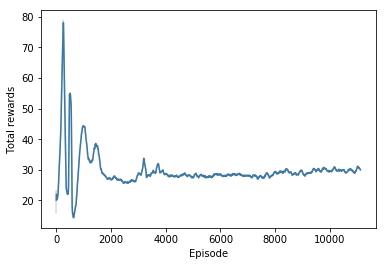

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

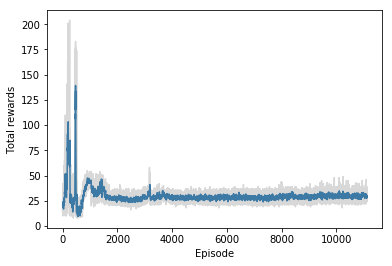

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

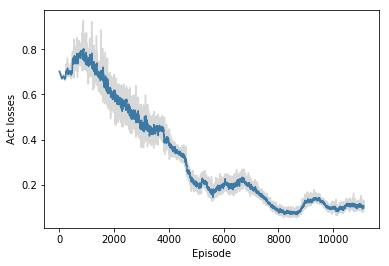

In [35]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

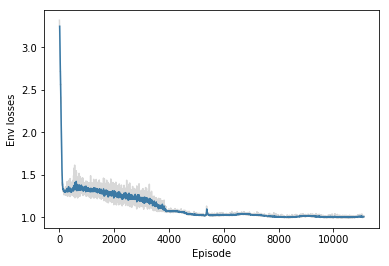

In [36]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

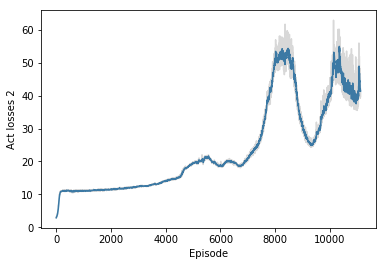

In [37]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [39]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
